# PXD013277

## Human cell lysate with added E. coli

### Data analysis performed by Phil Wilmarth, PSR Core OHSU

#### June 16, 2020

---

- [Overview](#overview) 
- [Library and data loading](#load_data) 
- [Clustering and normalization](#TMM)
- [1. 7.5 versus 15 (2-fold)](#7pt5_15) 
- [2. 7.5 versus 45 (6-fold)](#7pt5_45) 
- [3. 15 versus 45 (3-fold)](#15_45) 
- [Summary](#summary)

---

## <a name="overview"></a>Overview

The data is from the [PXD013277](http://proteomecentral.proteomexchange.org/cgi/GetDataset?ID=PXD013277) PRIDE archive. The human cells are the MCF7 cell line. E. coli lysate was spiked in at 3 different relative levels. The mixes were labeled with TMT 10-plex and analyzed in a large-scale fractionation using a Q Exactive HF instrument. The human samples and the E. coli samples are replicates of one cell lysate pellet. I think the digestions and labeling reactions are all independent. We will have some experimental variation, but not as much as true independent biological replicates. 

Sample Key:

Channel|E. coli (ug)|MCF7 (ug)|Total (ug)|Human Fraction
-------|------------|---------|----------|--------------
126C|7.5|70|77.5|0.90
127N|7.5|70|77.5|0.90
127C|7.5|70|77.5|0.90
128N|15|70|85|0.82
128C|15|70|85|0.82
129N|15|70|85|0.82
129C|15|70|85|0.82
130N|45|70|115|0.61
130C|45|70|115|0.61
131N|45|70|115|0.61 

The data set D3 (E. coli Spike-In TMT Data Set) is described in [this MCP paper](https://www.mcponline.org/content/19/6/1047) by Zhu, et al., 2020. Briefly, samples were reduced and alkylated, digested with LysC and trypsin in an SP3 bead protocol. The first-dimension separation was a peptide IEF-IPG method that resulted in 72 fractions. Each fraction was run on a standard reverse phase column into a Q Exactive HF instrument. Instrument parameters looked typical for an MS2 TMT experiment on this platform.

> Quote from bottom of first column of page 1049: "The statistical analysis was focused on the comparison between the 3 replicates with 7.5 microgram and the 4 replicates with 15 microgram of spiked in E. coli protein extract (the group with 45 microgram spike-in had substantial global impact on protein ratios after normalization)."

The above statement caught my eye. This looked like a pretty classic two proteome test mixture experiment. Human and E. coli have low tryptic peptide sequence homology, so issues of shared peptides are minimal. Why would the 45 microgram channels not be usable?

The data was downloaded from PRIDE (about 29 GB) and converted to compressed text files using [MSConvert](http://proteowizard.sourceforge.net/). The re-analysis used the [PAW pipeline](https://github.com/pwilmart/PAW_pipeline). A combined human and E. coli canonical reference proteome FASTA file was created using [fasta_utilities tools](https://github.com/pwilmart/fasta_utilities). A wide tolerance [Comet](http://comet-ms.sourceforge.net/) search (1.25 Da for parent ions) was used with recommended settings for high-resolution MS2 fragment ions. PSMs were filtered to 1% FDR. Protein inference used basic and extended parsimony analysis. TMT analysis used reporter ions from all unique (with respect to the final protein list) peptides summed into protein total intensities. Normalizations and statistical testing was done in edgeR using the [Jupyter notebook](https://jupyter.org/).

The RAW data files had 1,961,506 MS2 scans. At a 1% FDR, there were 303,201 scans that passed the score cutoffs (15.5% overall ID rate). There were about 10K protein IDs: 9,650 proteins excluding common contaminants, decoys, and proteins without any usable reporter ion signals using a two peptides per protein criterion. 

### References

> Zhu, Y., Orre, L.M., Tran, Y.Z., Mermelekas, G., Johansson, H.J., Malyutina, A., Anders, S. and Lehtiö, J., 2020. DEqMS: a method for accurate variance estimation in differential protein expression analysis. Molecular & Cellular Proteomics, 19(6), pp.1047-1057.

> Thompson, A., Schäfer, J., Kuhn, K., Kienle, S., Schwarz, J., Schmidt, G., Neumann, T. and Hamon, C., 2003. Tandem mass tags: a novel quantification strategy for comparative analysis of complex protein mixtures by MS/MS. Analytical chemistry, 75(8), pp.1895-1904.

> Wilmarth, P.A., Riviere, M.A. and David, L.L., 2009. Techniques for accurate protein identification in shotgun proteomic studies of human, mouse, bovine, and chicken lenses. Journal of ocular biology, diseases, and informatics, 2(4), pp.223-234.

> Robinson, M.D., McCarthy, D.J. and Smyth, G.K., 2010. edgeR: a Bioconductor package for differential expression analysis of digital gene expression data. Bioinformatics, 26(1), pp.139-140.

---

## This notebook is just human proteins


## Load the necessary R libraries

In [1]:
# library imports
library(tidyverse)
library(scales)
library(limma)
library(edgeR)
library(psych)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor



Attaching package: ‘psych’


The following objects are masked from ‘package:scales’:

    alpha, rescale


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha




## Define common functions for notebook use

In [2]:
#================= sample loading normalization ================================
SL_Norm <- function(df, color = NULL, plot = TRUE) {
    # This makes each channel sum to the average grand total
        # df - data frame of TMT intensities
        # returns a new data frame with normalized values
    
    # compute scaling factors to make colsums match the average sum
    norm_facs <- mean(c(colSums(df))) / colSums(df)
    cat("SL Factors:\n", sprintf("%-5s -> %f\n", colnames(df), norm_facs))
    cat("\n")
    df_sl  <- sweep(df, 2, norm_facs, FUN = "*")
    
    # visualize results and return data frame
    if(plot == TRUE) {
        boxplot(log10(df_sl), col = color, notch = TRUE, main = "SL Normalized data")
    }
    df_sl
}

# ================== TMM normalization from DGEList object =====================
apply_tmm_factors <- function(y, color = NULL, plot = TRUE) {
    # computes the tmm normalized data from the DGEList object
        # y - DGEList object
        # returns a dataframe with normalized intensities
    
    # compute and print "Sample loading" normalization factors
    lib_facs <- mean(y$samples$lib.size) / y$samples$lib.size
    cat("\nLibrary size factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), lib_facs))
    
    # compute and print TMM normalization factors
    tmm_facs <- 1/y$samples$norm.factors
    cat("\nTrimmed mean of M-values (TMM) factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), tmm_facs))
    
    # compute and print the final correction factors
    norm_facs <- lib_facs * tmm_facs
    cat("\nCombined (lib size and TMM) normalization factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), norm_facs))

    # compute the normalized data as a new data frame
    tmt_tmm <- as.data.frame(sweep(y$counts, 2, norm_facs, FUN = "*"))
    colnames(tmt_tmm) <- str_c(colnames(y$counts), "_tmm")
    
    # visualize results and return data frame
    if(plot == TRUE) {
        boxplot(log10(tmt_tmm), col = color, notch = TRUE, main = "TMM Normalized data")
    }
    tmt_tmm
}

# ================= reformat edgeR test results ================================
collect_results <- function(df, tt, x, xlab, y, ylab) {
    # Computes new columns and extracts some columns to make results frame
        # df - data in data.frame
        # tt - top tags table from edgeR test
        # x - columns for first condition
        # xlab - label for x
        # y - columns for second condition
        # ylab - label for y
        # returns a new dataframe
    
    # condition average vectors
    ave_x <- rowMeans(df[x])
    ave_y <- rowMeans(df[y])
    
    # FC, direction, candidates
    fc <- ifelse(ave_y > ave_x, (ave_y / ave_x), (-1 * ave_x / ave_y))
    direction <- ifelse(ave_y > ave_x, "up", "down")
    candidate <- cut(tt$FDR, breaks = c(-Inf, 0.01, 0.05, 0.10, 1.0), 
                     labels = c("high", "med", "low", "no"))
    
    # make data frame
    temp <- cbind(df[c(x, y)], data.frame(logFC = tt$logFC, FC = fc, 
                                          PValue = tt$PValue, FDR = tt$FDR, 
                                          ave_x = ave_x, ave_y = ave_y, 
                                          direction = direction, candidate = candidate, 
                                          Acc = tt$genes)) 
    
    # fix column headers for averages
    names(temp)[names(temp) %in% c("ave_x", "ave_y")]  <- str_c("ave_", c(xlab, ylab))    
    
    temp # return the data frame
}

# =============== p-value plots ================================================
pvalue_plots <- function(results, ylim, title) {
    # Makes p-value distribution plots
        # results - results data frame
        # ylim - ymax for expanded view
        # title - plot title
    p_plot <- ggplot(results, aes(PValue)) + 
        geom_histogram(bins = 100, fill = "white", color = "black") +
        geom_hline(yintercept = mean(hist(results$PValue, breaks = 100, 
                                     plot = FALSE)$counts[26:100]))

    # we will need an expanded plot
    p1 <- p_plot + ggtitle(str_c(title, " p-value distribution"))
    p2 <- p_plot + coord_cartesian(xlim = c(0, 1.0), ylim = c(0, ylim)) + ggtitle("p-values expanded")
    grid.arrange(p1, p2, nrow = 2) # from gridExtra package
}

# ============= log2 fold-change distributions =================================
log2FC_plots <- function(results, range, title) {
    # Makes faceted log2FC plots by candidate
        # results - results data frame
        # range - plus/minus log2 x-axis limits
        # title - plot title
    ggplot(results, aes(x = logFC, fill = candidate)) +
        geom_histogram(binwidth=0.1, color = "black") +
        facet_wrap(~candidate) +
        ggtitle(title) + 
        coord_cartesian(xlim = c(-range, range))
}

# ========== Setup for MA and volcano plots ====================================
transform <- function(results, x, y) {
    # Make data frame with some transformed columns
        # results - results data frame
        # x - columns for x condition
        # y - columns for y condition
        # return new data frame
    df <- data.frame(log10((results[x] + results[y])/2), 
                     log2(results[y] / results[x]), 
                     results$candidate,
                     -log10(results$FDR))
    colnames(df) <- c("A", "M", "candidate", "P")
    
    df # return the data frame
}

# ========== MA plots using ggplot =============================================
MA_plots <- function(results, x, y, title) {
    # makes MA-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # returns a list of plots 
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # 2-fold change lines
    ma_lines <- list(geom_hline(yintercept = 0.0, color = "black"),
                     geom_hline(yintercept = 1.0, color = "black", linetype = "dotted"),
                     geom_hline(yintercept = -1.0, color = "black", linetype = "dotted"))

    # make main MA plot
    ma <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scale_y_continuous(paste0("logFC (", y, "/", x, ")")) +
        scale_x_continuous("Ave_intensity") +
        ggtitle(title) + 
        ma_lines
    
    # make separate MA plots
    ma_facet <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scale_y_continuous(paste0("log2 FC (", y, "/", x, ")")) +
        scale_x_continuous("log10 Ave_intensity") +
        ma_lines +
        facet_wrap(~ candidate) +
        ggtitle(str_c(title, " (separated)"))

    # make the plots visible
    print(ma)
    print(ma_facet)
}    

# ========== Scatter plots using ggplot ========================================
scatter_plots <- function(results, x, y, title) {
    # makes scatter-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # returns a list of plots
    
    # 2-fold change lines
    scatter_lines <- list(geom_abline(intercept = 0.0, slope = 1.0, color = "black"),
                          geom_abline(intercept = 0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          geom_abline(intercept = -0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          scale_y_log10(),
                          scale_x_log10())

    # make main scatter plot
    scatter <- ggplot(results, aes_string(x, y)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        ggtitle(title) + 
        scatter_lines

    # make separate scatter plots
    scatter_facet <- ggplot(results, aes_string(x, y)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scatter_lines +
        facet_wrap(~ candidate) +
        ggtitle(str_c(title, " (separated)")) 

    # make the plots visible
    print(scatter)
    print(scatter_facet)
}

# ========== Volcano plots using ggplot ========================================
volcano_plot <- function(results, x, y, title) {
    # makes a volcano plot
        # results - a data frame with edgeR results
        # x - string for the x-axis column
        # y - string for y-axis column
        # title - plot title string
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # build the plot
    ggplot(temp, aes(x = M, y = P)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        xlab("log2 FC") +
        ylab("-log10 FDR") +
        ggtitle(str_c(title, " Volcano Plot"))
}

# ============== individual protein expression plots ===========================
# function to extract the identifier part of the accesssion
get_identifier <- function(accession) {
    identifier <- str_split(accession, "\\|", simplify = TRUE)
    identifier[,3]
}

set_plot_dimensions <- function(width_choice, height_choice) {
    options(repr.plot.width=width_choice, repr.plot.height=height_choice)
}

plot_top_tags <- function(results, nleft, nright, top_tags) {
    # results should have data first, then test results (two condition summary table)
    # nleft, nright are number of data points in each condition
    # top_tags is number of up and number of down top DE candidates to plot
    # get top ipregulated
    up <- results %>% 
        filter(logFC >= 0) %>%
        arrange(FDR)
    up <- up[1:top_tags, ]
    
    # get top down regulated
    down <- results %>% 
        filter(logFC < 0) %>%
        arrange(FDR)
    down <- down[1:top_tags, ]
    
    # pack them
    proteins <- rbind(up, down)
        
    color = c(rep("red", nleft), rep("blue", nright))
    for (row_num in 1:nrow(proteins)) {
        row <- proteins[row_num, ]
        vec <- as.vector(unlist(row[1:(nleft + nright)]))
        names(vec) <- colnames(row[1:(nleft + nright)])
        title <- str_c(get_identifier(row$Acc), ", int: ", scientific(mean(vec), 2), 
                       ", FDR: ", scientific(row$FDR, digits = 3), 
                       ", FC: ", round(row$FC, digits = 1),
                       ", ", row$candidate)
        barplot(vec, col = color, main = title,
                cex.main = 1.0, cex.names = 0.7, cex.lab = 0.7)
    }    
}

## <a name="load_data"></a>Load the TMT intensity data

The data was gently prepped in Excel to remove contaminants, decoys, and proteins without intensities. We have an accessions column and a column to denote human or E. coli species. There are the 10 TMT channels.

In [3]:
# load the IRS-normalized data and check the table
data_all <- read_tsv("edgeR_input.txt")

# save gene names for edgeR so we can double check that results line up
accessions_all <- data_all$Accession
species_all <- data_all$HorE

# get just the TMT columns
data_tmt <- filter(data_all, HorE == "human") 
accessions <- data_tmt$Accession
species <- data_tmt$HorE

data_tmt <- select(data_tmt, -Accession, -HorE)

# see how many rows of data we have
length(accessions)

Parsed with column specification:
cols(
  Accession = col_character(),
  HorE = col_character(),
  A_70_7pt5 = col_double(),
  B_70_7pt5 = col_double(),
  C_70_7pt5 = col_double(),
  A_70_15 = col_double(),
  B_70_15 = col_double(),
  C_70_15 = col_double(),
  D_70_15 = col_double(),
  A_70_45 = col_double(),
  B_70_45 = col_double(),
  C_70_45 = col_double()
)



[1] 7559

In [4]:
# define the 3 spike-in groups
low <- 1:3
med <- 4:7
high <- 8:10

# set some colors by condition
colors = c(rep('red', length(low)), rep('blue', length(med)), rep('green', length(high)))

SL Factors:
 A_70_7pt5 -> 0.957242
 B_70_7pt5 -> 1.033604
 C_70_7pt5 -> 0.986180
 A_70_15 -> 0.901481
 B_70_15 -> 0.915419
 C_70_15 -> 0.849285
 D_70_15 -> 1.011951
 A_70_45 -> 1.193684
 B_70_45 -> 1.088943
 C_70_45 -> 1.175872



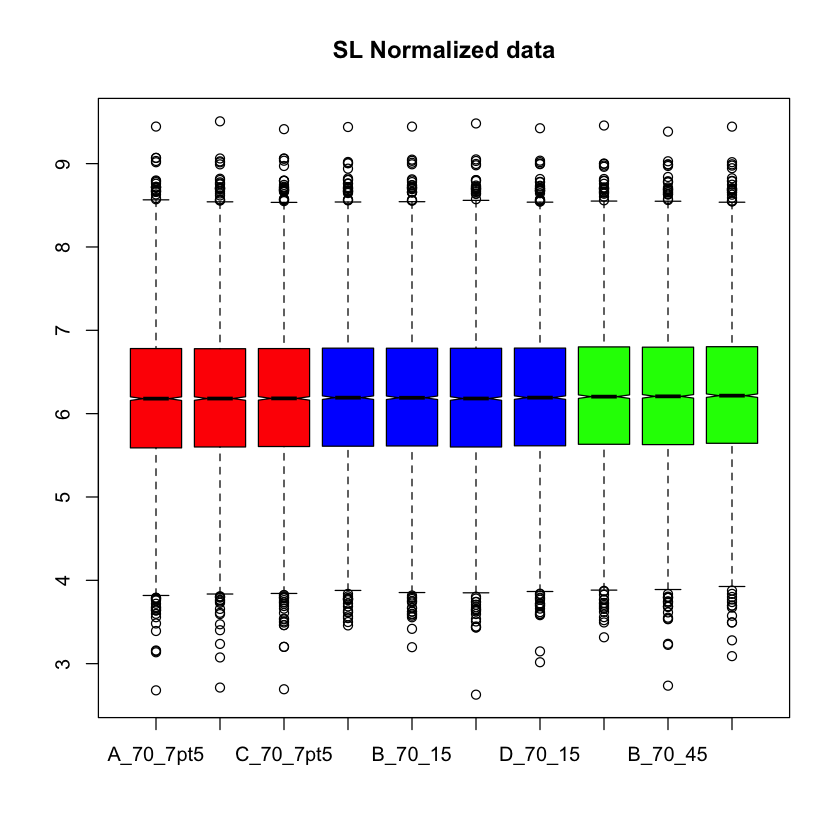

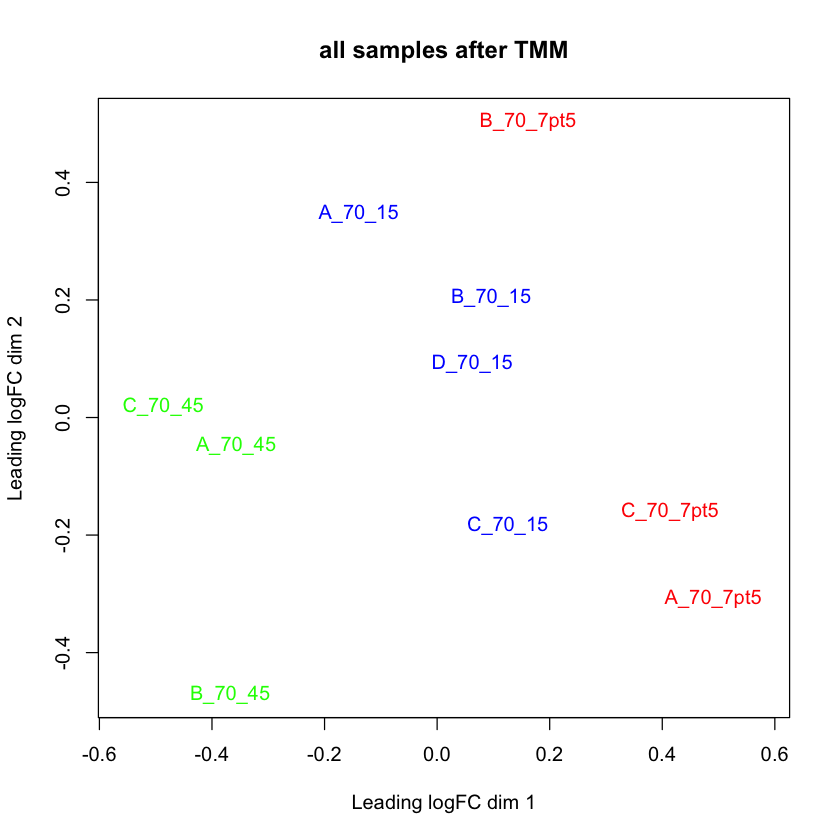

In [5]:
# do simple SL normalization
tmt_sl <- SL_Norm(data_tmt, color = colors)

# check the clustering
plotMDS(log2(tmt_sl), col = colors, main = "all samples after TMM")

### Use data from all spike-in channels for edgeR analysis

We are defining the groups that will be compared explicitly and using all of the samples for variance estimates. We will put the data into a data frame, grouped by condition. We will define some column indexes for each condition, set some colors for plotting, and see how the data cluster by condition.

## <a name="TMM"></a>Run TMM normalization and check final clustering 

We will the data into edgeR data structures and call the `calcNormFactors` function to perform library size and the trimmed mean of M-values (TMM) normalization. We will double check if the TMM normalization changed the clustering that we had above. 

> Robinson, M.D. and Oshlack, A., 2010. A scaling normalization method for differential expression analysis of RNA-seq data. Genome biology, 11(3), p.R25.

We need to use the edgeR normalization factors to produce the TMM normalized data that the statistical testing will be working with. EdgeR uses the normalization factors in its statistical modeling but does not output the normalized intensities. We compute the normalized intensities with the `apply_tmm_factors function`.


Library size factors:
 A_70_7pt5 -> 0.957242
 B_70_7pt5 -> 1.033604
 C_70_7pt5 -> 0.986180
 A_70_15 -> 0.901481
 B_70_15 -> 0.915419
 C_70_15 -> 0.849285
 D_70_15 -> 1.011951
 A_70_45 -> 1.193684
 B_70_45 -> 1.088943
 C_70_45 -> 1.175872

Trimmed mean of M-values (TMM) factors:
 A_70_7pt5 -> 1.022173
 B_70_7pt5 -> 1.018050
 C_70_7pt5 -> 1.009745
 A_70_15 -> 1.006735
 B_70_15 -> 1.004676
 C_70_15 -> 1.010853
 D_70_15 -> 0.999311
 A_70_45 -> 0.980196
 B_70_45 -> 0.981987
 C_70_45 -> 0.967713

Combined (lib size and TMM) normalization factors:
 A_70_7pt5 -> 0.978467
 B_70_7pt5 -> 1.052261
 C_70_7pt5 -> 0.995790
 A_70_15 -> 0.907553
 B_70_15 -> 0.919699
 C_70_15 -> 0.858503
 D_70_15 -> 1.011253
 A_70_45 -> 1.170044
 B_70_45 -> 1.069328
 C_70_45 -> 1.137906


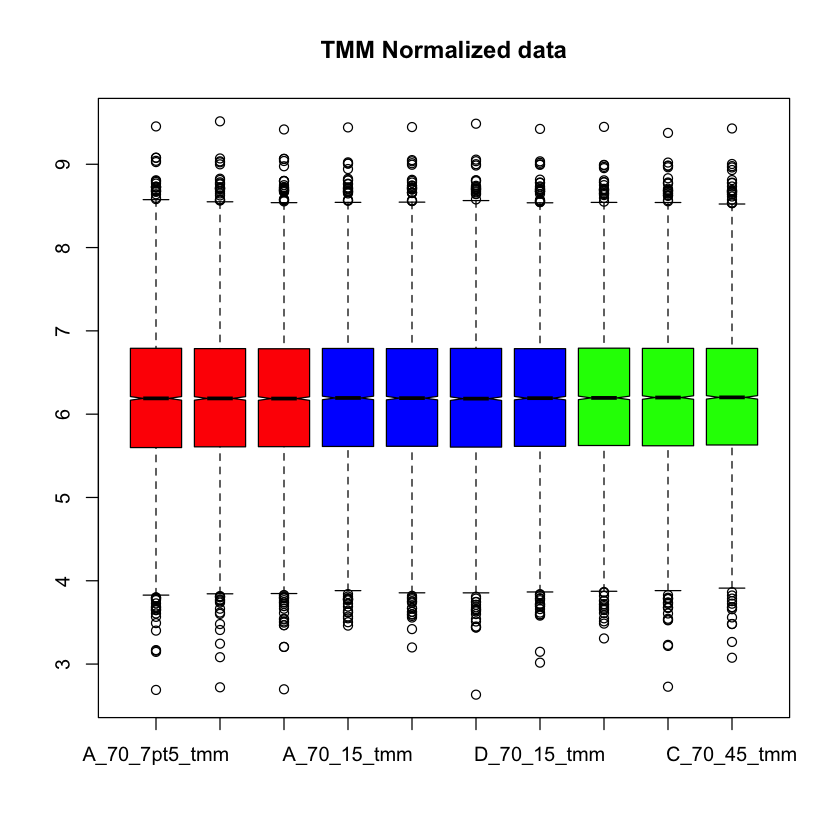

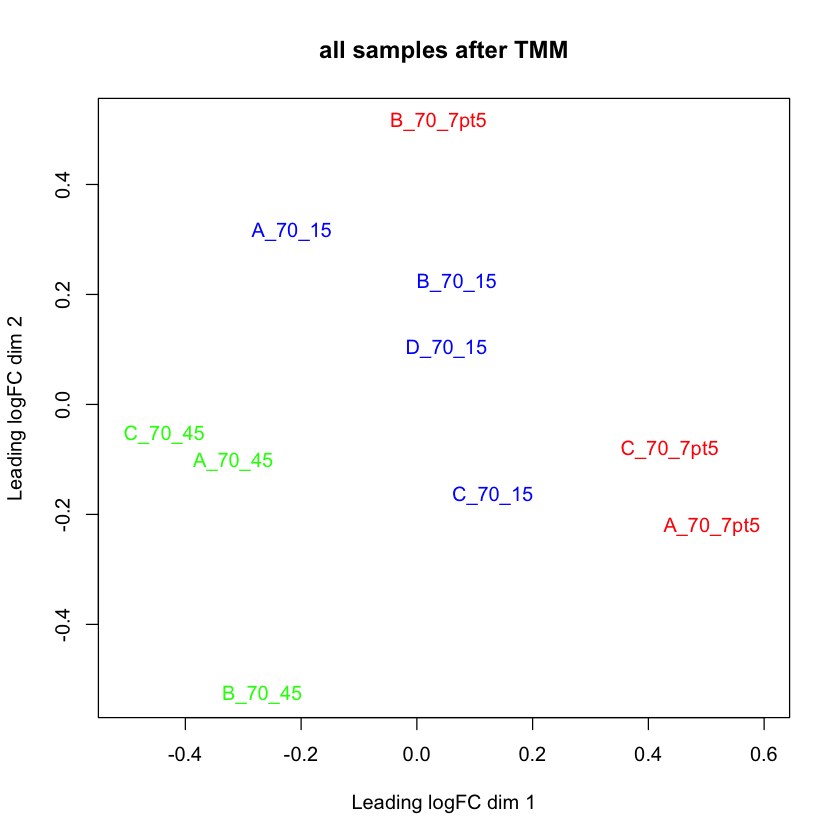

In [6]:
# get the biological sample data into a DGEList object
group = c(rep("low", length(low)), rep("med", length(med)), rep("high", length(high)))
y <- DGEList(counts = data_tmt, group = group, genes = accessions)

# run TMM normalization (also includes a library size factor)
y <- calcNormFactors(y)

tmt_tmm <- apply_tmm_factors(y, color = colors)

# check the clustering
plotMDS(y, col = colors, main = "all samples after TMM")

### TMM factors are very close to 1.0

The IRS method already takes care of the library size type of normalizations. We could still have compositional differences between sample groups that the TMM factors would correct for. We do not have any library size or TMM factors that are much different from 1.0.

The data after TMM are very similar (boxplots and cluster views) to just the simple sample loading normalization we used above. We can check the column sums after TMM. When TMM factors are small (close to 1.0), we should not see much deviation from similar totals for each channel.

In [7]:
# check the column (intensity) sums after TMM
colSums(tmt_tmm)

A_70_7pt5_tmm B_70_7pt5_tmm C_70_7pt5_tmm   A_70_15_tmm   B_70_15_tmm 
  84235357160   83895616197   83211174865   82963123534   82793453209 
  C_70_15_tmm   D_70_15_tmm   A_70_45_tmm   B_70_45_tmm   C_70_45_tmm 
  83302530337   82351307427   80776093720   80923748402   79747389203

# EdgeR statistical testing starts here

## Compute the shared variance trend

One of the most powerful features of edgeR (and limma) is computing variances across larger numbers of genes (proteins) to get more robust variance estimates for small replicate experiments. Here, we have 18 samples across all conditions to use to improve the variance estimates and reduce false positive differential expression (DE) candidates. We have an edgeR `estimateDisp` function that does all of this and a visualization function to check the result.

We loaded the IRS data into `DGEList` object `y` a few cells above and did the normalization step. We need to estimate the dispersion parameters before we can do the actual statistical testing. This only needs to be done once. Each exact test will take two conditions and compare them using the normalization factors and dispersion estimates saved in `y`.

Design matrix not provided. Switch to the classic mode.


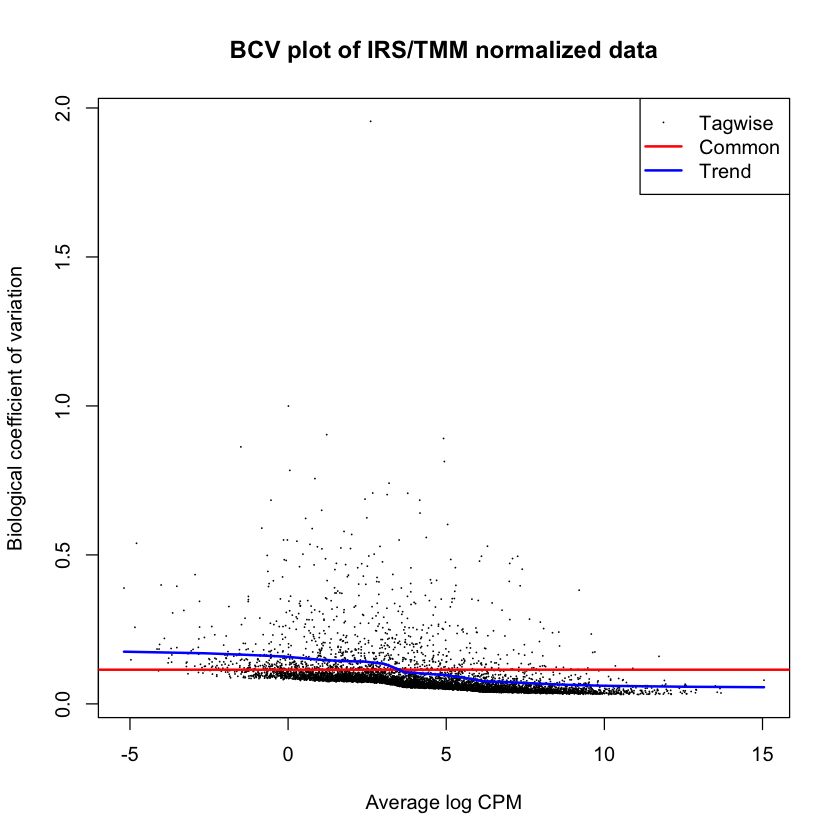

In [8]:
# compute dispersions and plot BCV
y <- estimateDisp(y)
plotBCV(y, main = "BCV plot of IRS/TMM normalized data")

## <a name="7pt5_15"></a>(1) 7.5 versus 15 for E. coli

We will specify the pair of interest for the exact test in edgeR and use the experiment-wide dispersion. The `decideTestsDGE` call will tell us how many up and down regulated candidates we have at an FDR of 0.10. The `topTags` call does the Benjamini-Hochberg multiple testing corrections. We save the test results in `tt`. We use a handy MA (mean-average) plotting function from `limma` to visualize the DE candidates, and then check the p-value distribution.

       med-low
Down         6
NotSig    7472
Up          81

genes                 logFC     logCPM    PValue       FDR         
904  sp|Q96AQ6|PBIP1_HUMAN 0.5953730  7.676296 3.499105e-17 2.644974e-13
4769 sp|Q96FJ0|STALP_HUMAN 0.6122400  3.329474 2.965167e-12 1.120685e-08
1726 sp|Q9BV73|CP250_HUMAN 0.6067956  6.457896 1.168280e-11 2.943676e-08
7558 sp|Q5D0E6|DALD3_HUMAN 1.1140070 -4.968906 5.321766e-11 8.625928e-08
4549 sp|Q9HCI6|K1586_HUMAN 0.6119313  3.545009 5.705734e-11 8.625928e-08
1112 sp|Q9BZD4|NUF2_HUMAN  0.4078572  7.325299 1.628036e-10 2.051053e-07
5469 sp|Q8N3I7|BBS5_HUMAN  0.8471080  2.595251 2.590616e-09 2.797495e-06
2991 sp|O95819|M4K4_HUMAN  0.4345827  5.047739 3.448755e-09 3.258643e-06
1420 sp|Q06546|GABPA_HUMAN 0.6244721  6.857668 5.146795e-09 4.322736e-06
2334 sp|Q8TCE6|DEN10_HUMAN 0.3284854  5.746784 1.579416e-08 1.162526e-05

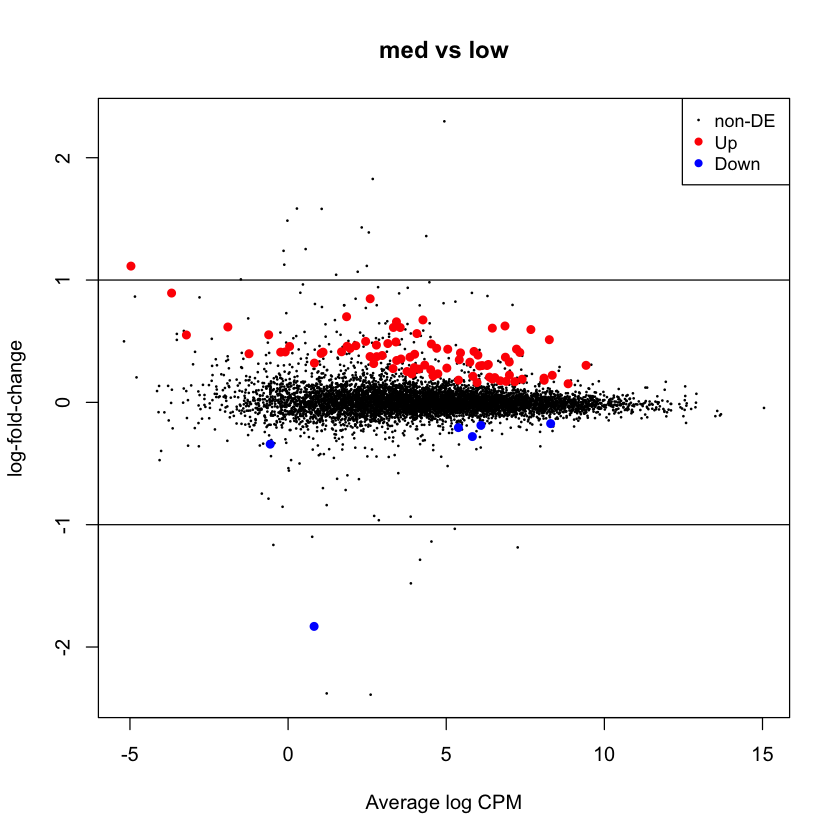

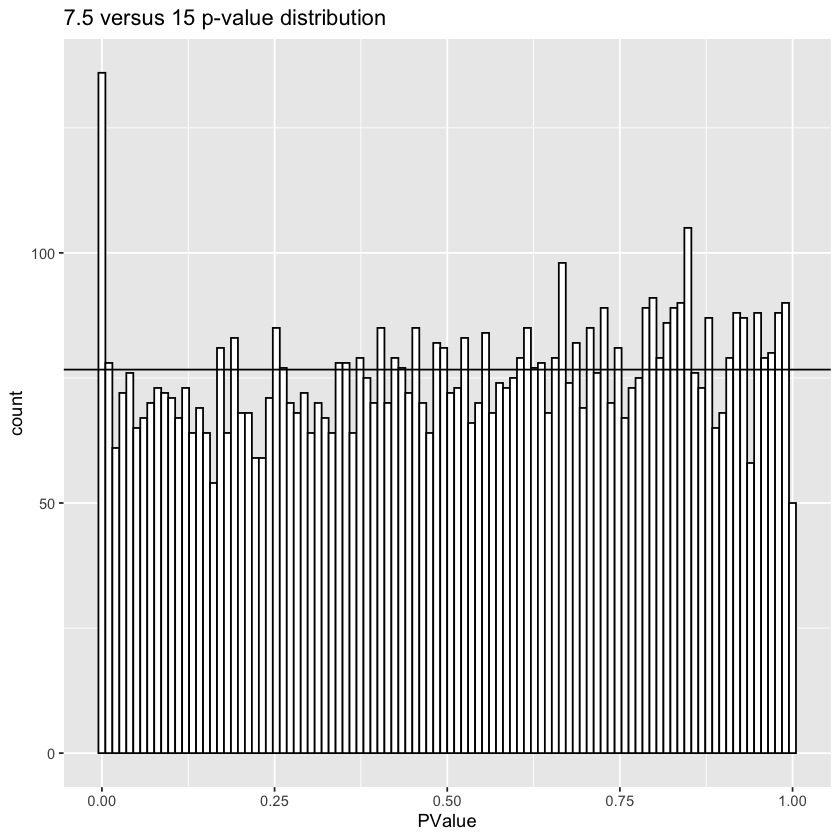

In [9]:
# the exact test object has columns like fold-change, CPM, and p-values
et <- exactTest(y, pair = c("low", "med"))

# this counts up, down, and unchanged genes (proteins) at 10% FDR
summary(decideTestsDGE(et, p.value = 0.10))

# the topTags function adds the BH FDR values to an exactTest data frame 
# make sure we do not change the row order (the sort.by parameter)!
topTags(et)$table
tt <- topTags(et, n = Inf, sort.by = "none")

# make an MD plot (like MA plot)
plotMD(et, p.value = 0.10)
abline(h = c(-1, 1), col = "black")

# check the p-value distribution
ggplot(tt$table, aes(PValue)) + 
  geom_histogram(bins = 100, fill = "white", color = "black") + 
  geom_hline(yintercept = mean(hist(et$table$PValue, breaks = 100, 
                                    plot = FALSE)$counts[26:100])) +
  ggtitle("7.5 versus 15 p-value distribution")

### We have 87 false positive DE candidates!

The human background should not result in many (if any) DE candidates. The p-value distribution is mostly flat, but there is an actual low p-value spike. We have some pretty significant p-values for the top tags. Note that we have unbalanced DE candidates. We have more human proteins over-expressed in the 15 microgram E. coli spike in than we have in the 7.5 microgram E. coli spike-in.

## Compute averages, flag candidates, and save the pair-wise test results

We will add the statistical testing results (logFC, p-values, and FDR), condition intensity averages, and candidate status to the `results` data frame (which has the TMM-normalized data) and also accumulate all of the three comparisons into `all_results`.

Even though we do not have many candidates, we will still make the MA plots, scatter plots, and volcano plot using ggplot2. We will also look at the distribution of log2 expression ratios separated by differential expression (DE) category. The Benjamini-Hochberg corrected edgeR p-values are used to categorize the DE candidates: no > 0.10 > low > 0.05 > med > 0.01 > high.

In [10]:
# get the results summary
results <- collect_results(tmt_tmm, tt$table, low, "low", med, "med")
results$species <- as.factor(species)

# make column names unique by adding comparison (for the accumulated frame)
results_temp  <- results
colnames(results_temp) <- str_c(colnames(results), "_low_med")

# accumulate the testing results
all_results <- results_temp

### Count candidates and look at fold-change distributions

candidate n   
1 high        38
2 med         30
3 low         19
4 no        7472

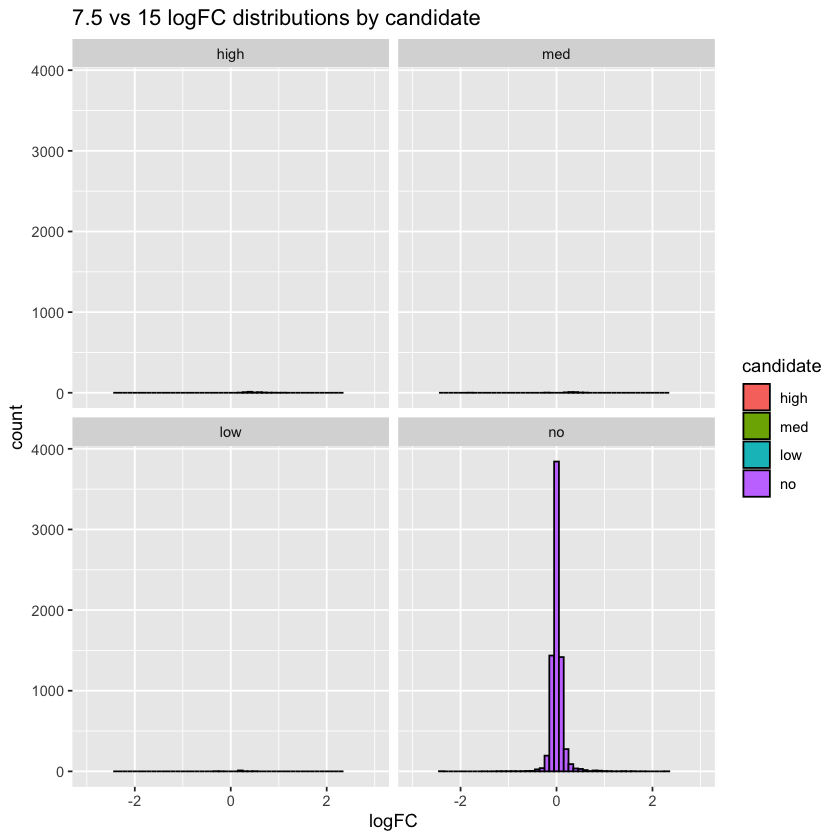

In [11]:
# see how many candidates by category
results %>% count(candidate)

# plot log2 fold-changes by category
ggplot(results, aes(x = logFC, fill = candidate)) +
  geom_histogram(binwidth=0.1, color = "black") +
  facet_wrap(~candidate) +
  coord_cartesian(xlim = c(-3, 3)) +
  ggtitle("7.5 vs 15 logFC distributions by candidate")

## Main summary plots

We have many comparisons to visualize, so we will use functions to generate a series of plots. We will make: an MA plot with candidates highlighted by color, faceted MA plots separated by candidate status, a scatter plot with candidates highlighted by color, faceted scatter plots separated by candidate status, and a volcano plot with candidates highlighted by color. The solid black lines in the MA and scatter plots are the 1-to-1 lines; the dotted lines are 2-fold change lines.

### MA plots

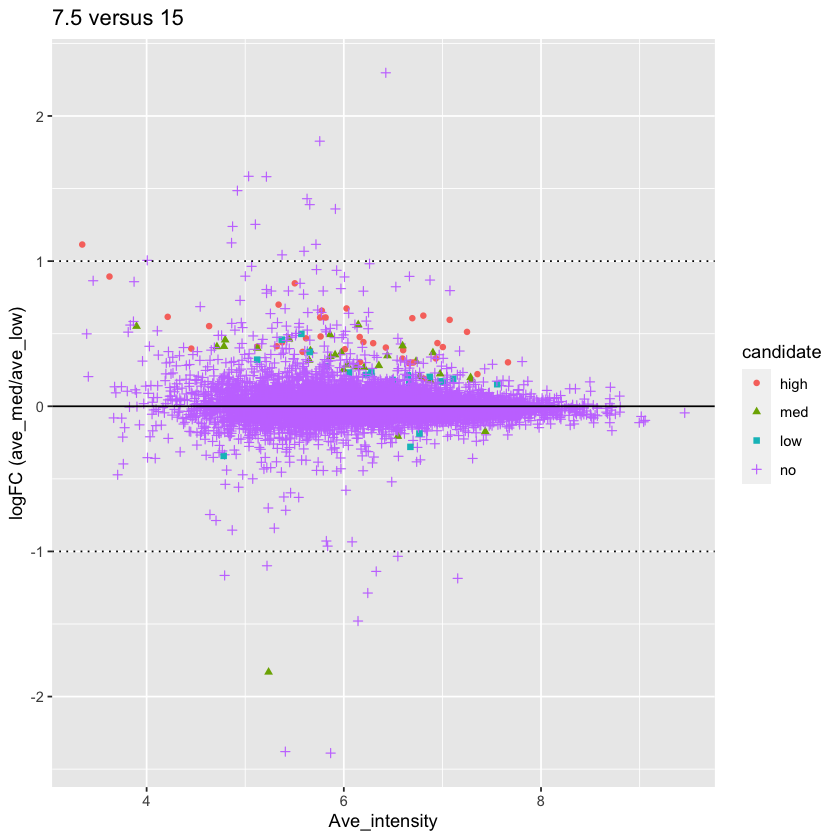

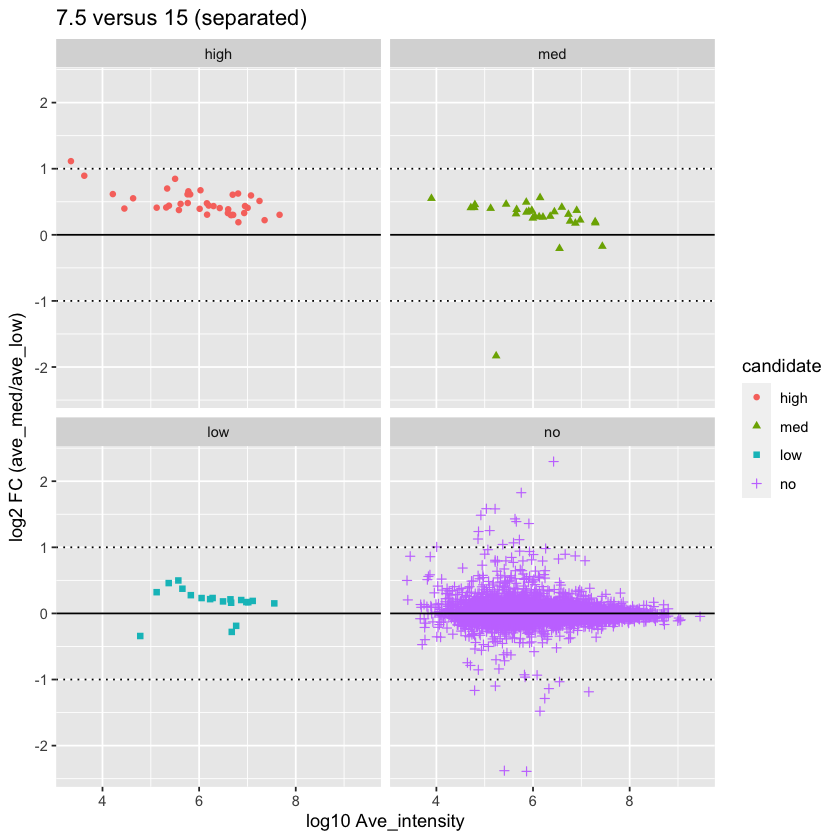

In [12]:
# make MA plots
MA_plots(results, "ave_low", "ave_med", "7.5 versus 15")

### Scatter plots

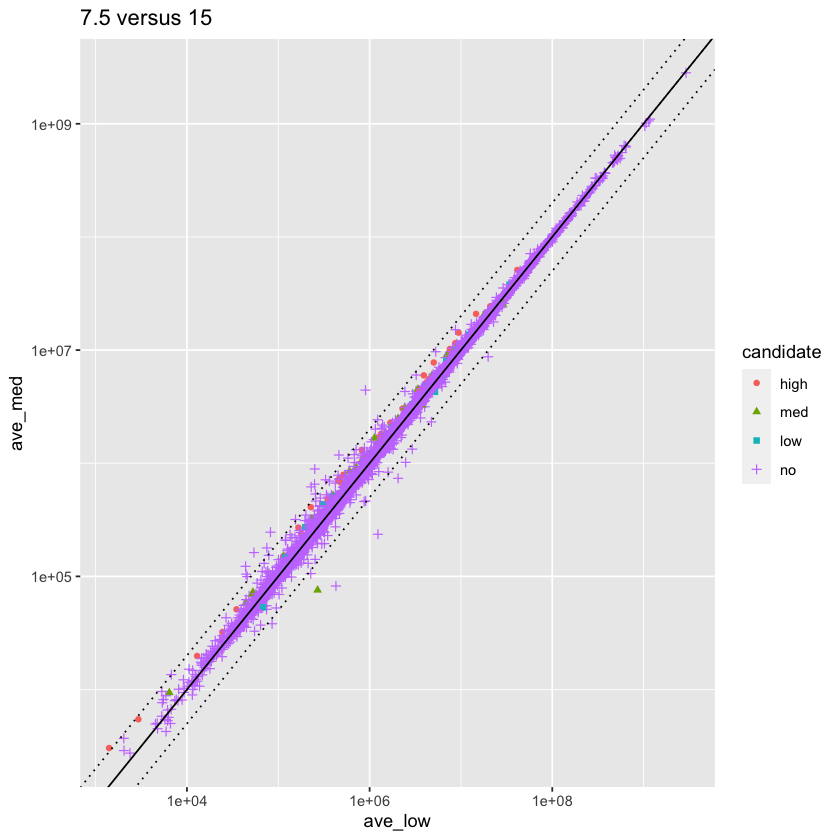

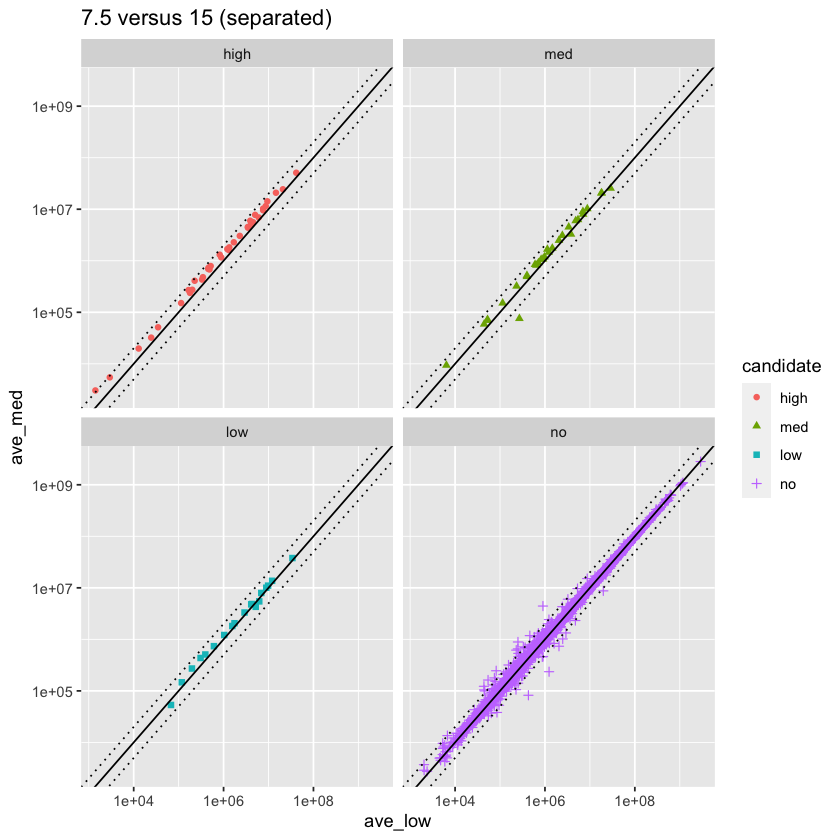

In [13]:
# make scatter plots
scatter_plots(results, "ave_low", "ave_med", "7.5 versus 15")

### Volcano plot

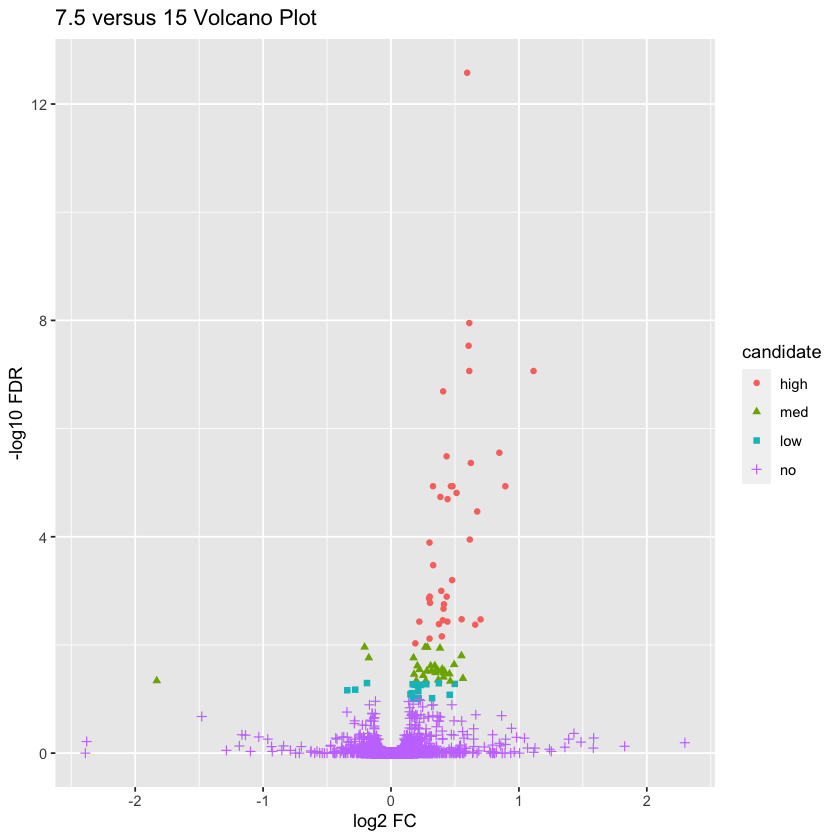

In [14]:
# make a volcano plot
volcano_plot(results, "ave_low", "ave_med", "7.5 versus 15")

### Not too many candidates

We should not really see any candidates for the constant human background. We do have over 7,500 human proteins, so maybe 87 DE candidates is a reasonable number of random test results. The asymmetry in the candidate expression direction is worrisome.

### Check some individual protein expression

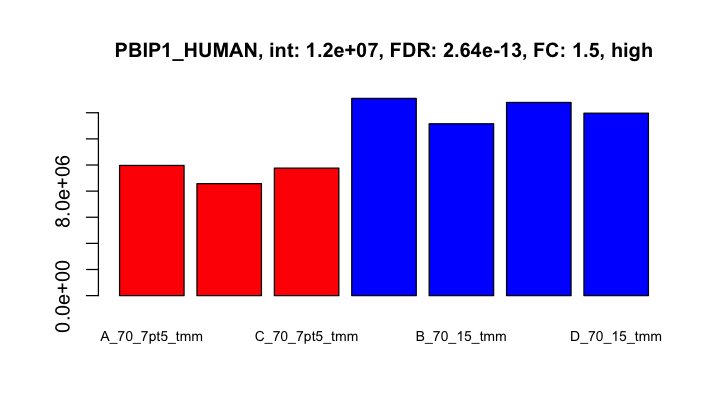

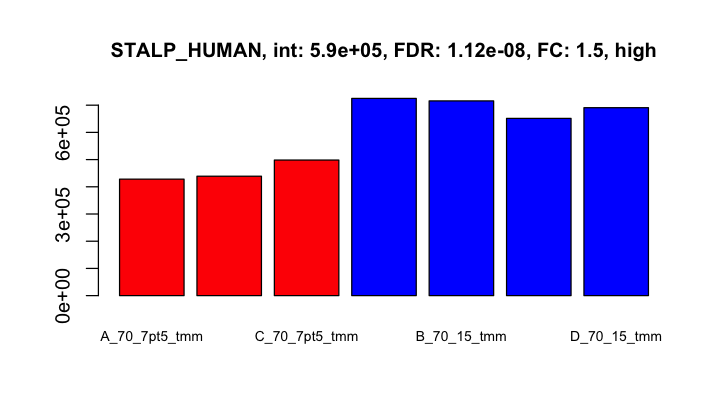

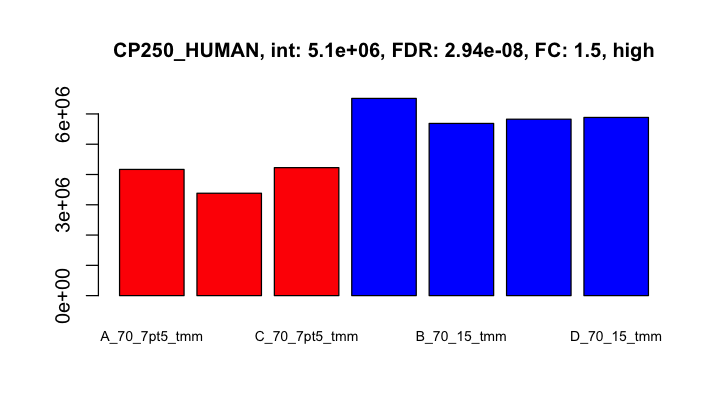

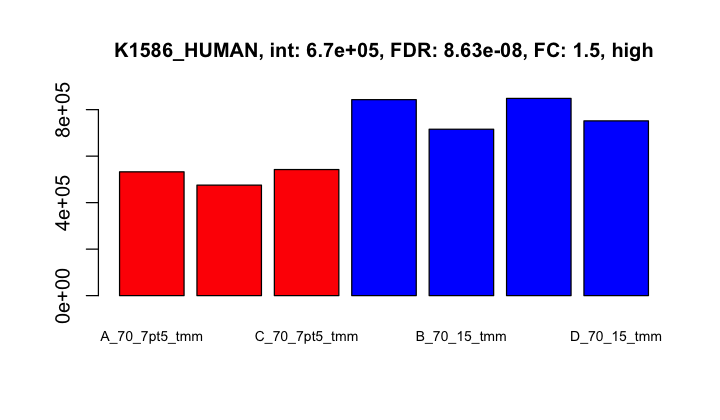

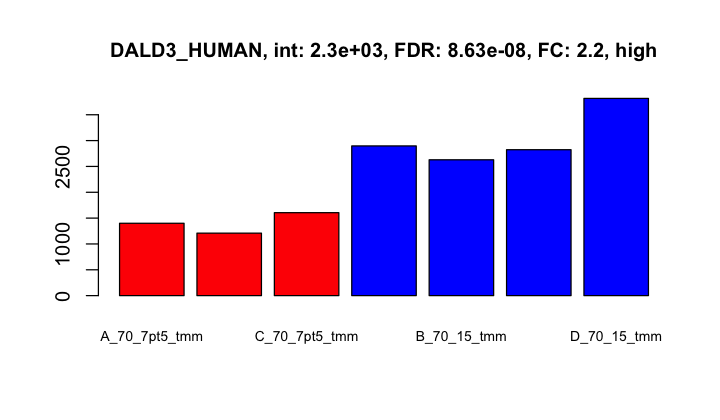

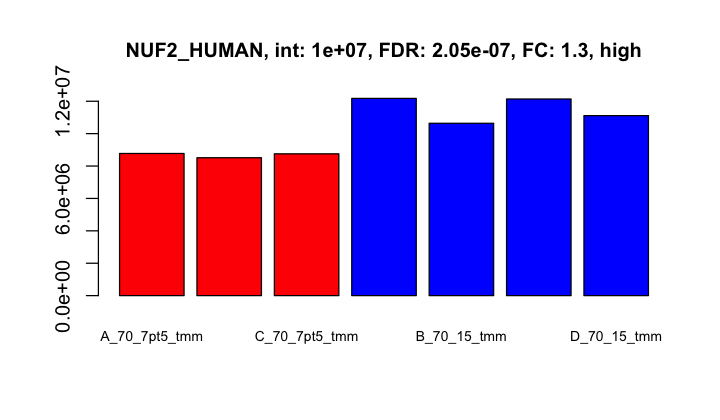

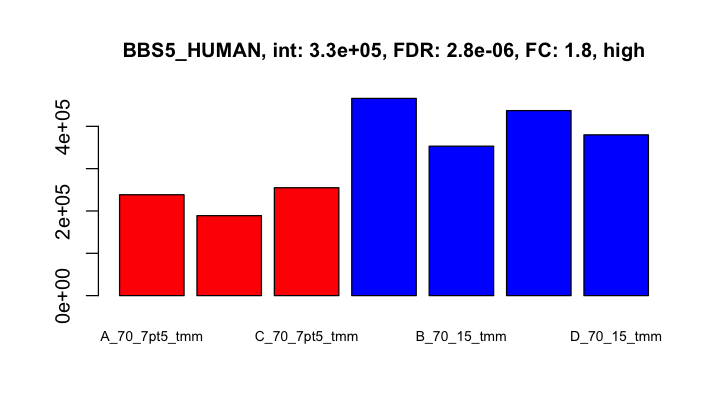

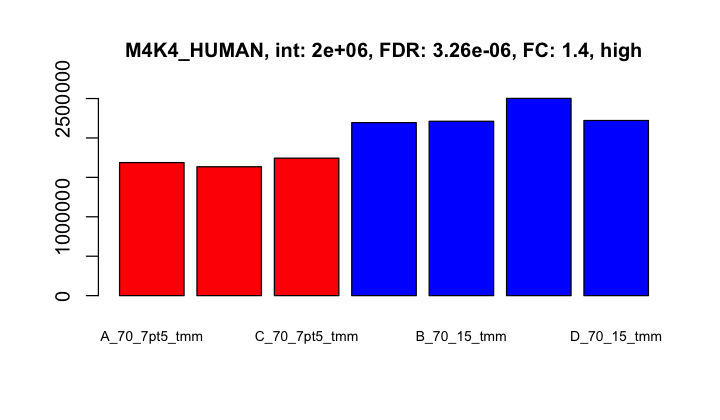

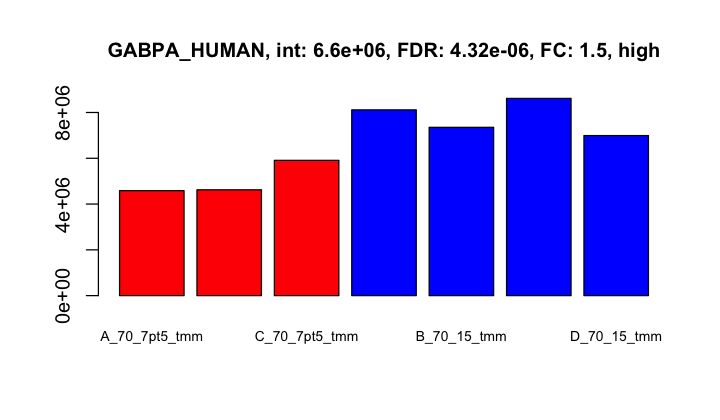

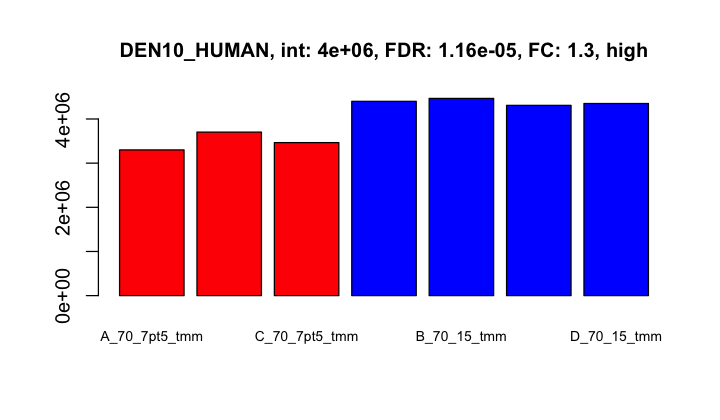

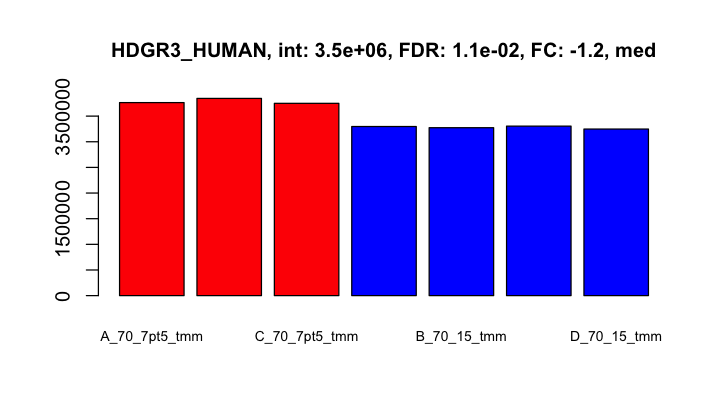

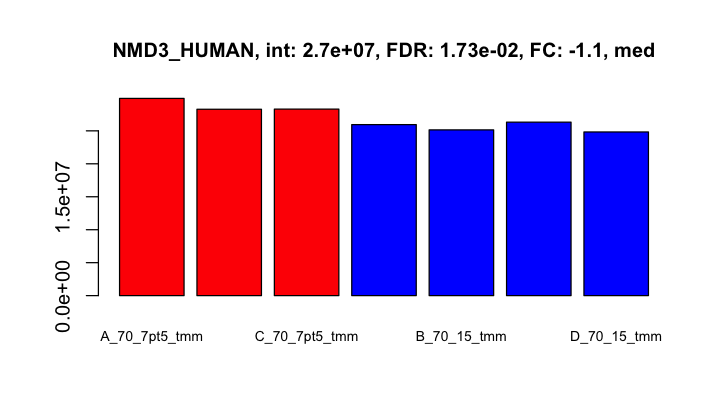

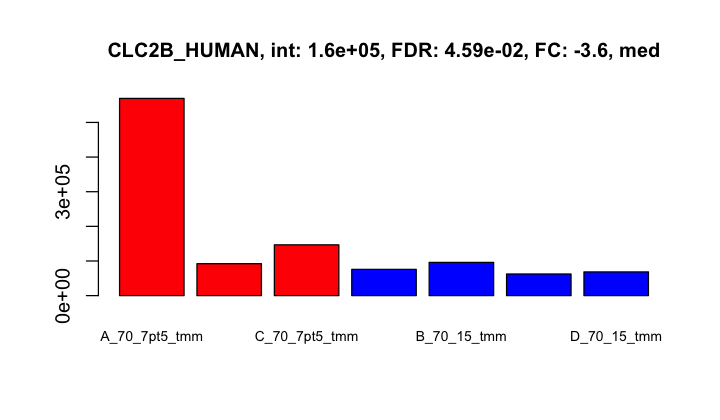

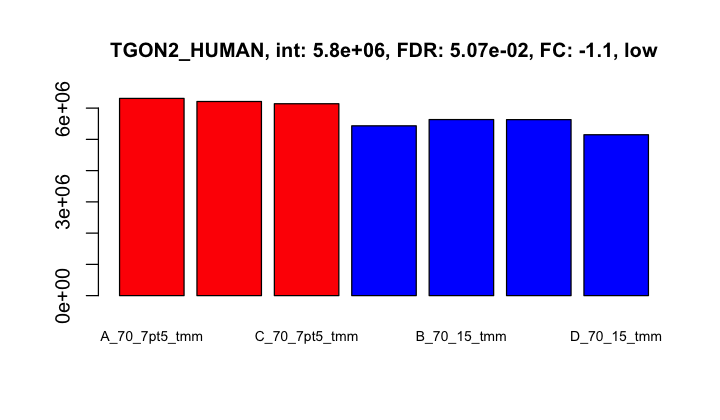

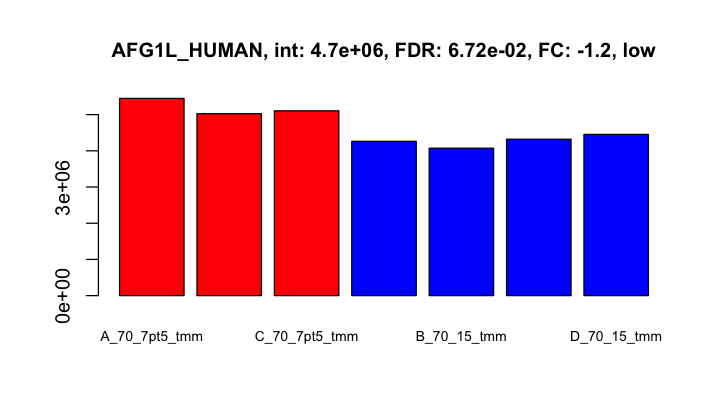

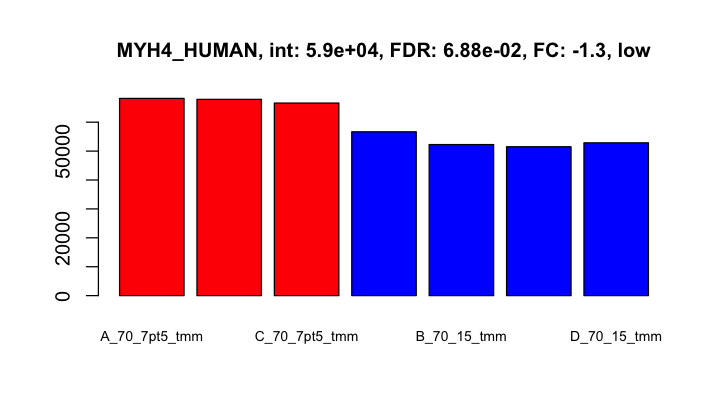

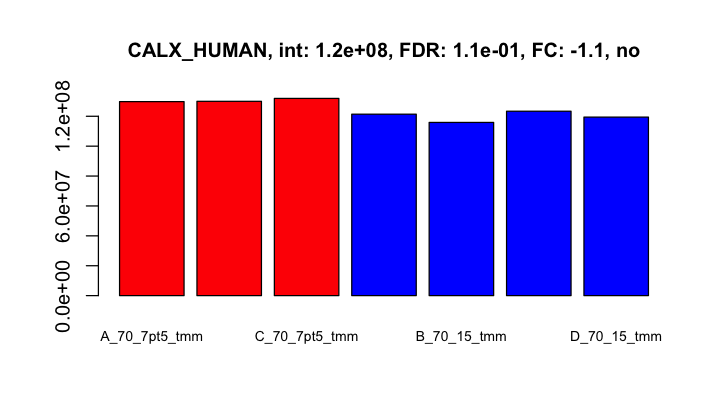

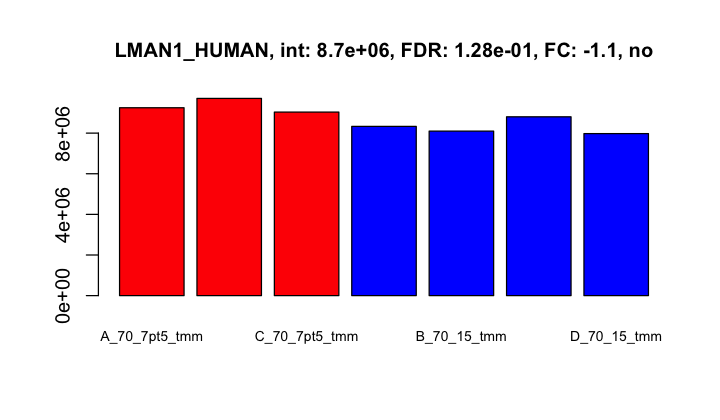

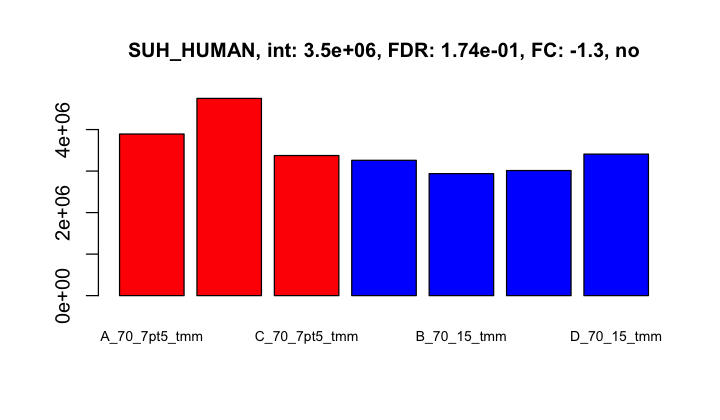

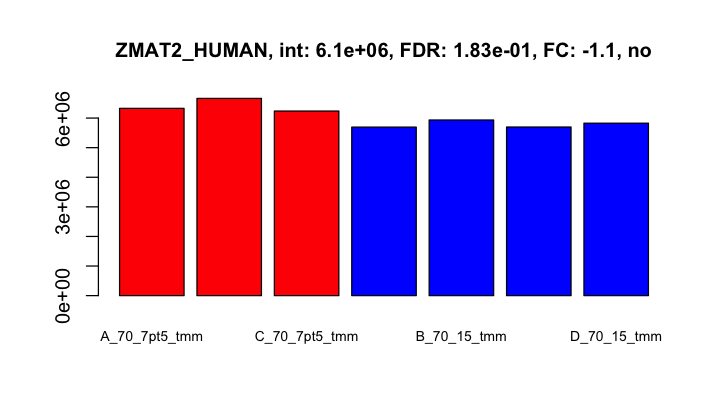

In [15]:
# look at the top candidates
set_plot_dimensions(6, 3.5)
plot_top_tags(results, 3, 4, 10)
set_plot_dimensions(7, 7)

## <a name="7pt5_45"></a> (2) 7.5 versus 45

We will do the same testing to compare the human background from the 7.5 microgram E. coli samples to the 45 microgram E. coli.

       high-low
Down        688
NotSig     5915
Up          956

genes                 logFC    logCPM   PValue       FDR         
904  sp|Q96AQ6|PBIP1_HUMAN 1.556755 7.676296 1.178639e-92 8.909331e-89
1112 sp|Q9BZD4|NUF2_HUMAN  1.205373 7.325299 3.727878e-69 1.408951e-65
2991 sp|O95819|M4K4_HUMAN  1.366491 5.047739 1.576302e-66 3.971755e-63
1726 sp|Q9BV73|CP250_HUMAN 1.642215 6.457896 1.249597e-64 2.361425e-61
4769 sp|Q96FJ0|STALP_HUMAN 1.598910 3.329474 6.713808e-64 1.014994e-60
4549 sp|Q9HCI6|K1586_HUMAN 1.663273 3.545009 7.499218e-61 9.447765e-58
2106 sp|Q96GQ5|RUS1_HUMAN  1.223216 6.001082 4.145689e-59 4.476752e-56
5275 sp|Q9C0G0|ZN407_HUMAN 1.398109 2.792264 1.769101e-54 1.671580e-51
3342 sp|Q8NBP0|TTC13_HUMAN 1.326239 4.697288 1.554272e-52 1.305416e-49
646  sp|Q6GMV3|PTRD1_HUMAN 1.511049 8.260152 7.759425e-52 5.865349e-49

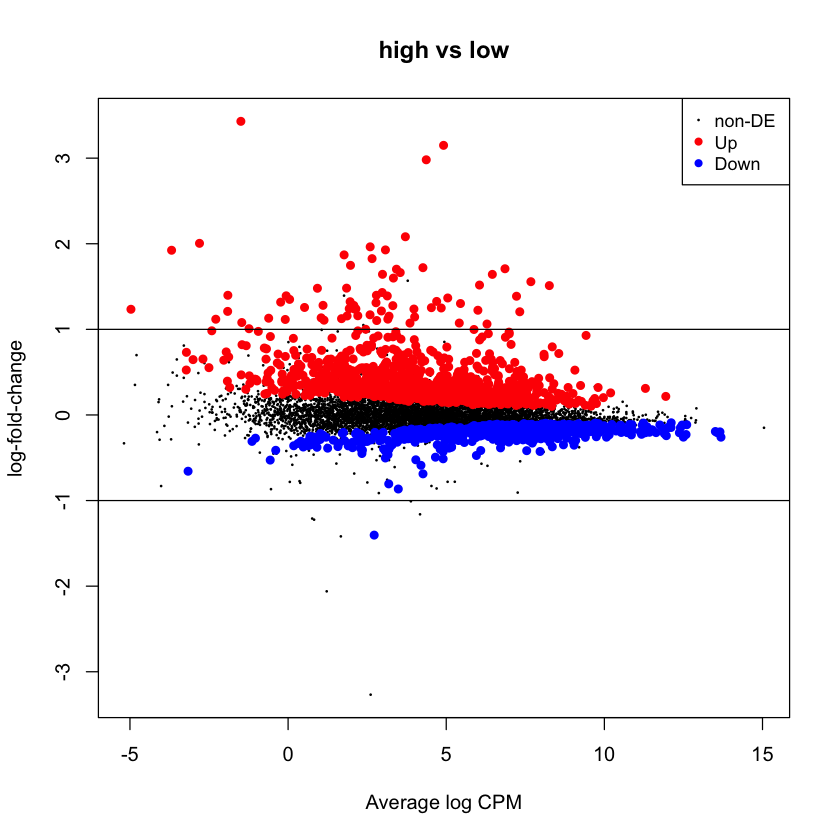

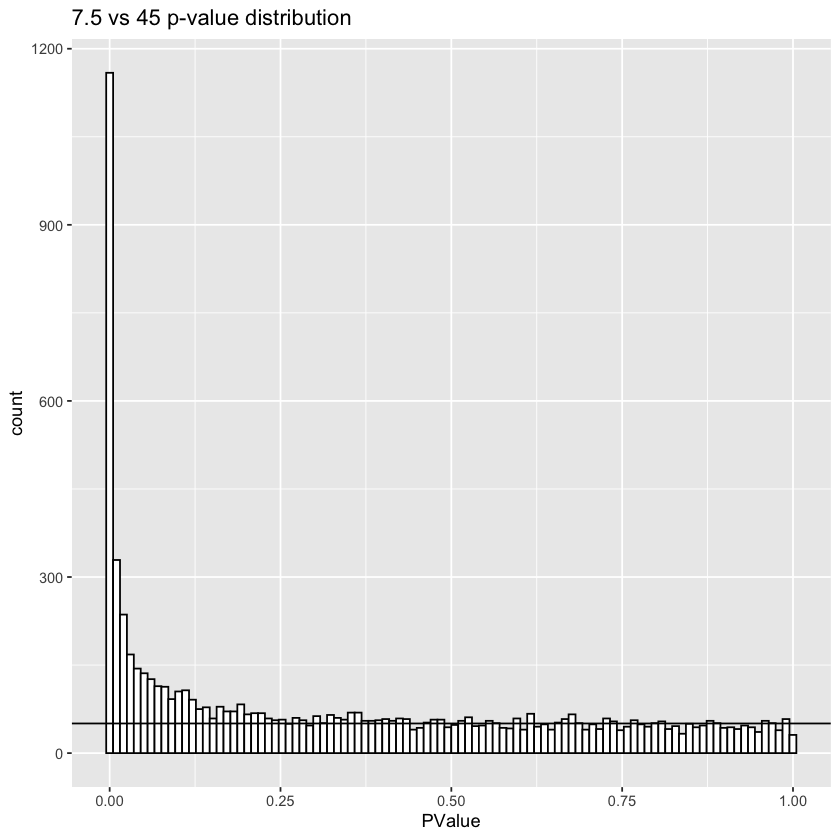

In [16]:
# the exact test object has columns like fold-change, CPM, and p-values
et <- exactTest(y, pair = c("low", "high"))

# this counts up, down, and unchanged genes (proteins) at 10% FDR
summary(decideTestsDGE(et, p.value = 0.10))

# the topTags function adds the BH FDR values to an exactTest data frame 
# make sure we do not change the row order (the sort.by parameter)!
topTags(et)$table
tt <- topTags(et, n = Inf, sort.by = "none")

# make an MD plot (like MA plot)
plotMD(et, p.value = 0.10)
abline(h = c(-1, 1), col = "black") # 2-fold change lines

# check the p-value distribution
ggplot(tt$table, aes(PValue)) + 
  geom_histogram(bins = 100, fill = "white", color = "black") + 
  geom_hline(yintercept = mean(hist(et$table$PValue, breaks = 100, 
                                    plot = FALSE)$counts[26:100])) +
  ggtitle("7.5 vs 45 p-value distribution")

### We have gone off of the rails

We have 1,644 DE candidates from the unchanged human background proteins! That is almost 22% of the proteins. We have done a high-quality normalization. We have a testing using a moderated test statistic. We have done multiple testing corrections. 

Here is my **theory**: I think there is a low-level background of previously sampled peptides that is coming off of the column. Kind of a "ghost of Christmas past" situation. A precursor might have 3 to 4 very narrow isotopic peaks. The isolation quadrupole might be 2 Da on older instruments and maybe 0.7 Da on newer platforms. That is 2000 milliDa to 700 milliDa of width with a few peaks that may be 10 milliDa at the base. Low levels of background signal can be integrated over a very wide range compared to the widths of the precursor peaks. 

Distortions in isobaric labeling reagent tags acquired in MS2 scans has been known for years and documented in many published papers. When high resolution instruments became the norm, it was easier to look for any other co-isolated precursors based on what fraction of the isolated peaks were mapped to the precursor of interest. These precursor purity filters looked great in theory; however, they did not fix the reporter ion distortions. Along the same lines, larger-scale peptide separations should reduce the chance of co-eluting peptides compared to less separation. That also failed to improve the ratio compression problem.

> Keep in mind that we have a very large separation scheme for this data. It is something like 72 fractions. The PAW pipeline does not have any way to check for precursor purity (it does not use any information from survey scans). 

I think the only explanation left is the non-specific background effect. I wrote a blog about how that explains ratio compression (https://pwilmart.github.io/blog/2020/01/05/TMT-ratio-distortions). This spike-in experiment actually provides an excellent test of my theory. We have a similar human background proteome for all channels. If we get some other human proteins in the non-specific noise, they will not change the expression pattern of the human protein of interest. However, any E. coli proteins that sneak through into the non-specific background do not have an expression pattern like the human background. That is the whole point, right? We have a small amount of E. coli in the first 3 channels and 6 times as much E. coli in the last three channels. Any contribution to the reporter ions from any E. coli proteins will boost the signal for the human protein in the last three channels. For the 45 microgram E. coli spike-in, the E. coli is about 61% of the total protein. We have over 2,000 E. coli proteins out of the 9,500 total proteins (about half of the proteome in both cases). 

It is likely we have some boost in the last three channels for many of the human proteins due to some "ghosts of E. coli peptides past". How will this manifest itself? What sneaks through in the background will probably depend on the m/z and the retention time. Not all human proteins in the 45 microgram E. coli spike-in will be boosted. Some will and some won't. Our normalization methods typically assume most proteins do not change and try to make that non-differentially expressed background more similar between samples. These proteome spike-in experiments are not very compatible with that logic because the spike-in can only go in one direction. The differences are just how much all of the spike-in proteins are over expressed.

If we have some bleed through of E. coli peptides and have some human peptides get some partial reporter ion intensity boosts, then the total signal of the human proteins (our background here) for the 45 microgram E. coli spike-in will be larger than it really should have been. This will alter the single global scaling factor. The human proteins in the 45 microgram E. coli spike-in have some boosted and some not boosted. The global normalization factor will end up splitting the difference. The boosted proteins will still be larger than they should have been. The true background level would not have been estimated correctly and the non-boosted proteins will not be fully brought up to the proper background levels. Some of the non-changed human proteins in the 45 microgram E. coli spike-in will end up with lower intensities that they should have been after this split-the-difference scaling.

I think that effect is pretty obvious in the MA plot above. All of the blue proteins (reduced expression) should be black and a mirror group of red proteins should also be unchanged (black). The more heavily over-expressed (red) proteins are the human proteins that had more E. coli boost.

We have a **double whammy effect** going on. Individual protein expression levels can be altered by the ghost background. In most experiments, we do not have anything like we have here with the high spike-in of E. coli. The background proteins are more likely to be "flat" (not differentially expressed), and this biases expression ratios to the mean expression (larger fold-changes become smaller). The other effect is the collective distortion of the unchanged background levels of the non-differentially expressed proteins. That can mess with the normalization methods and create issues for the statistical testing. Most statistical testing assumes that data are normalized correctly such that unchanged proteins would have similar means between conditions. We can get large numbers of false positive and false negative test results when we have unintentionally poorly normalized data. 


## Compute averages, flag candidates, and save the pair-wise test results

We will add the statistical testing results (logFC, p-values, and FDR), condition intensity averages, and candidate status to the `results` data frame (which has the TMM-normalized data) and also accumulate all of the three comparisons into `all_results`.

In [17]:
# get the results summary
results <- collect_results(tmt_tmm, tt$table, low, "low", high, "high")
results$species <- as.factor(species)

# make column names unique by adding comparison
results_temp  <- results
colnames(results_temp) <- str_c(colnames(results), "_low_high")

# accumulate the testing results
all_results <- cbind(all_results, results_temp)

### Count candidates and look at fold-change distributions

candidate n   
1 high       817
2 med        483
3 low        344
4 no        5915

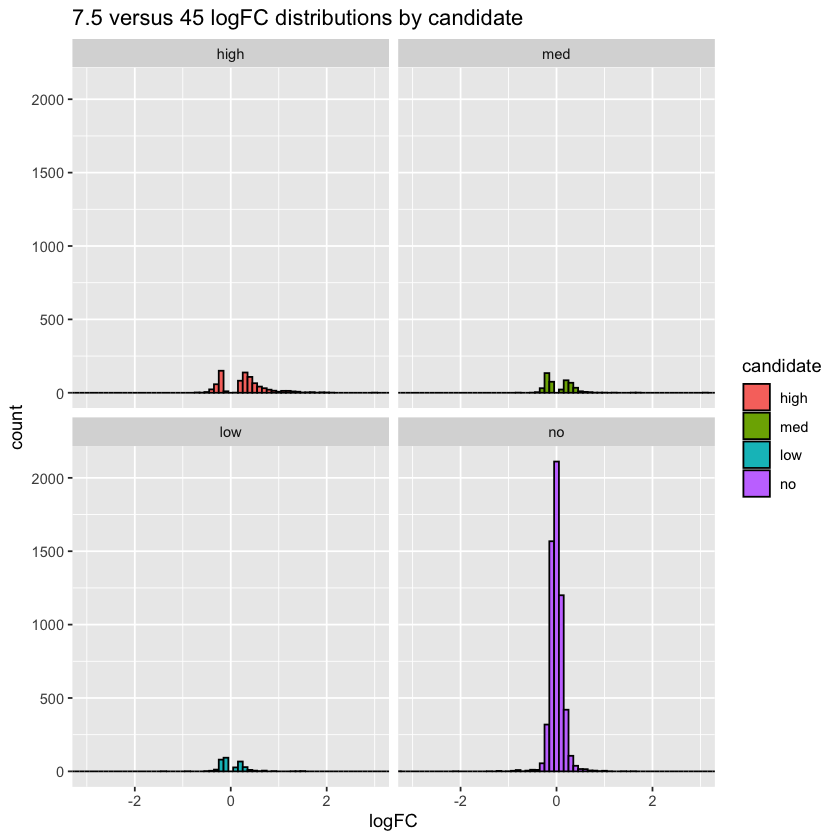

In [18]:
# see how many candidates by category
results %>% count(candidate)

# plot log2 fold-changes by category
ggplot(results, aes(x = logFC, fill = candidate)) +
  geom_histogram(binwidth=0.1, color = "black") +
  facet_wrap(~candidate) +
  coord_cartesian(xlim = c(-3, 3)) +
  ggtitle("7.5 versus 45 logFC distributions by candidate")

### MA plots

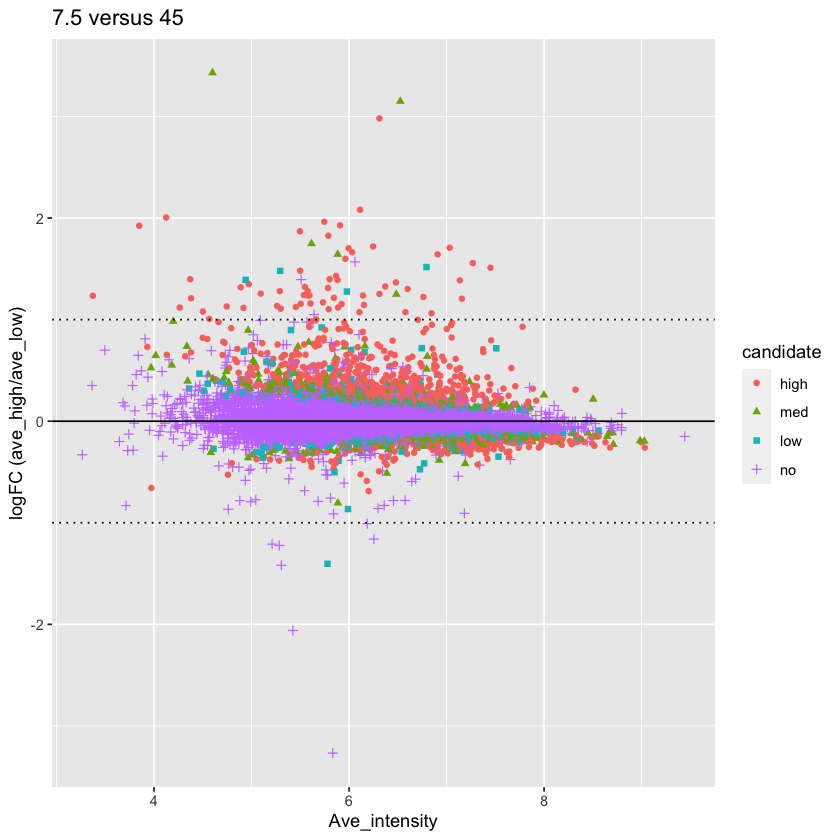

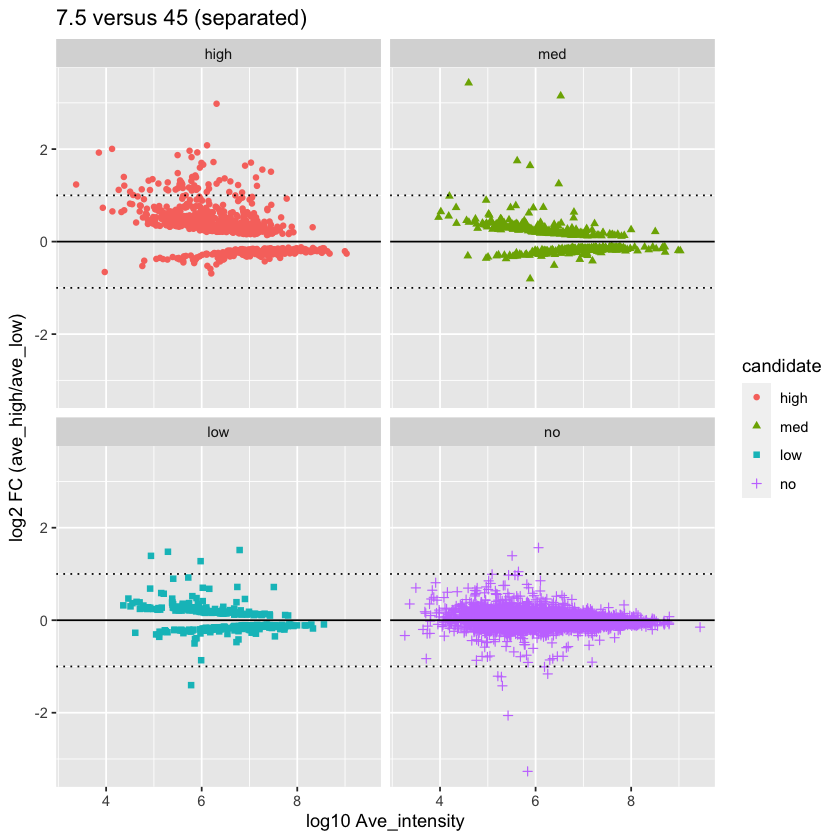

In [19]:
# make MA plots
MA_plots(results, "ave_low", "ave_high", "7.5 versus 45")

### Scatter plots

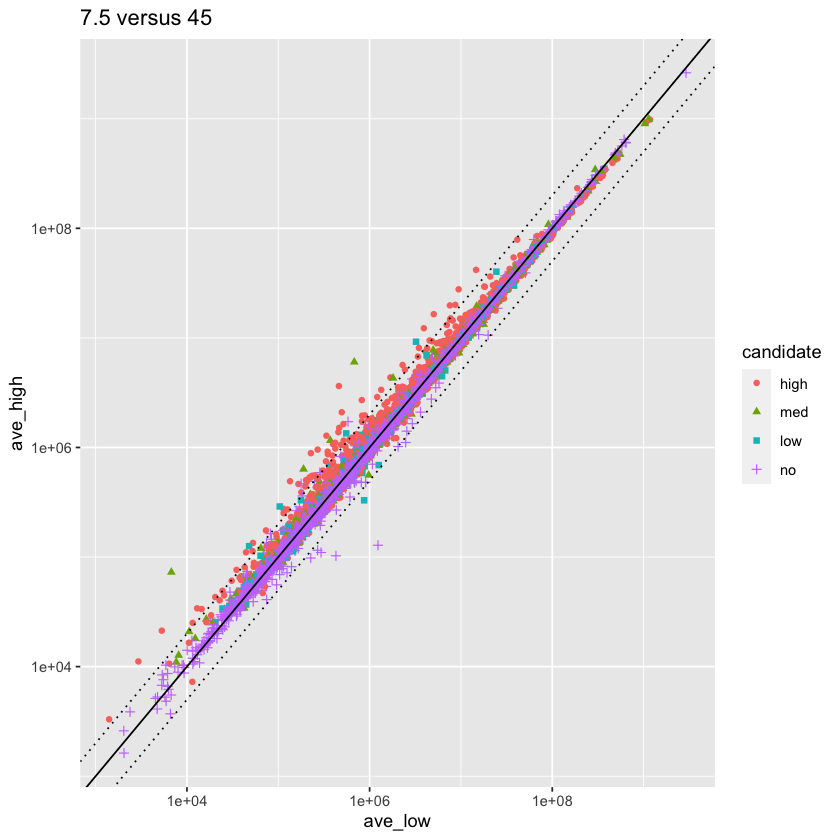

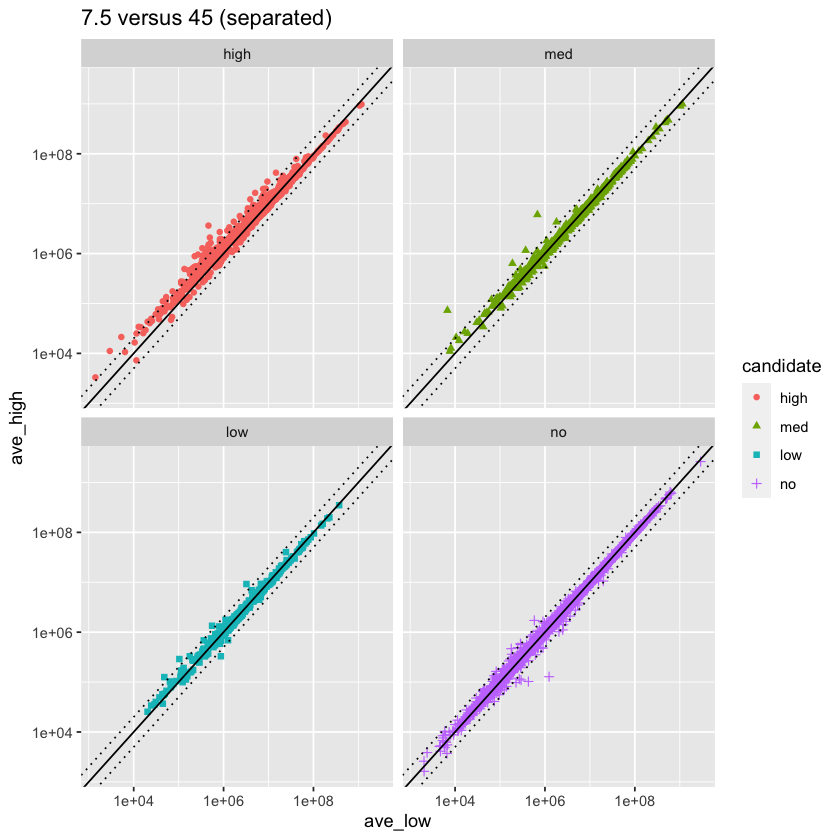

In [20]:
# make scatter plots
scatter_plots(results,  "ave_low", "ave_high", "7.5 versus 45")

### Volcano plot

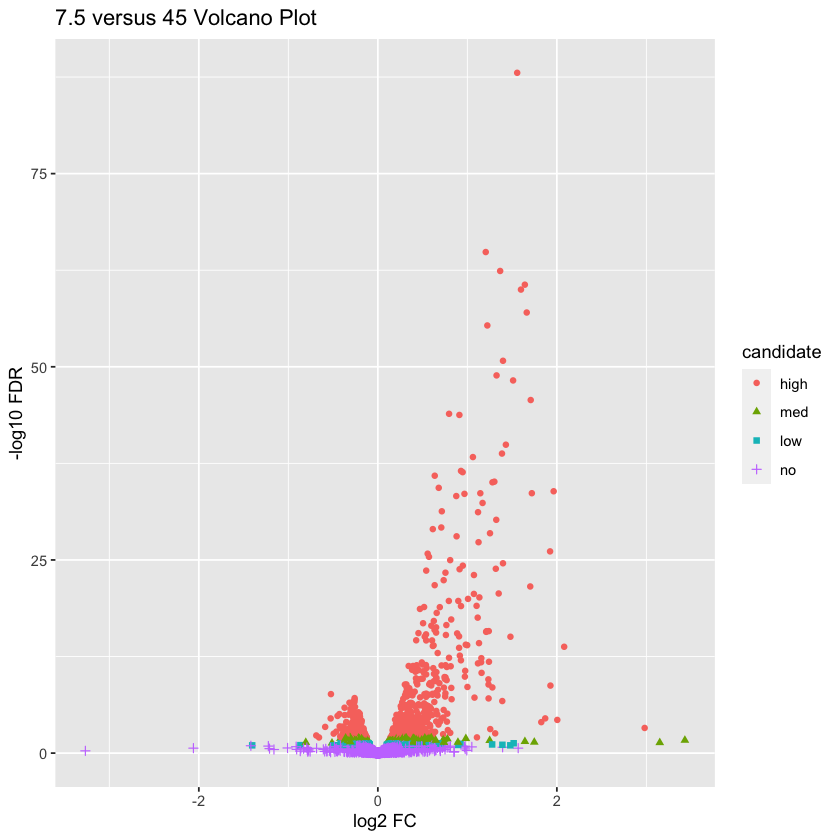

In [21]:
# make a volcano plot
volcano_plot(results,  "ave_low", "ave_high", "7.5 versus 45")

### Some candidates have larger fold-changes

We seem to have many human proteins that have some larger fold changes.

### Check some individual protein expression

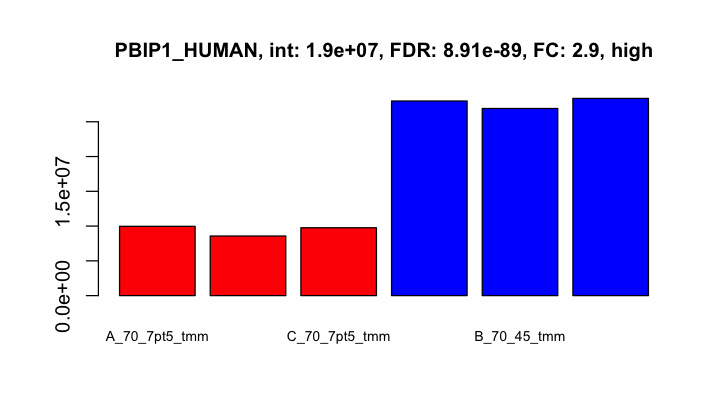

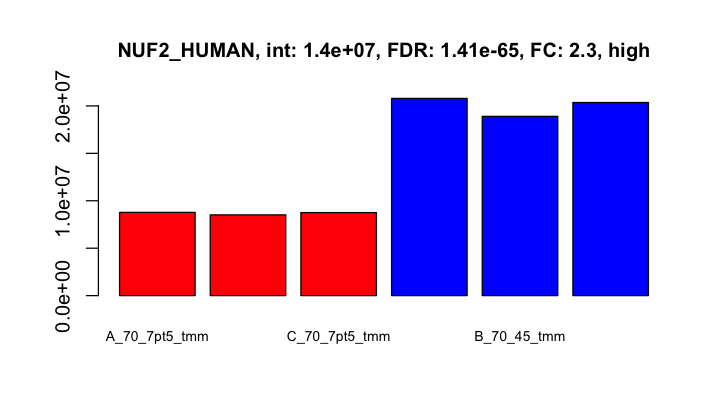

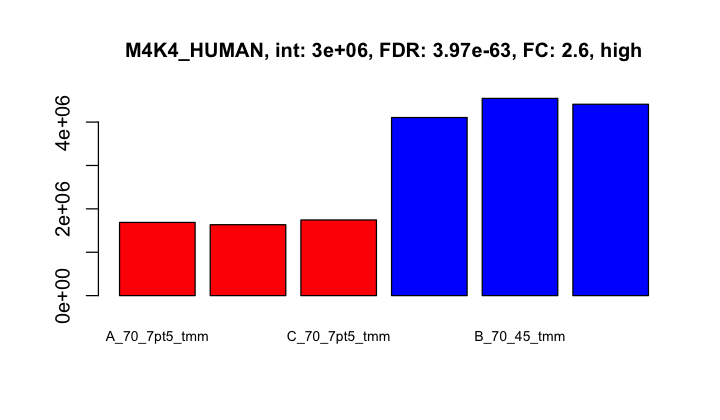

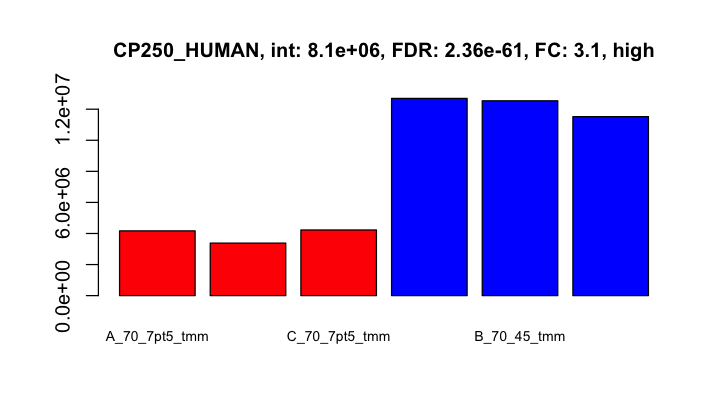

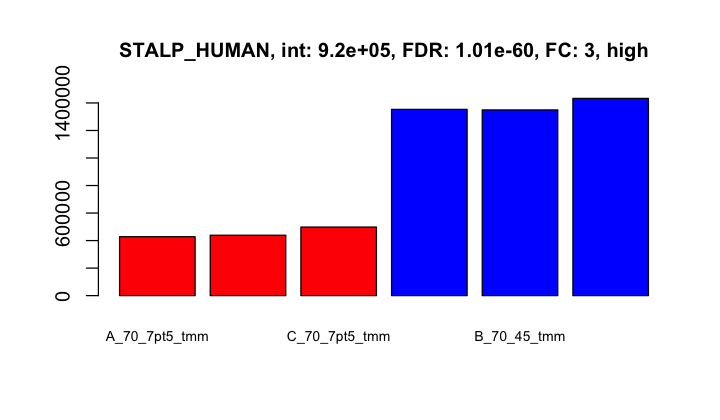

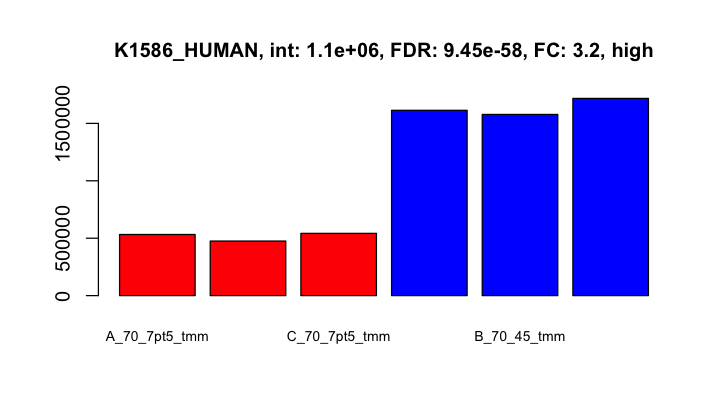

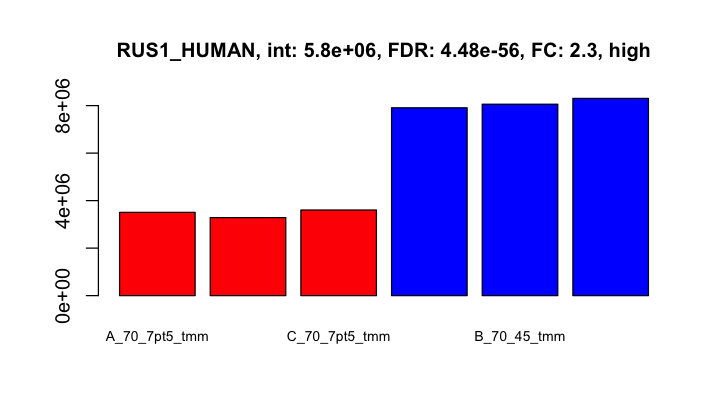

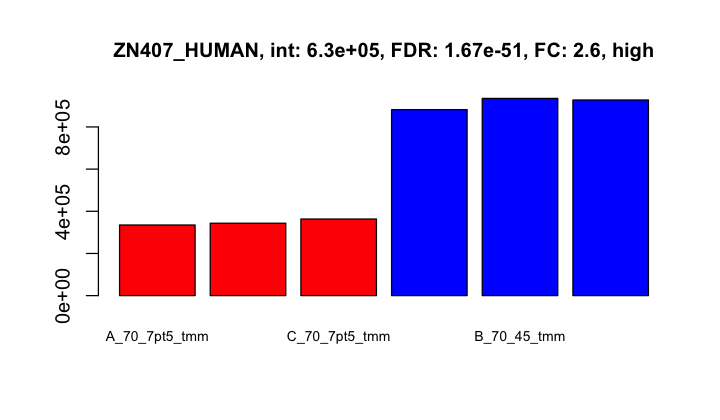

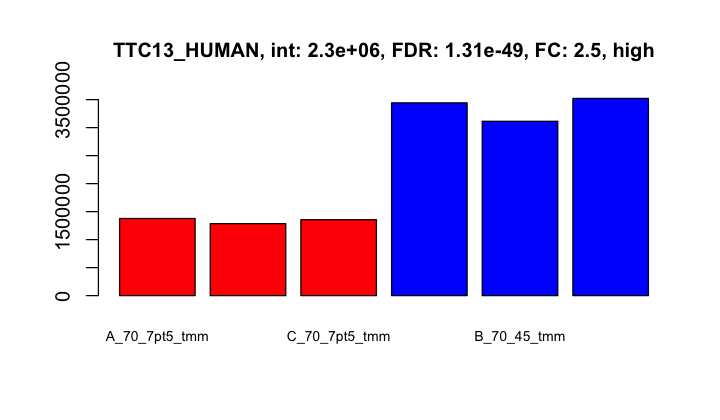

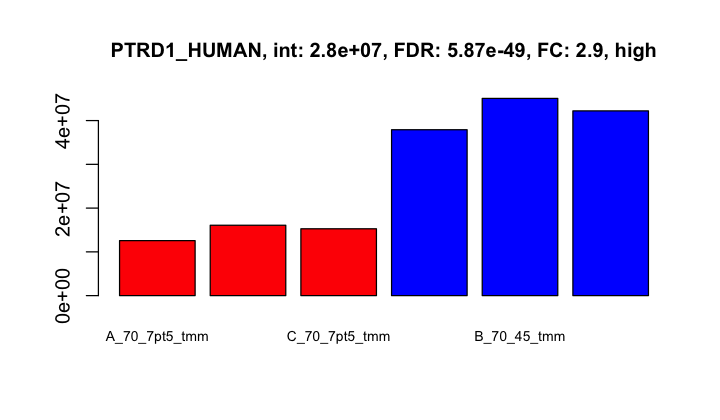

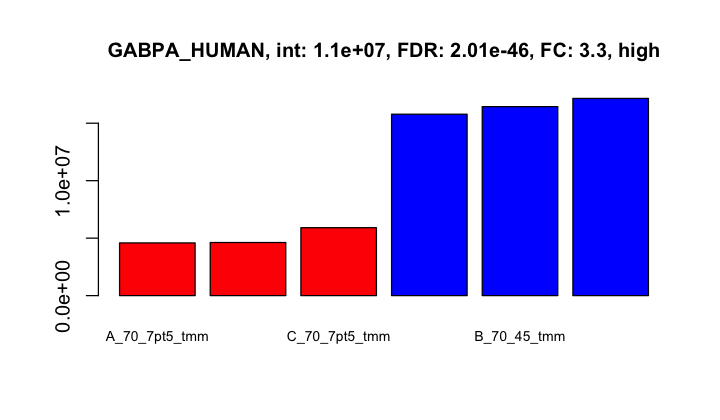

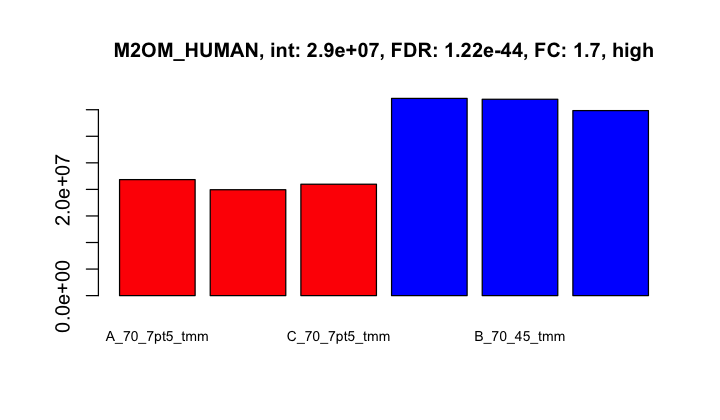

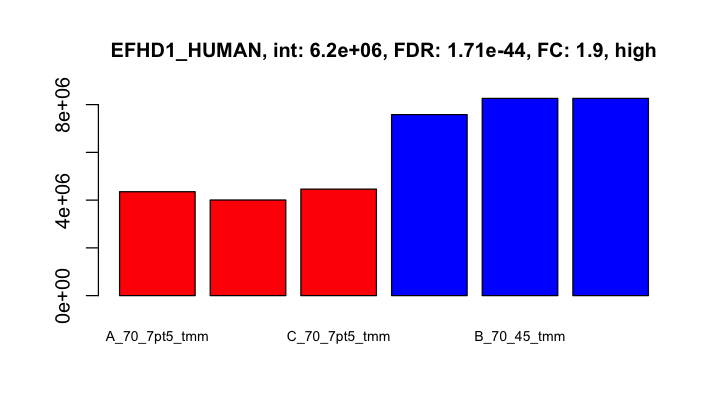

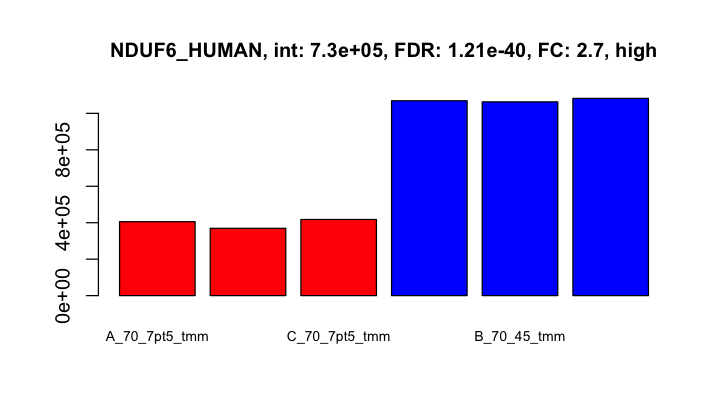

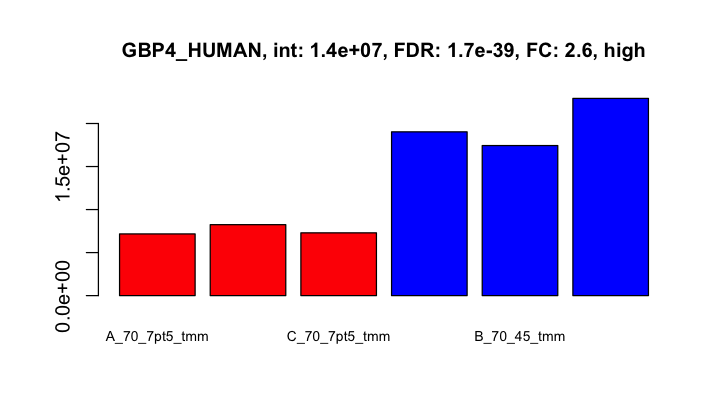

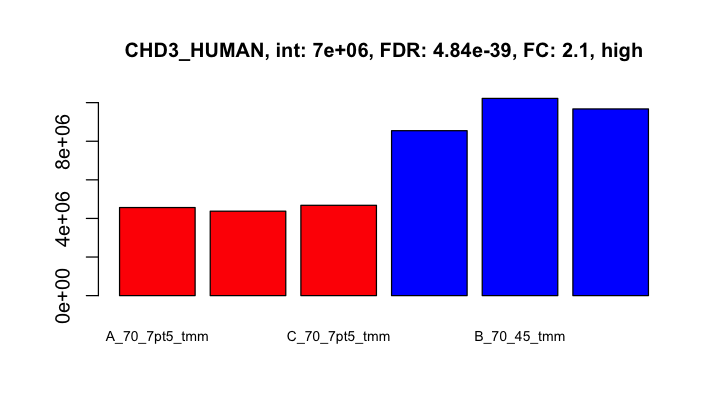

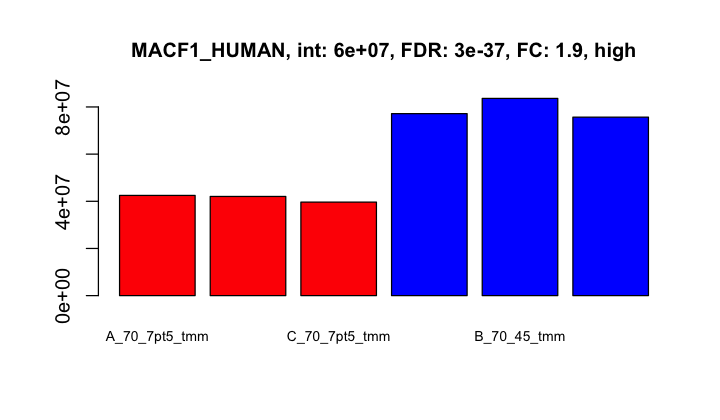

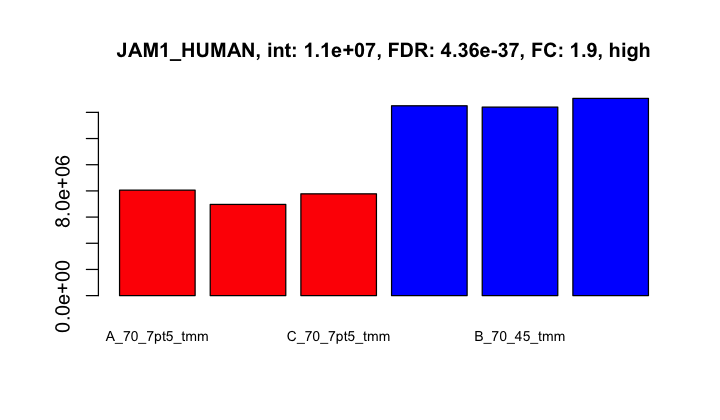

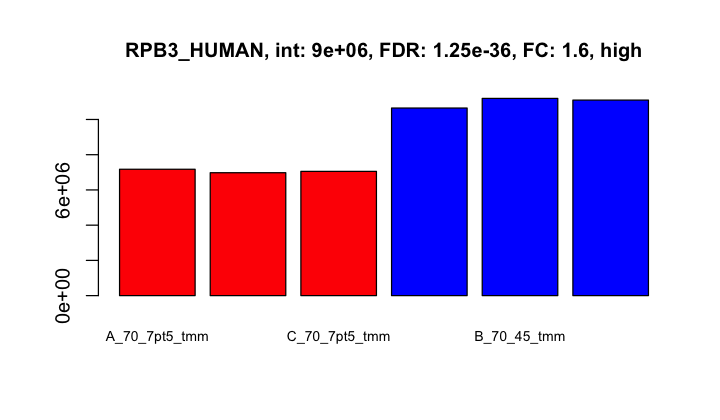

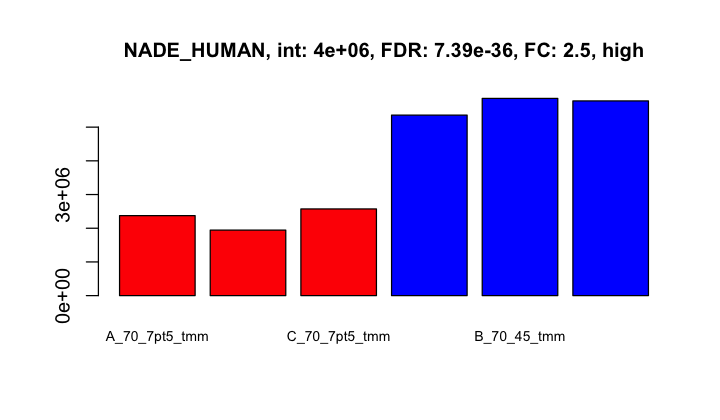

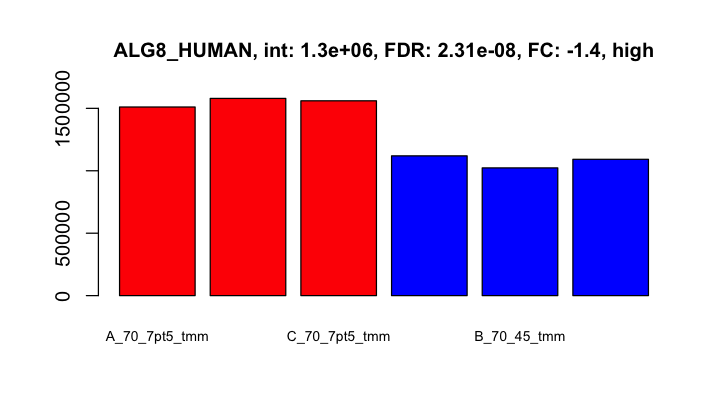

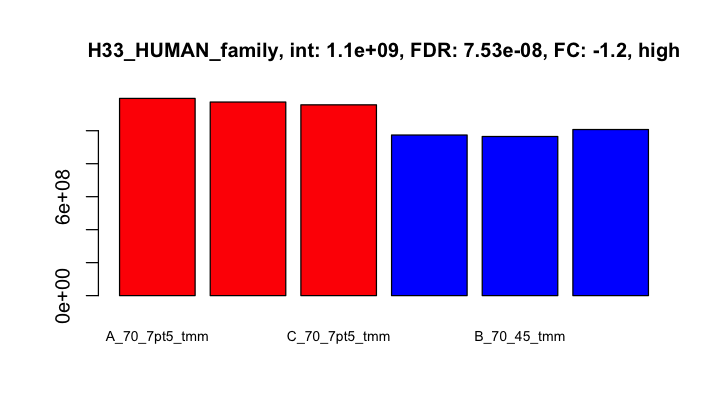

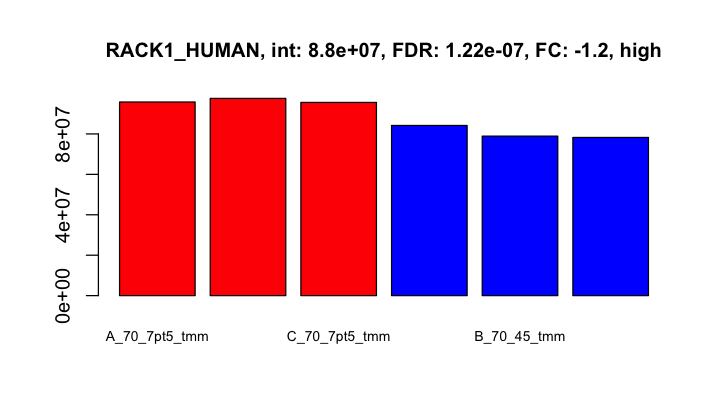

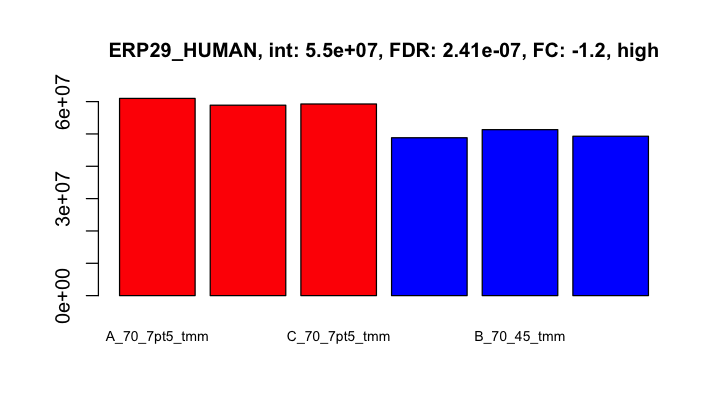

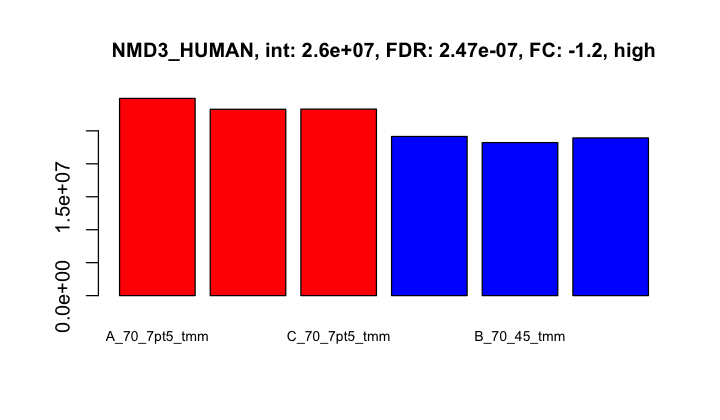

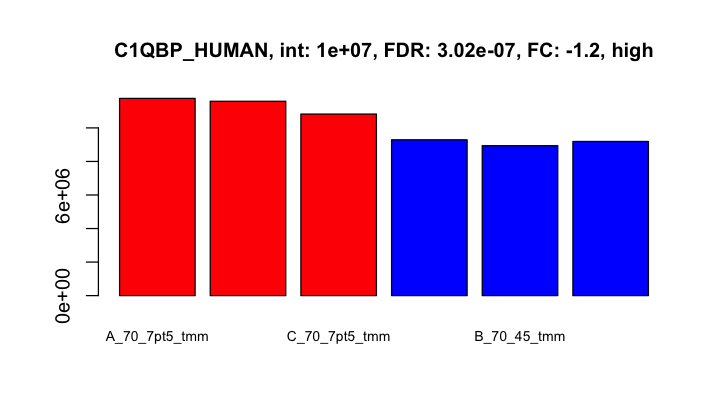

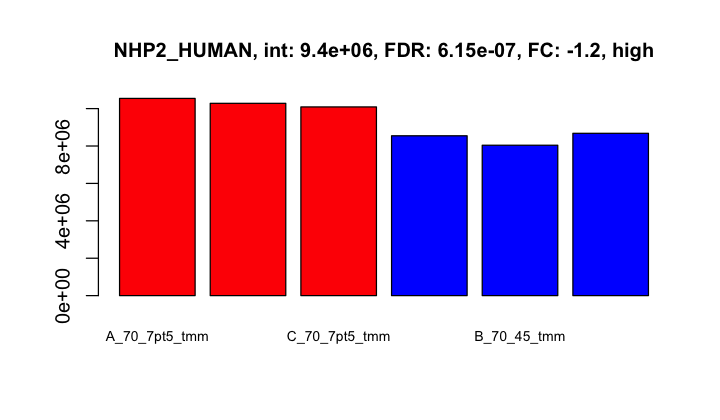

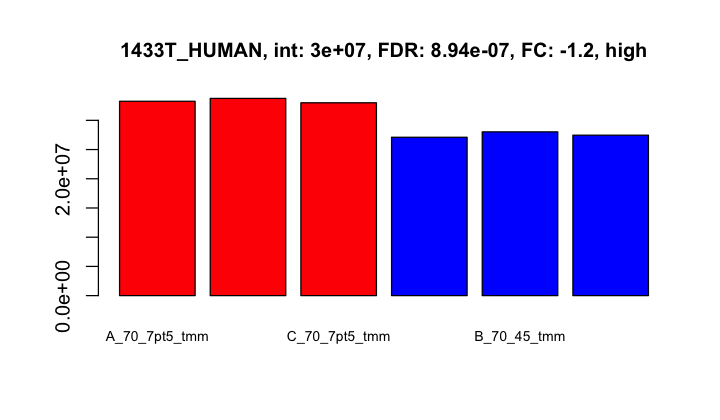

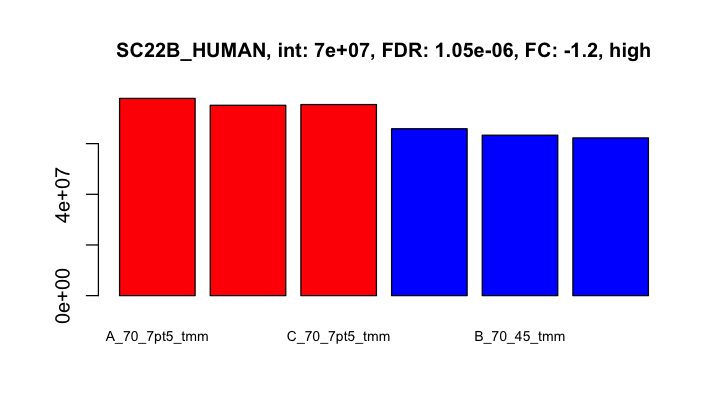

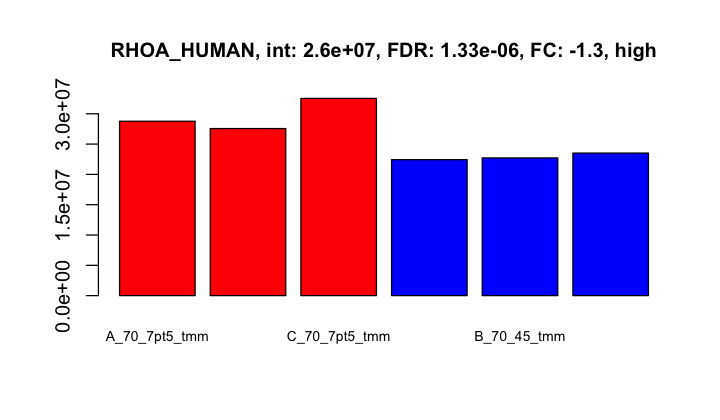

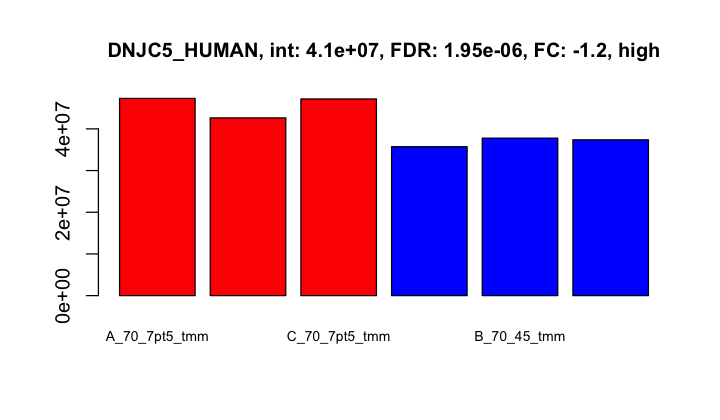

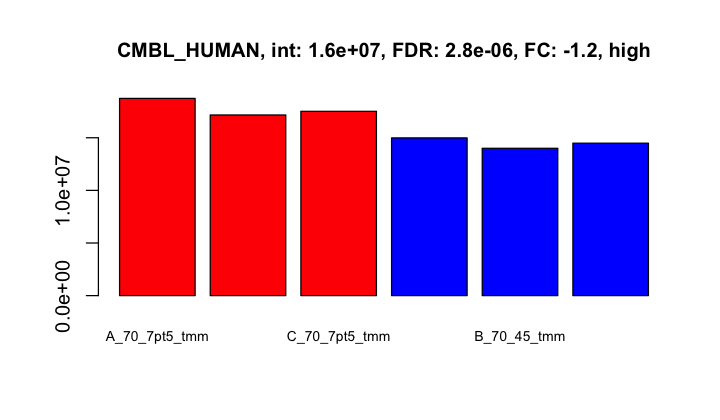

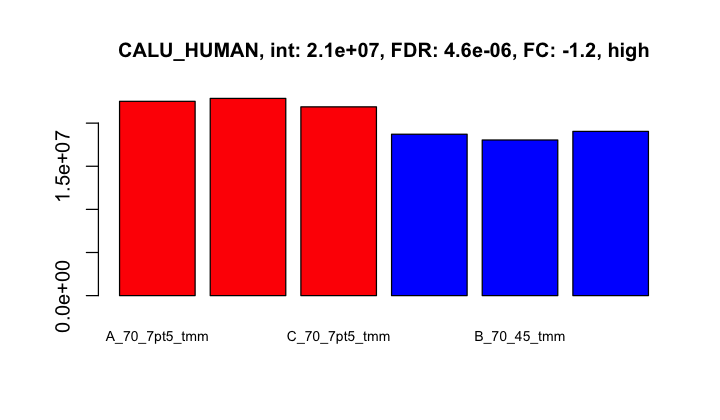

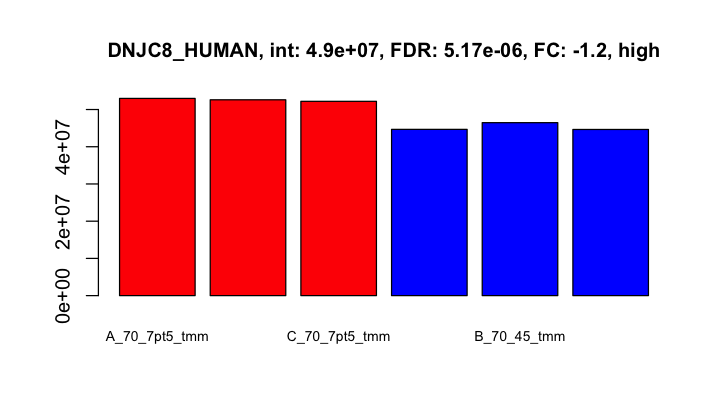

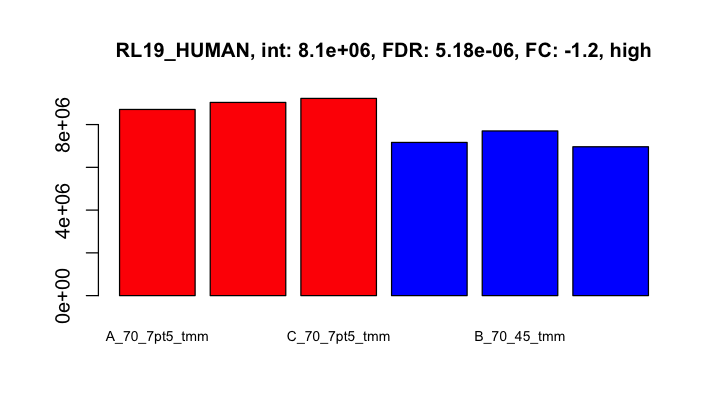

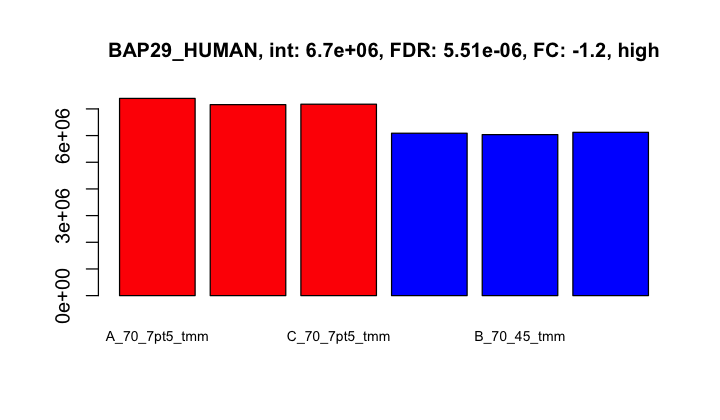

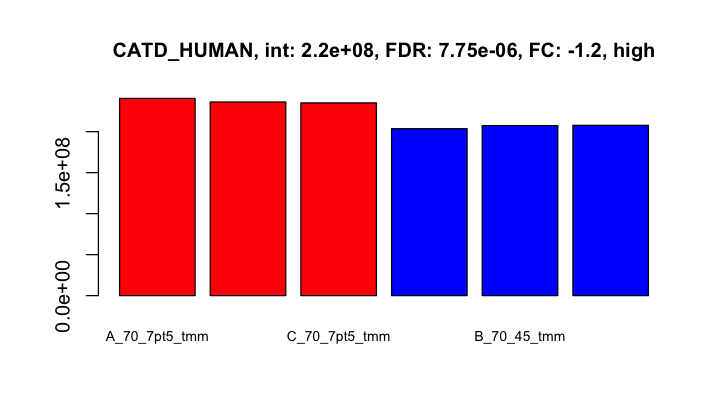

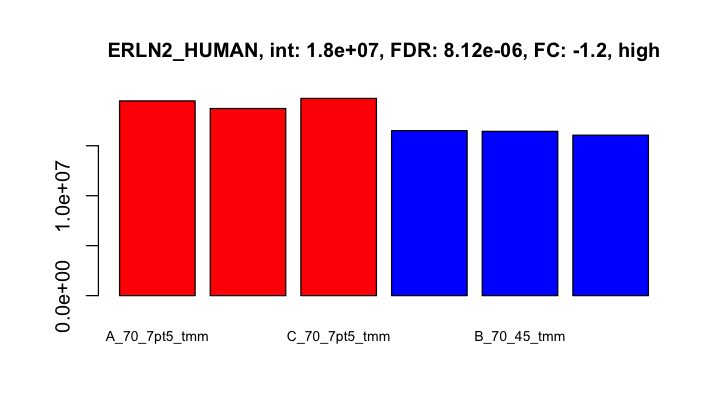

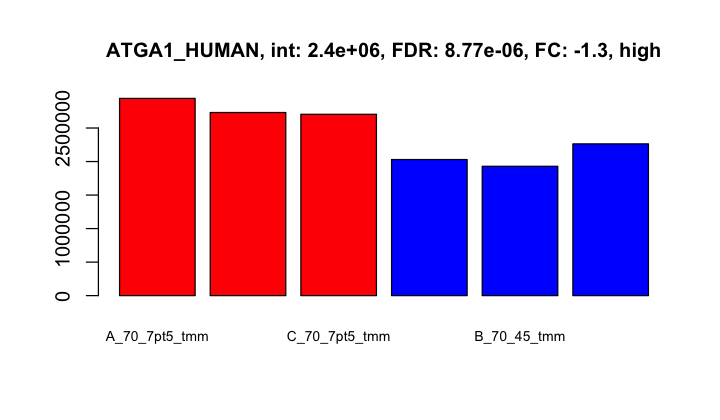

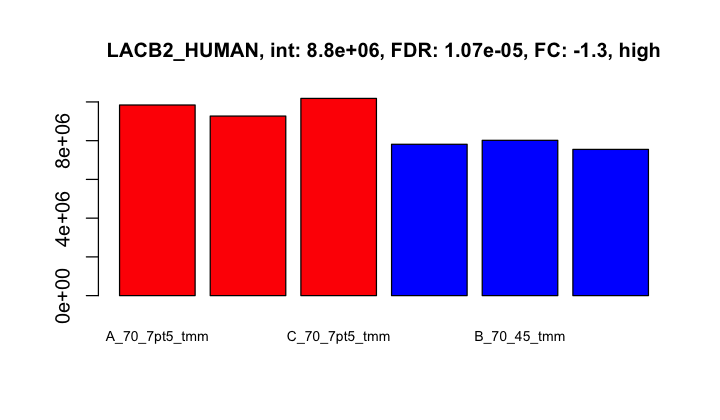

In [22]:
# look at the top candidates
set_plot_dimensions(6, 3.5)
plot_top_tags(results, 3, 3, 20)
set_plot_dimensions(7, 7)

### Candidates seem pretty plausible

There seems to be some actual differences in the levels of the human proteins between the relative small spike in load of 7.5 microgram E. coli and the larger 45 microgram E. coli spike in. I suspect the top over-expression candidates are the human proteins with the most E. coli background. The down expression proteins are probably because of the normalization effects.

----

## <a name="15_45"></a> (3) 15 versus 45

Compare the 15 microgram to the 45 microgram E. coli spike in samples.

       high-med
Down        245
NotSig     6690
Up          624

genes                 logFC     logCPM   PValue       FDR         
904  sp|Q96AQ6|PBIP1_HUMAN 0.9613820 7.676296 7.389998e-44 5.586100e-40
2991 sp|O95819|M4K4_HUMAN  0.9319079 5.047739 5.896858e-38 2.228717e-34
1112 sp|Q9BZD4|NUF2_HUMAN  0.7975157 7.325299 6.077318e-37 1.531282e-33
2106 sp|Q96GQ5|RUS1_HUMAN  0.8369567 6.001082 8.537024e-34 1.613284e-30
1726 sp|Q9BV73|CP250_HUMAN 1.0354194 6.457896 3.188583e-32 4.820500e-29
4549 sp|Q9HCI6|K1586_HUMAN 1.0513420 3.545009 1.454365e-30 1.679066e-27
4769 sp|Q96FJ0|STALP_HUMAN 0.9866700 3.329474 1.554896e-30 1.679066e-27
5275 sp|Q9C0G0|ZN407_HUMAN 0.9298861 2.792264 8.240914e-30 7.786634e-27
599  sp|Q02978|M2OM_HUMAN  0.5742206 8.351918 1.250991e-29 1.050694e-26
3342 sp|Q8NBP0|TTC13_HUMAN 0.8838723 4.697288 8.708840e-29 6.583012e-26

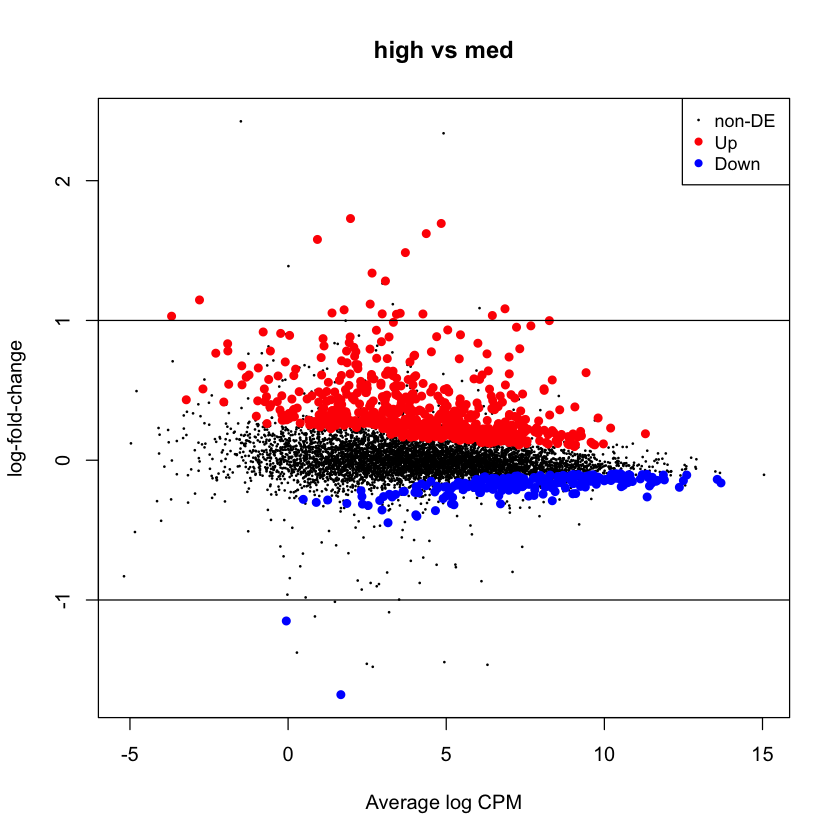

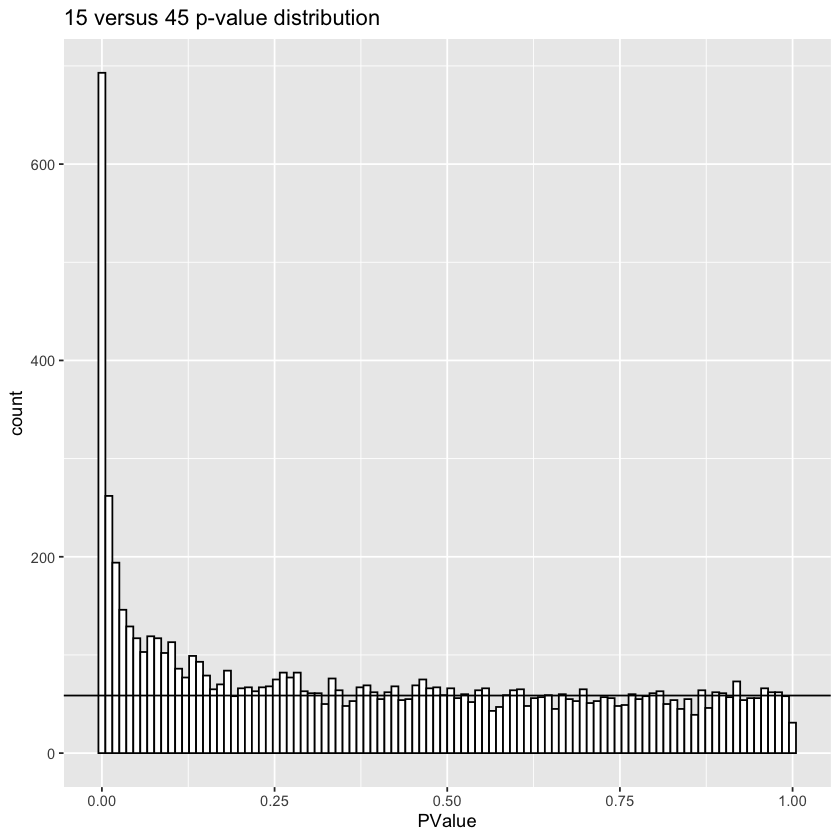

In [23]:
# the exact test object has columns like fold-change, CPM, and p-values
et <- exactTest(y, pair = c("med", "high"))

# this counts up, down, and unchanged genes (proteins) at 10% FDR
summary(decideTestsDGE(et, p.value = 0.10))

# the topTags function adds the BH FDR values to an exactTest data frame 
# make sure we do not change the row order (the sort.by parameter)!
topTags(et)$table
tt <- topTags(et, n = Inf, sort.by = "none")

# make an MD plot (like MA plot)
plotMD(et, p.value = 0.10)
abline(h = c(-1, 1), col = "black")

# check the p-value distribution
ggplot(tt$table, aes(PValue)) + 
  geom_histogram(bins = 100, fill = "white", color = "black") + 
  geom_hline(yintercept = mean(hist(et$table$PValue, breaks = 100, 
                                    plot = FALSE)$counts[26:100])) +
  ggtitle("15 versus 45 p-value distribution")

### We have 869 DE candidates 

We also have a large number of candidates here. This is 15% of the proteins. When we are comparing the 15 to 45 microgram E. coli spike-ins, we seem to have something intermediate to the 7.5 versus 45 comparison. I think everything mentioned above still applies. We have some altered over-expression levels for a subset of the human proteins and we have some residual normalization artifact.  

## Compute averages, flag candidates, and save the pair-wise test results

We will add the statistical testing results (logFC, p-values, and FDR), condition intensity averages, and candidate status to the `results` data frame (which has the TMM-normalized data) and also accumulate all of the three comparisons into `all_results`.

Even though we have few candidates, we will still make the MA plot, scatter plot, and volcano plot.

In [24]:
# get the results summary
results <- collect_results(tmt_tmm, tt$table, med, "med", high, "high")
results$species <- as.factor(species)

# make column names unique by adding comparison
results_temp  <- results
colnames(results_temp) <- str_c(colnames(results), "_med_high")

# accumulate the testing results
all_results <- cbind(all_results, results_temp)

### Count candidates and look at fold-change distributions

candidate n   
1 high       386
2 med        287
3 low        196
4 no        6690

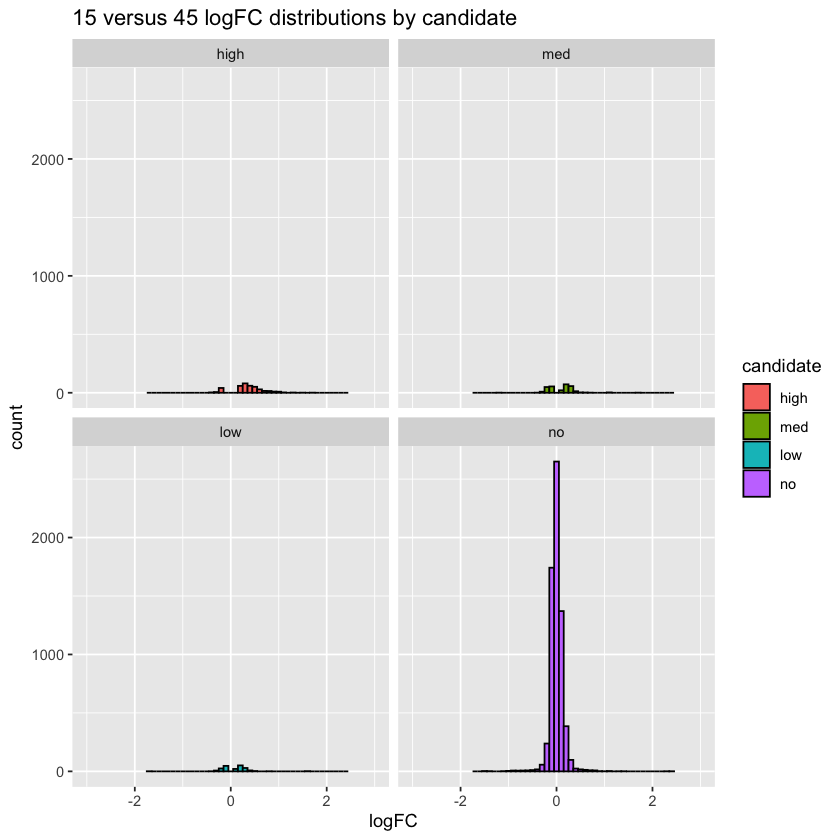

In [25]:
# see how many candidates by category
results %>% count(candidate)

# plot log2 fold-changes by category
ggplot(results, aes(x = logFC, fill = candidate)) +
  geom_histogram(binwidth=0.1, color = "black") +
  facet_wrap(~candidate) +
  coord_cartesian(xlim = c(-3, 3)) +
  ggtitle("15 versus 45 logFC distributions by candidate")

### MA plots

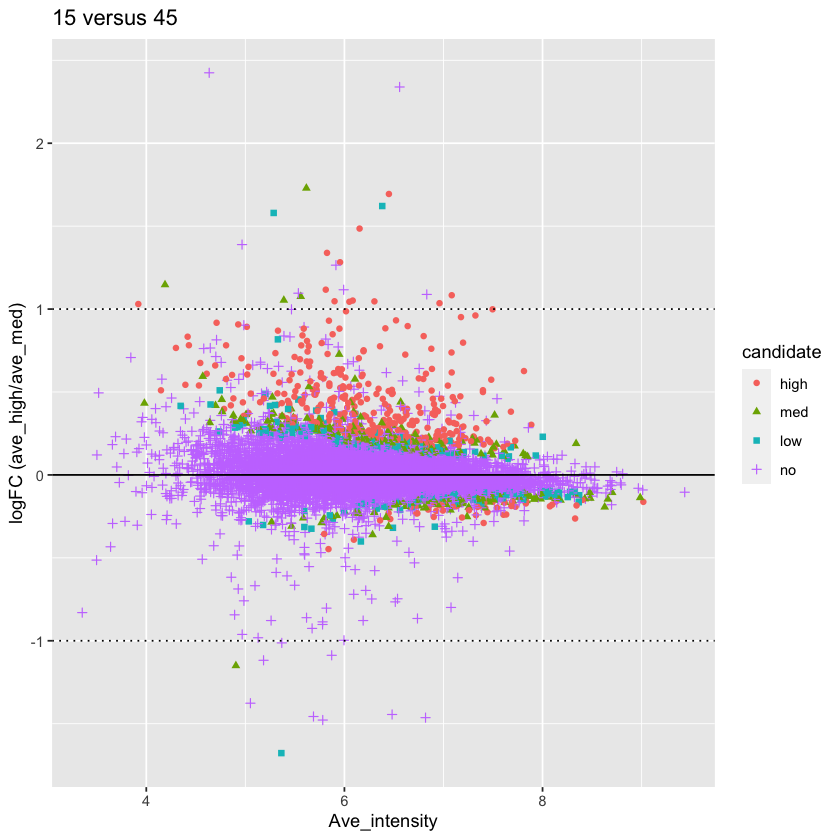

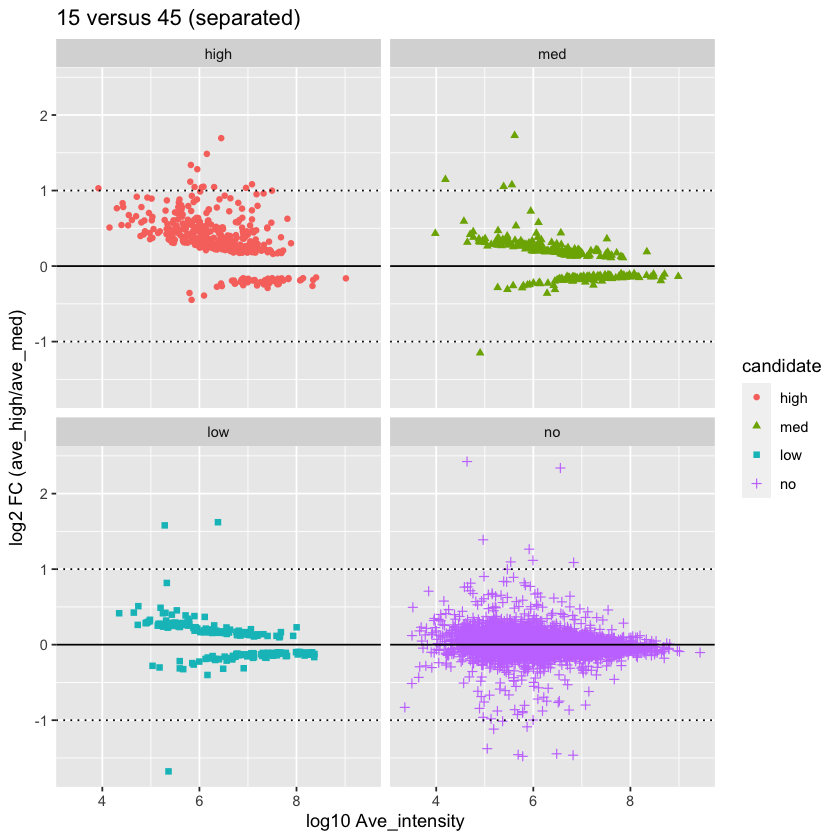

In [26]:
# make MA plots
MA_plots(results, "ave_med", "ave_high", "15 versus 45")

### Scatter plots

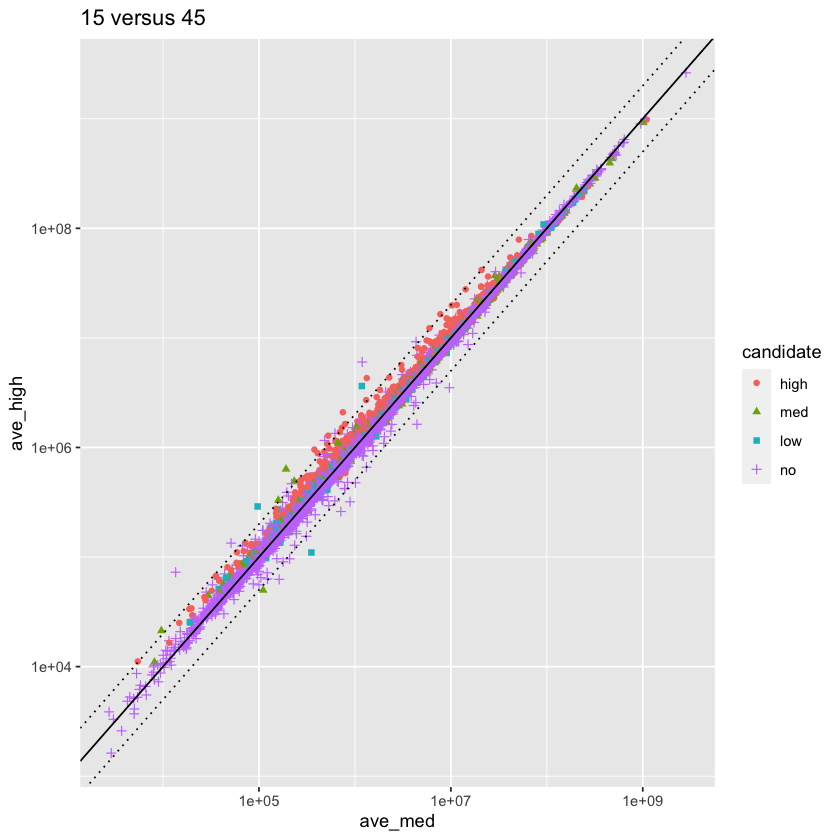

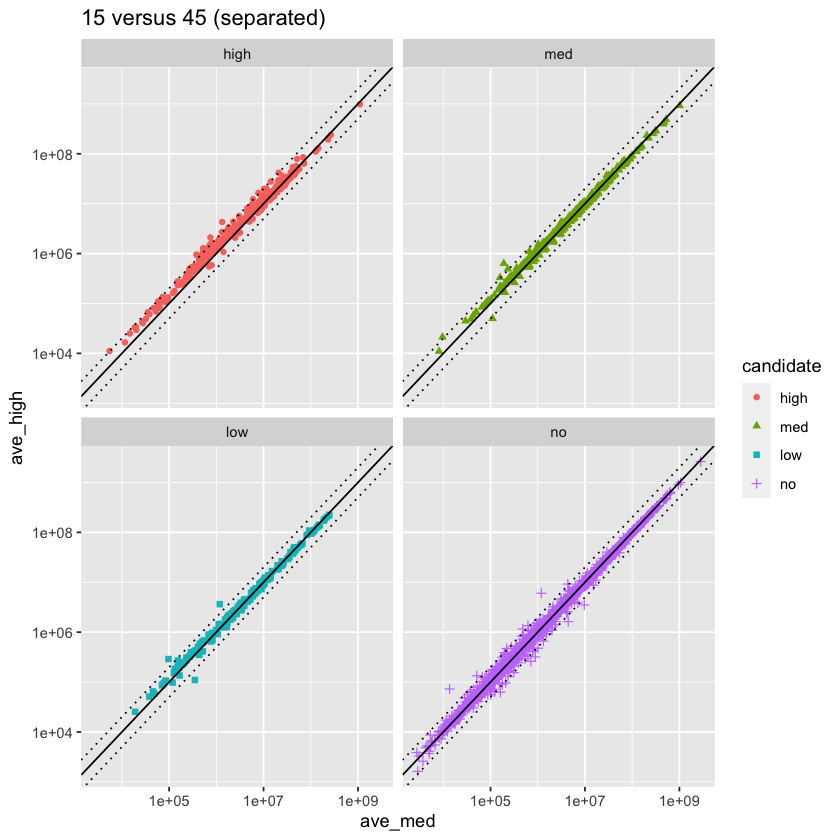

In [27]:
# make scatter plots
scatter_plots(results, "ave_med", "ave_high", "15 versus 45")

### Volcano plot

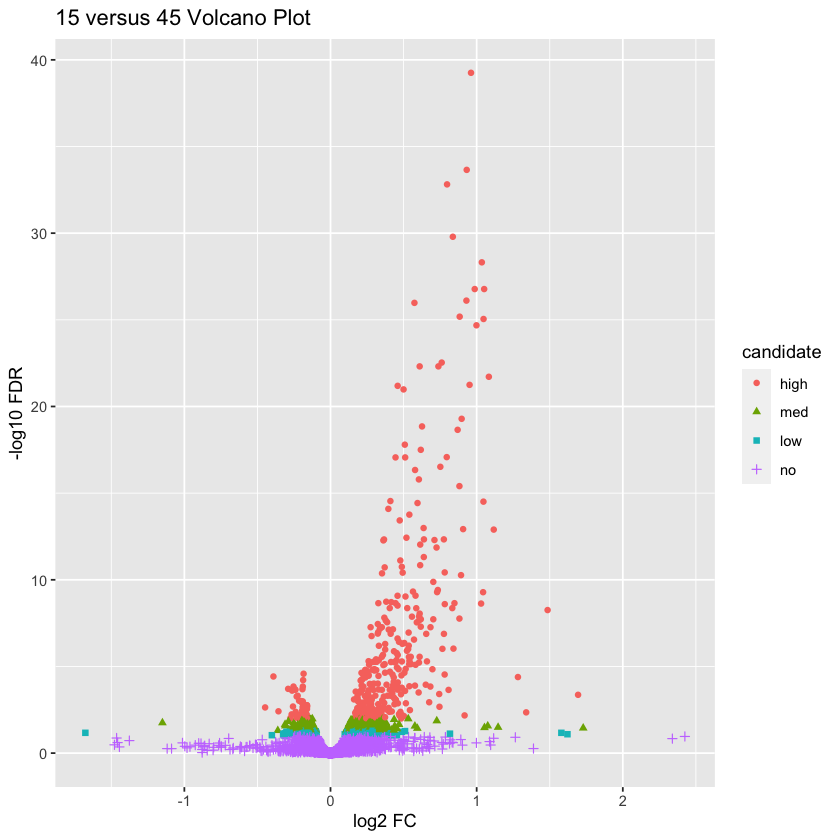

In [28]:
# make a volcano plot
volcano_plot(results, "ave_med", "ave_high", "15 versus 45")

### Reduced number of candidates, but still some more moderate fold changes

### Check individual protein expression

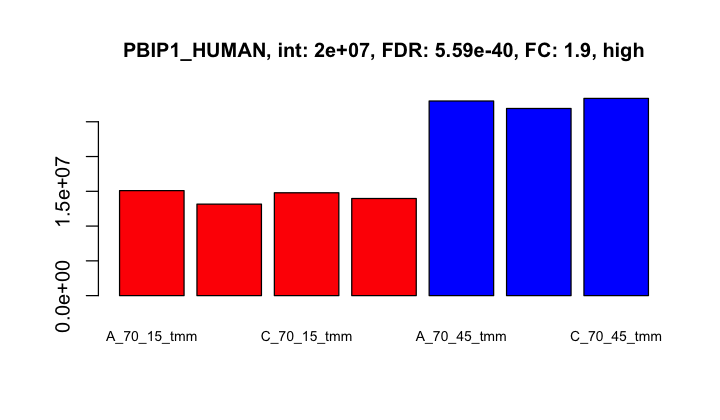

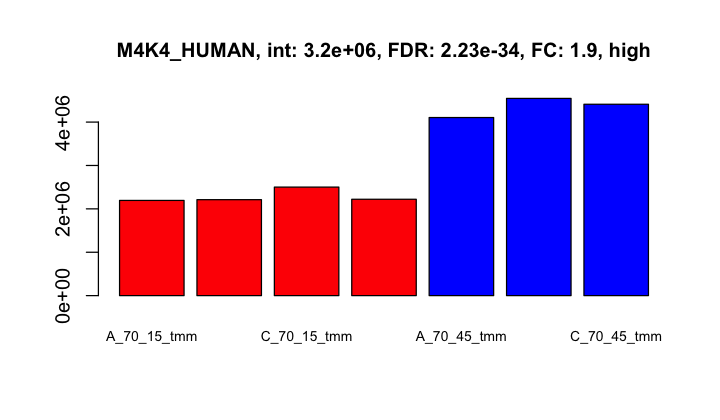

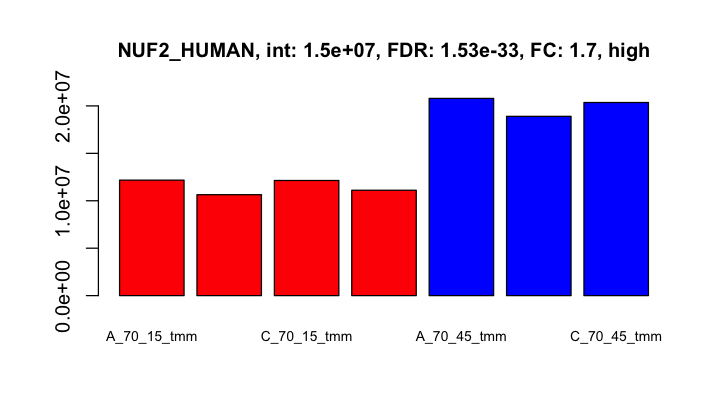

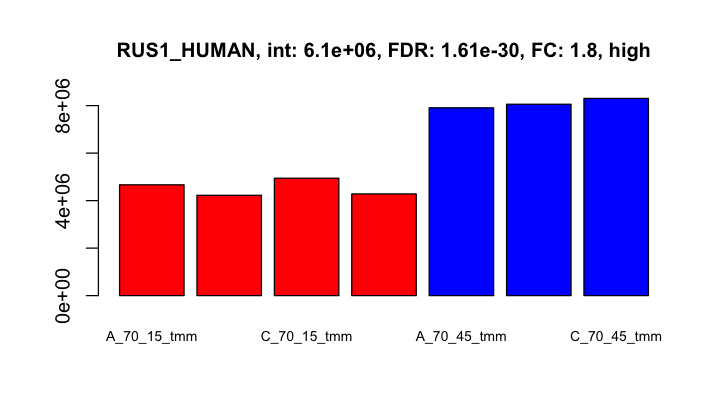

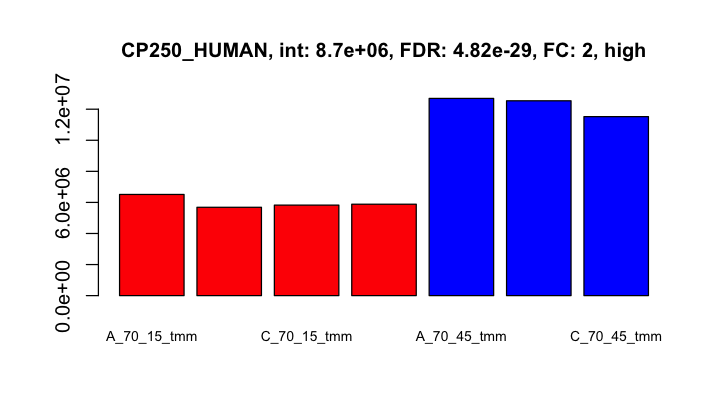

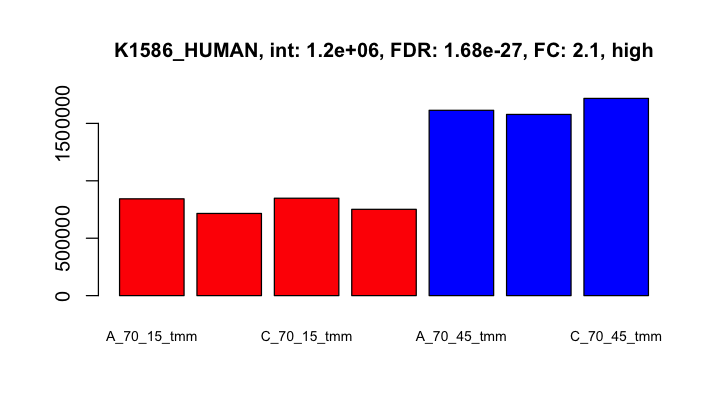

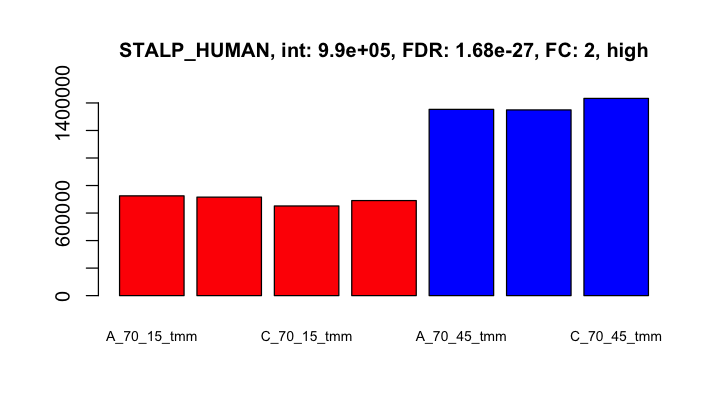

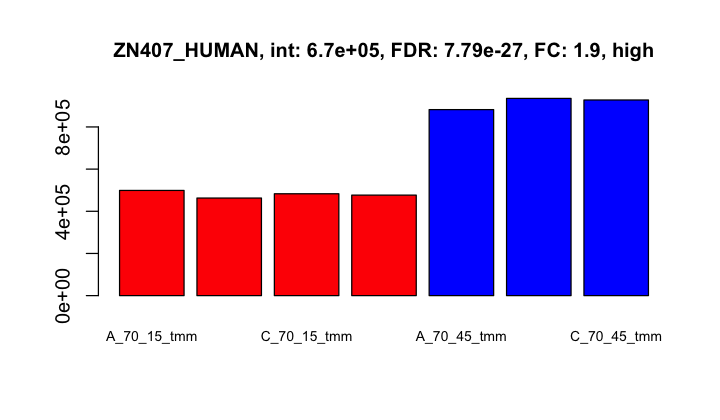

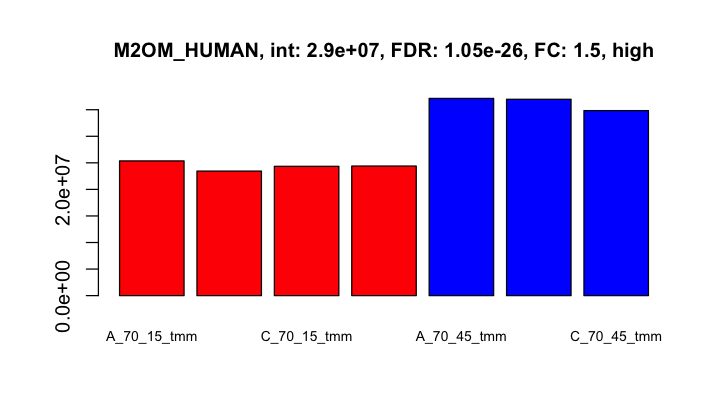

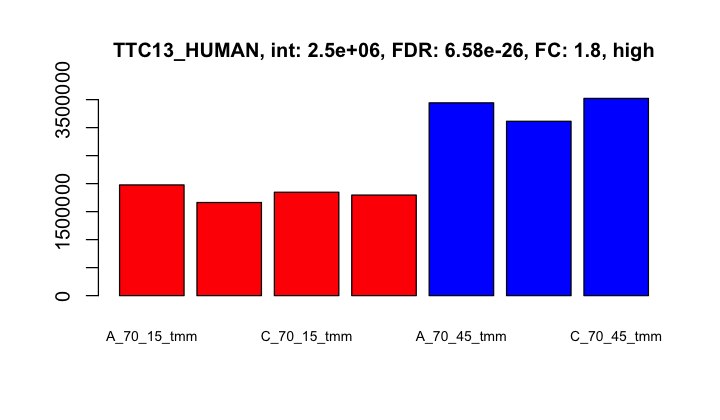

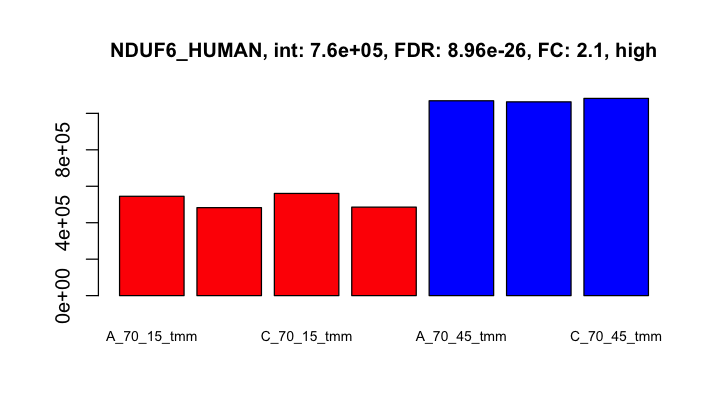

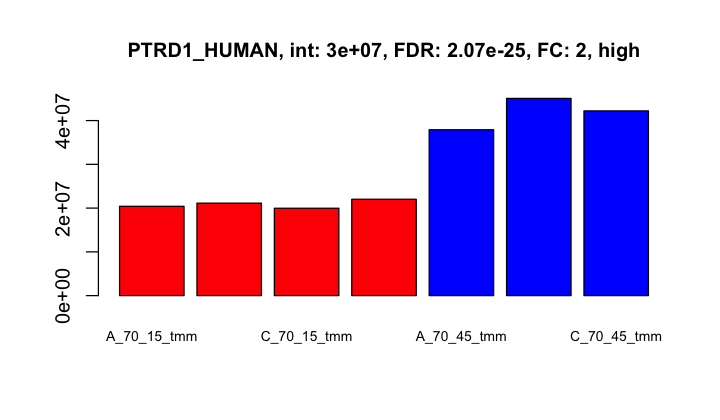

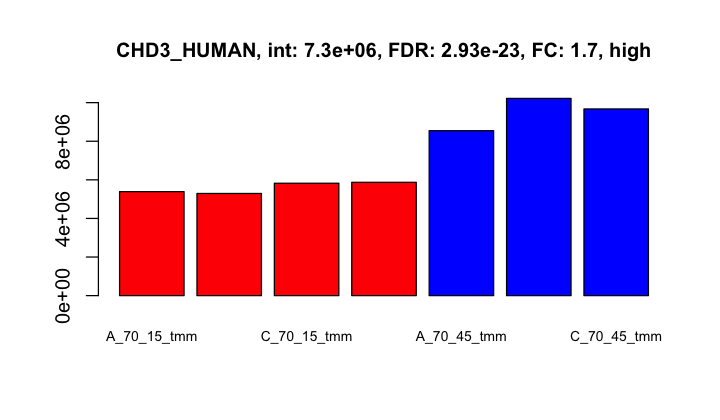

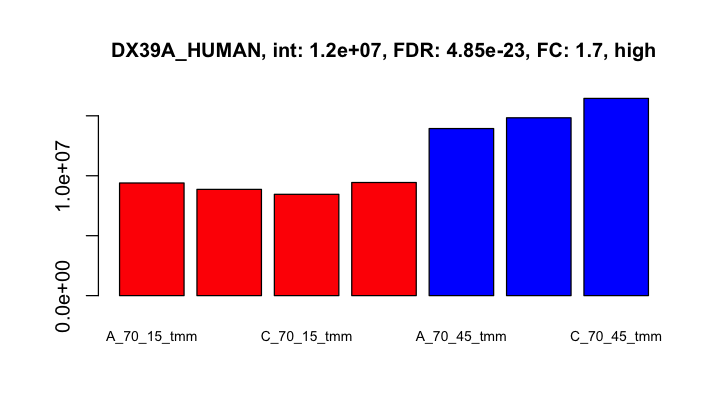

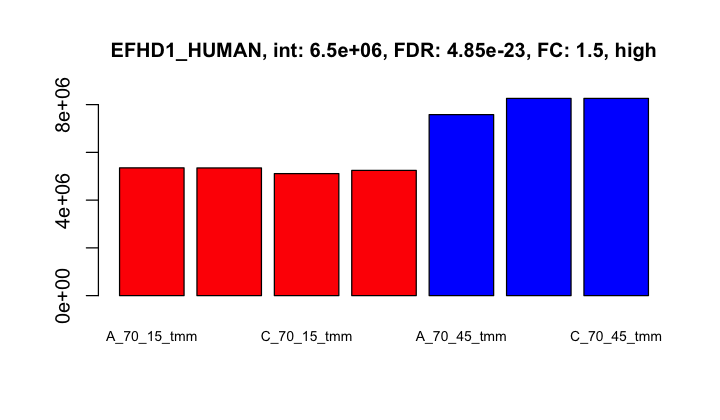

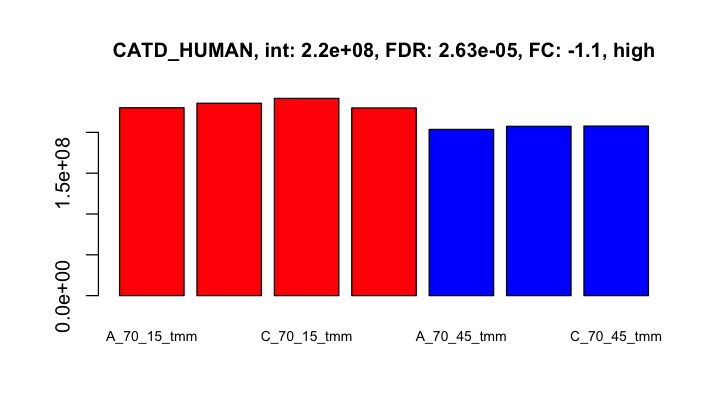

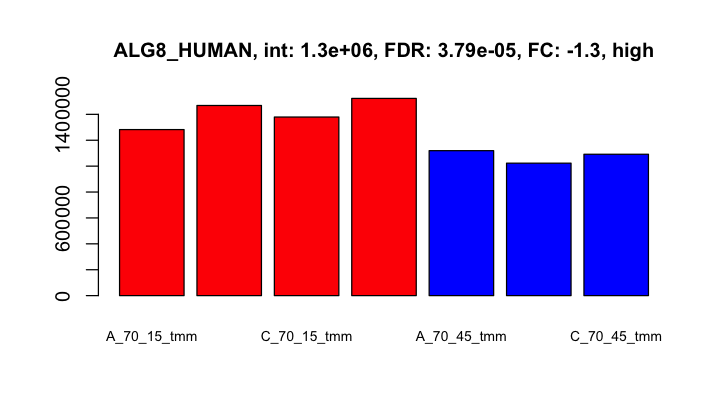

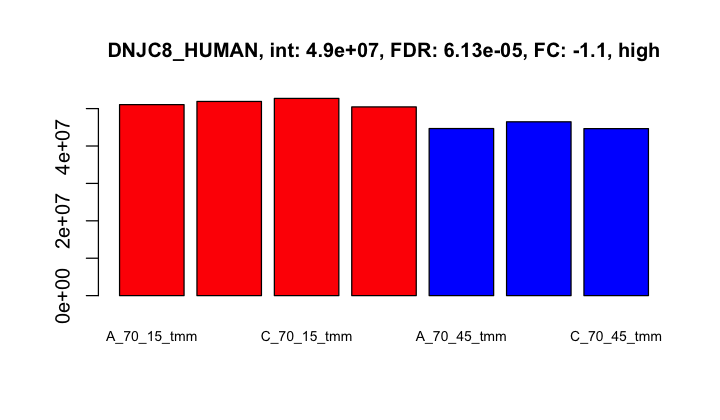

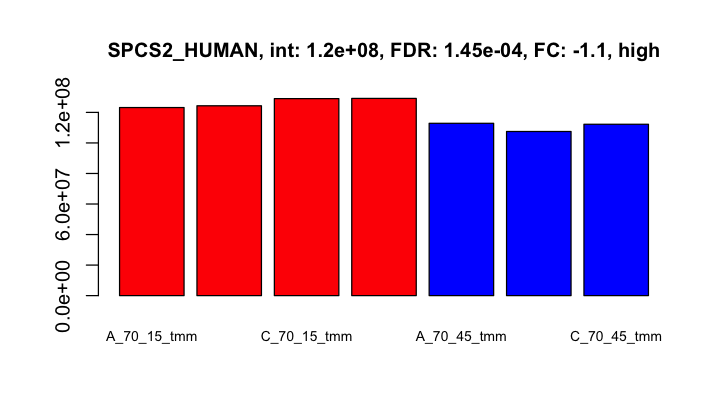

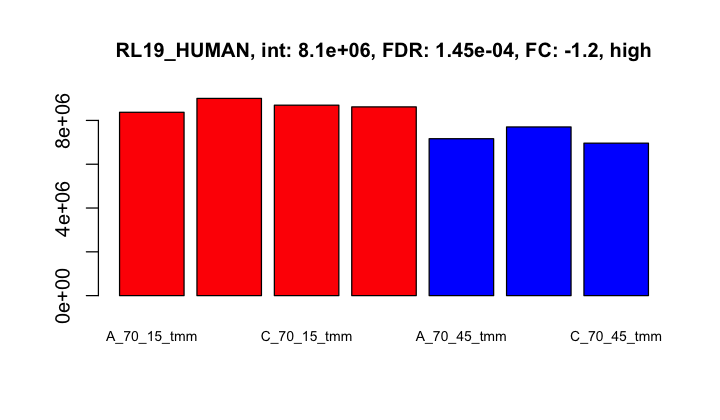

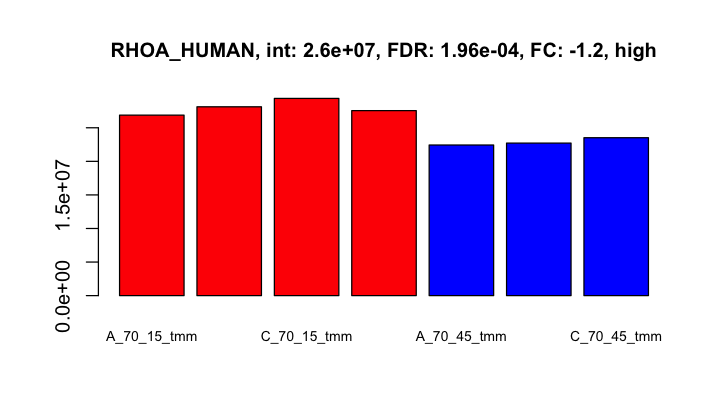

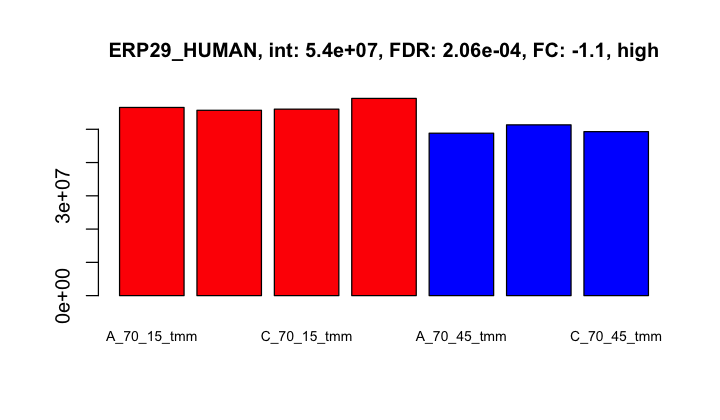

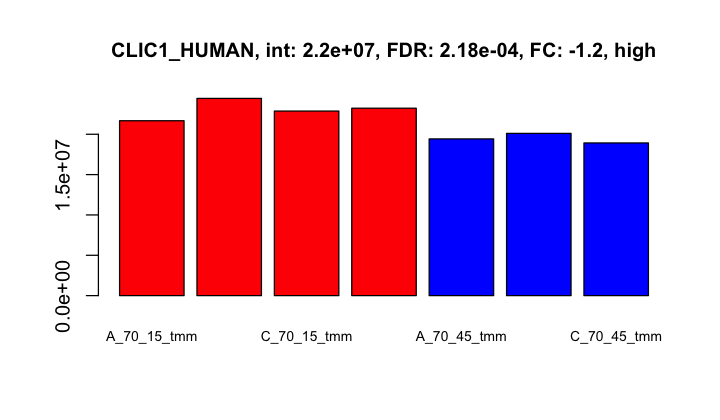

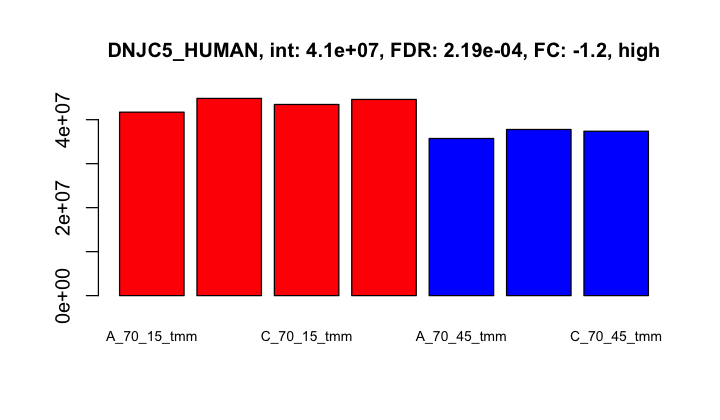

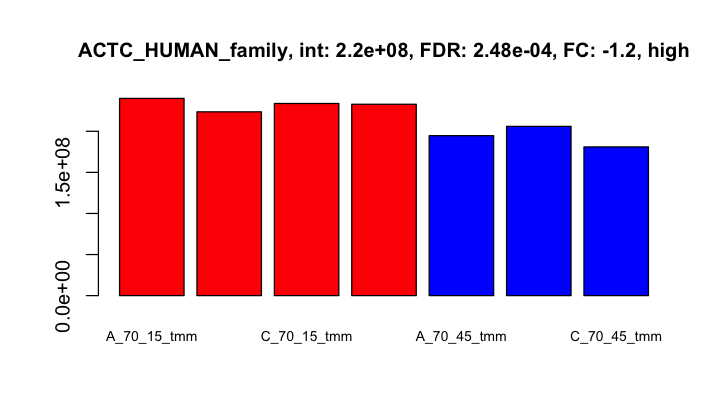

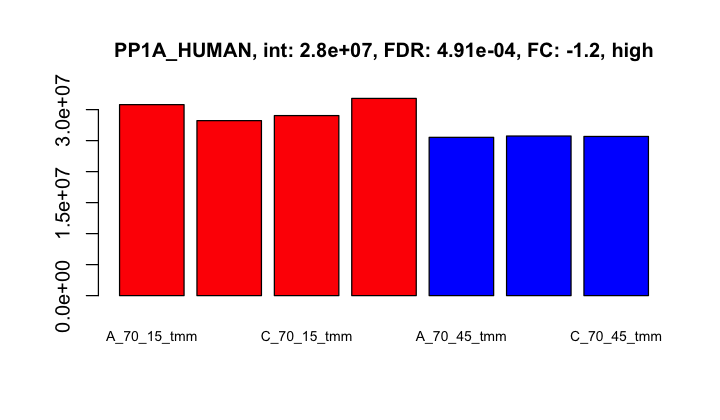

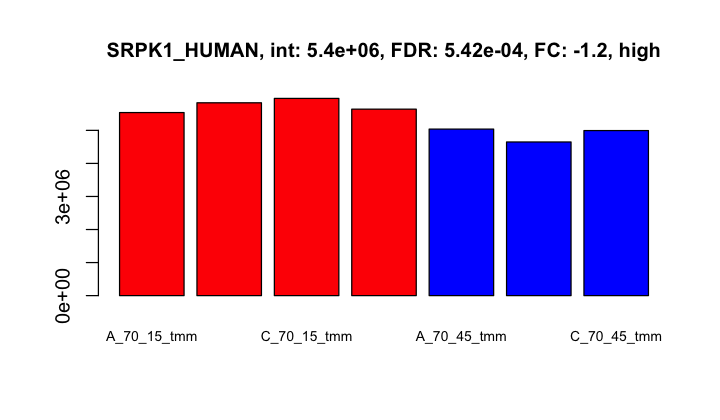

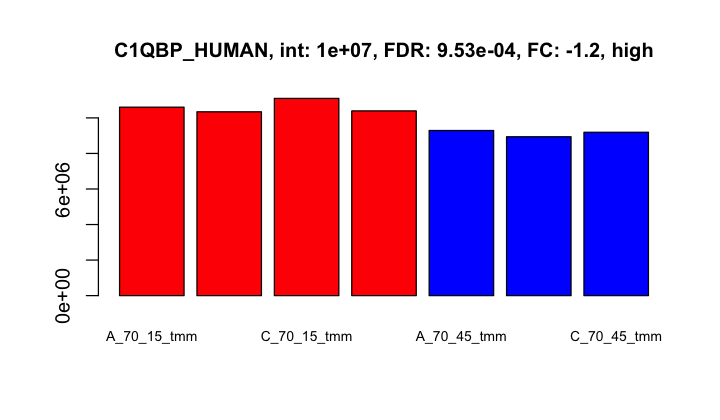

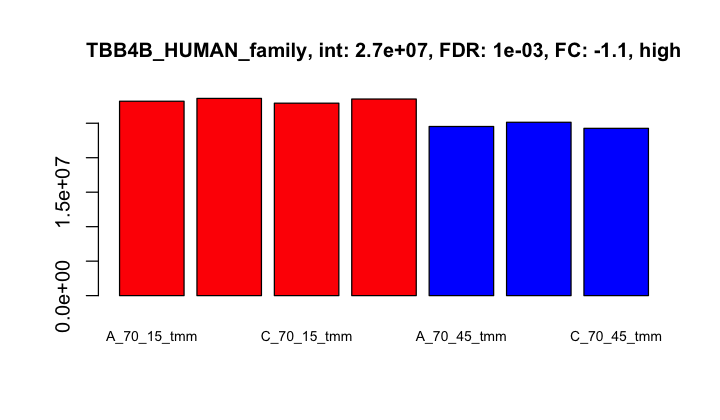

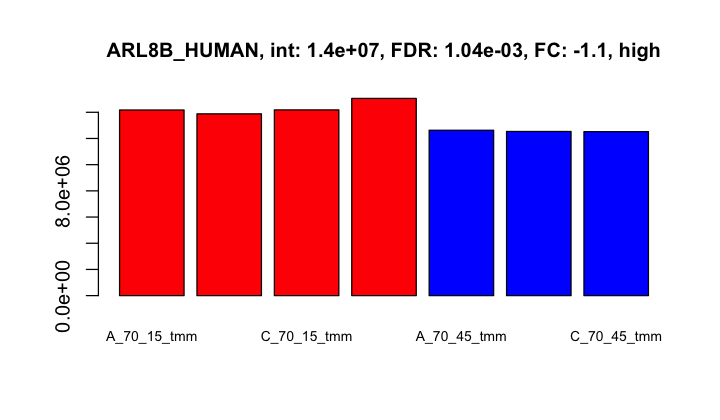

In [29]:
# look at the top candidates
set_plot_dimensions(6, 3.5)
plot_top_tags(results, 4, 3, 15)
set_plot_dimensions(7, 7)

### Again, candidates seem plausible

We have some asymmetry in up versus down candidates. We do not have large fold-changes, but the differences in means seem pretty convincing. 

### Check CV distributions by spike-in

As a final check, we can see what the median CVs are like for each set of channels. 

In [30]:
# ============== CV function ===================================================
CV <- function(df) {
    # Computes CVs of data frame rows
        # df - data frame, 
        # returns vector of CVs (%)
    ave <- rowMeans(df)    # compute averages
    sd <- apply(df, 1, sd) # compute standard deviations
    cv <- 100 * sd / ave   # compute CVs in percent (last thing gets returned)
}

# put CVs in data frames to simplify plots and summaries
cv_tmm <- data.frame(low_7.5 = CV(tmt_tmm[low]), med_15 = CV(tmt_tmm[med]), high_45 = CV(tmt_tmm[high]))

# see what the median CV values are
medians <- apply(cv_tmm, 2, FUN = median)
print("Final median CVs by condition (%)")
round(medians, 2)

[1] "Final median CVs by condition (%)"


low_7.5  med_15 high_45 
   4.30    4.25    4.03

### Median CVs do not depend on the E. coli background

We have seen smaller CVs for MS2 reporter ions compared to SPS MS3 data in the past. 5% median CVs are almost too good to be true (these are kind of technical replicates, though). We do not see any strong trend between median CV and the E. coli spike-in level. 

---

## <a name="summary"></a> Summary

Reporter ions from MS2 scans have real issues. Over a decade of research has demonstrated that MS2 reporter ions signals are not reliable measurements. The compressed range of the measurements does much more than just make fold-changes less accurate. It creates artificially reduced variances that can drive statistical testing false positives. 

We see that when we have a lot of differentially expressed proteins (the E. coli here), we have different serious problems. The background signals that can add to the true reporter ion signals may not have the same expression pattern and moderate changes or even create incorrect expression patterns. We have no way to know which are the specific proteins that might be affected. We can also have potential effects on normalization algorithms. Those effects could result in potentially large numbers of false test results.

---
## Save the `all_results` frame to TSV file

In [31]:
write.table(all_results, "edgeR_human_results.txt", sep = "\t",
           row.names = FALSE, na =  " ")

## Log the session information

In [32]:
sessionInfo()

R version 3.5.3 (2019-03-11)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.15.5

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] psych_1.9.12.31 edgeR_3.24.3    limma_3.38.3    scales_1.1.0   
 [5] forcats_0.5.0   stringr_1.4.0   dplyr_0.8.5     purrr_0.3.3    
 [9] readr_1.3.1     tidyr_1.0.2     tibble_2.1.3    ggplot2_3.3.0  
[13] tidyverse_1.3.0

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.4       locfit_1.5-9.1   lubridate_1.7.4  lattice_0.20-40 
 [5] assertthat_0.2.1 digest_0.6.25    IRdisplay_0.7.0  R6_2.4.1        
 [9] cellranger_1.1.0 repr_1.1.0       backports_1.1.5  reprex_0.3.0    
[13] evaluate

## Another way to check the thinking

The idea here is that the stair-stepped E. coli proteins are creating a ghost background that distorts the intensities for the human proteins. We can shuffle the samples so that we average out the differences in the E. coli samples and see how that affects the statistical testing.

We need to split up 3, 4, and 3 samples to balance out the E. coli levels.

In [33]:
# define 2 random groups
# random <- sample(1:10)
# A <- random[1:5]
# B <- random[6:10]

# keep the random assignments from above
A <- c(10, 3, 5, 4, 7)
B <- c(6, 8, 1, 9, 2)

# set some colors by condition
colors = c(rep('red', length(A)), rep('blue', length(B)))


Library size factors:
 C_70_45 -> 1.175872
 C_70_7pt5 -> 0.986180
 B_70_15 -> 0.915419
 A_70_15 -> 0.901481
 D_70_15 -> 1.011951
 C_70_15 -> 0.849285
 A_70_45 -> 1.193684
 A_70_7pt5 -> 0.957242
 B_70_45 -> 1.088943
 B_70_7pt5 -> 1.033604

Trimmed mean of M-values (TMM) factors:
 C_70_45 -> 0.967713
 C_70_7pt5 -> 1.009745
 B_70_15 -> 1.004676
 A_70_15 -> 1.006735
 D_70_15 -> 0.999311
 C_70_15 -> 1.010853
 A_70_45 -> 0.980196
 A_70_7pt5 -> 1.022173
 B_70_45 -> 0.981987
 B_70_7pt5 -> 1.018050

Combined (lib size and TMM) normalization factors:
 C_70_45 -> 1.137906
 C_70_7pt5 -> 0.995790
 B_70_15 -> 0.919699
 A_70_15 -> 0.907553
 D_70_15 -> 1.011253
 C_70_15 -> 0.858503
 A_70_45 -> 1.170044
 A_70_7pt5 -> 0.978467
 B_70_45 -> 1.069328
 B_70_7pt5 -> 1.052261


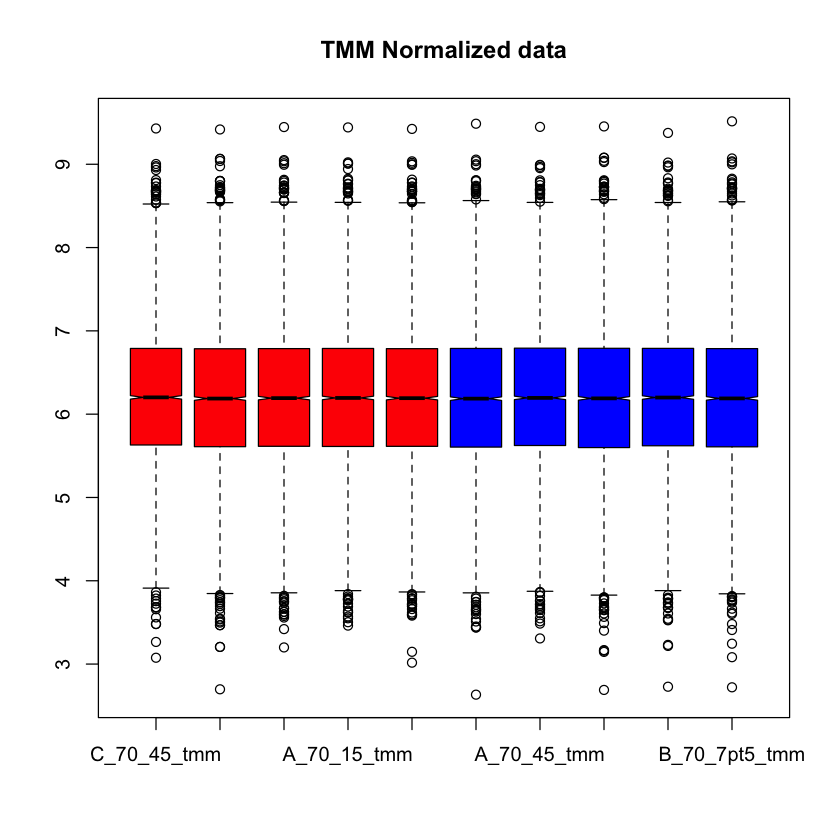

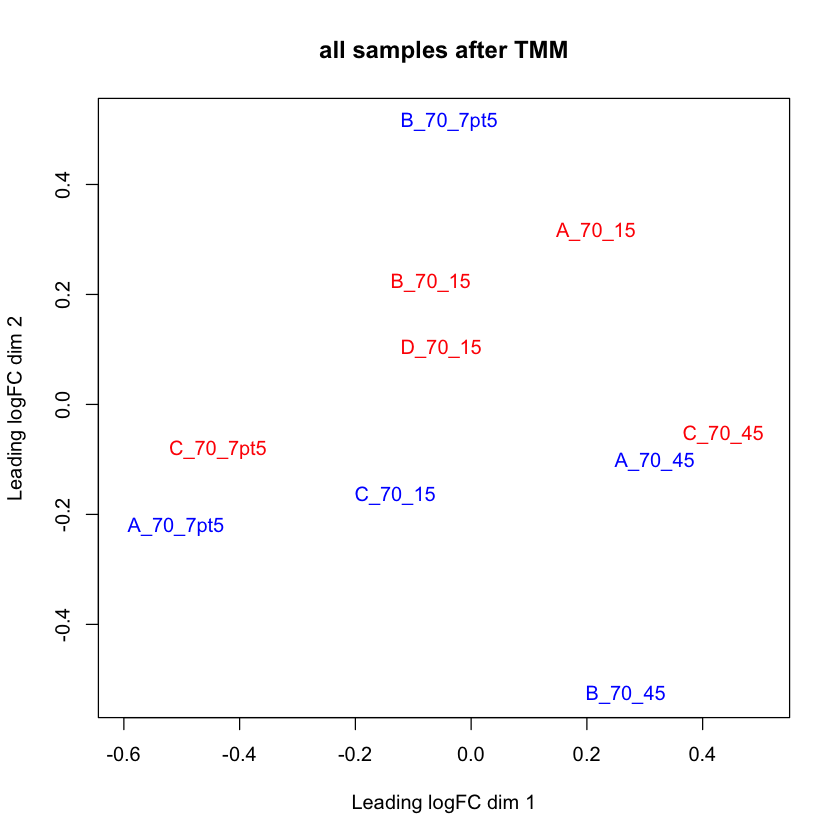

In [34]:
# get the biological sample data into a DGEList object
group = c(rep("A", length(A)), rep("B", length(B)))
y <- DGEList(counts = cbind(data_tmt[A], data_tmt[B]), group = group, genes = accessions)

# run TMM normalization (also includes a library size factor)
y <- calcNormFactors(y)

tmt_tmm <- apply_tmm_factors(y, color = colors)

# check the clustering
plotMDS(y, col = colors, main = "all samples after TMM")

Design matrix not provided. Switch to the classic mode.


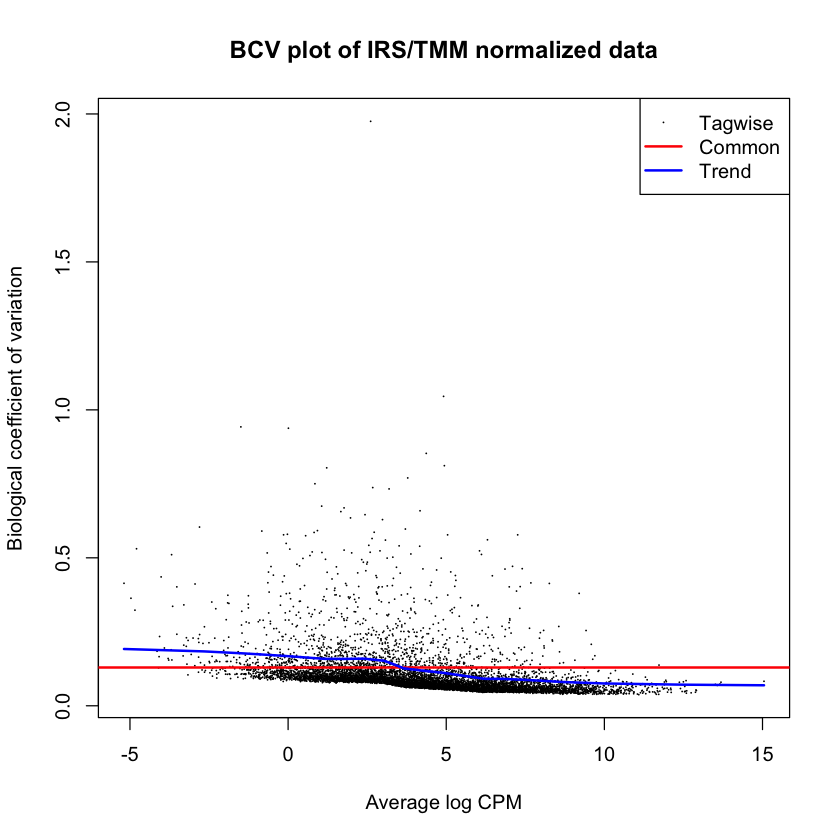

In [35]:
# compute dispersions and plot BCV
y <- estimateDisp(y)
plotBCV(y, main = "BCV plot of IRS/TMM normalized data")

### Clustering looks more random

We seem to have eliminated the clustering by E. coli channel. We can run the statistical tests.

        B-A
Down      0
NotSig 7558
Up        1

genes                 logFC      logCPM      PValue       FDR       
4194 sp|Q01196|RUNX1_HUMAN  0.6353669  3.86863761 3.781018e-06 0.02858072
1299 sp|P08575|PTPRC_HUMAN -1.0794213  7.00795695 7.248370e-05 0.19864046
5517 sp|P33241|LSP1_HUMAN  -1.7579222  2.48885629 1.022394e-04 0.19864046
6606 sp|Q9BZG1|RAB34_HUMAN  0.8282803  1.10141050 1.140593e-04 0.19864046
6065 sp|Q9UDR5|AASS_HUMAN   1.0388160  1.87537255 1.568306e-04 0.19864046
7081 sp|Q8WW33|GTSF1_HUMAN -1.9003894  0.05380558 1.576720e-04 0.19864046
6993 sp|Q9NSI8|SAMN1_HUMAN -1.6518116  0.27874348 2.442075e-04 0.25998124
7280 sp|P03986|TRGC2_HUMAN -1.6056495 -0.54092600 2.834534e-04 0.25998124
3656 sp|Q96I15|SCLY_HUMAN  -0.2439912  4.35792843 3.095424e-04 0.25998124
4908 sp|O43736|ITM2A_HUMAN -1.6108624  3.13211133 6.008488e-04 0.45418163

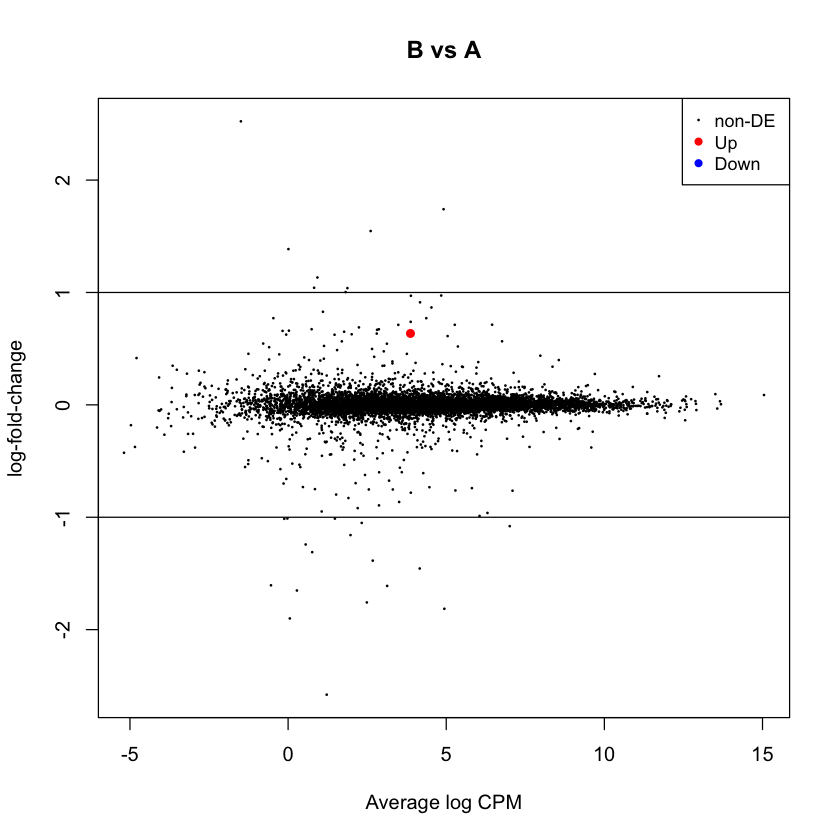

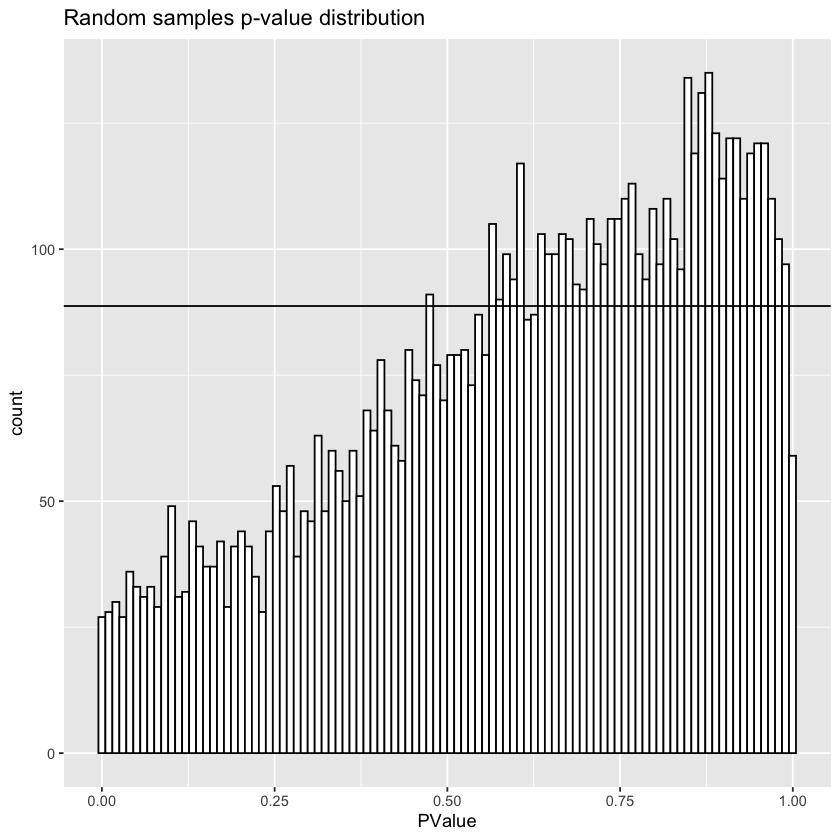

In [36]:
# the exact test object has columns like fold-change, CPM, and p-values
et <- exactTest(y, pair = c("A", "B"))

# this counts up, down, and unchanged genes (proteins) at 10% FDR
summary(decideTestsDGE(et, p.value = 0.10))

# the topTags function adds the BH FDR values to an exactTest data frame 
# make sure we do not change the row order (the sort.by parameter)!
topTags(et)$table
tt <- topTags(et, n = Inf, sort.by = "none")

# make an MD plot (like MA plot)
plotMD(et, p.value = 0.10)
abline(h = c(-1, 1), col = "black")

# check the p-value distribution
ggplot(tt$table, aes(PValue)) + 
  geom_histogram(bins = 100, fill = "white", color = "black") + 
  geom_hline(yintercept = mean(hist(et$table$PValue, breaks = 100, 
                                    plot = FALSE)$counts[26:100])) +
  ggtitle("Random samples p-value distribution")

### We have eliminated the human DE candidates

We now get the expected result that no human proteins are at different expression levels.

In [37]:
# get the results summary
results <- collect_results(tmt_tmm, tt$table, A, "A", B, "B")

# make column names unique by adding comparison (for the accumulated frame)
results_temp  <- results
colnames(results_temp) <- str_c(colnames(results), "_A_B")

# accumulate the testing results
all_results <- results_temp

candidate n   
1 med          1
2 no        7558

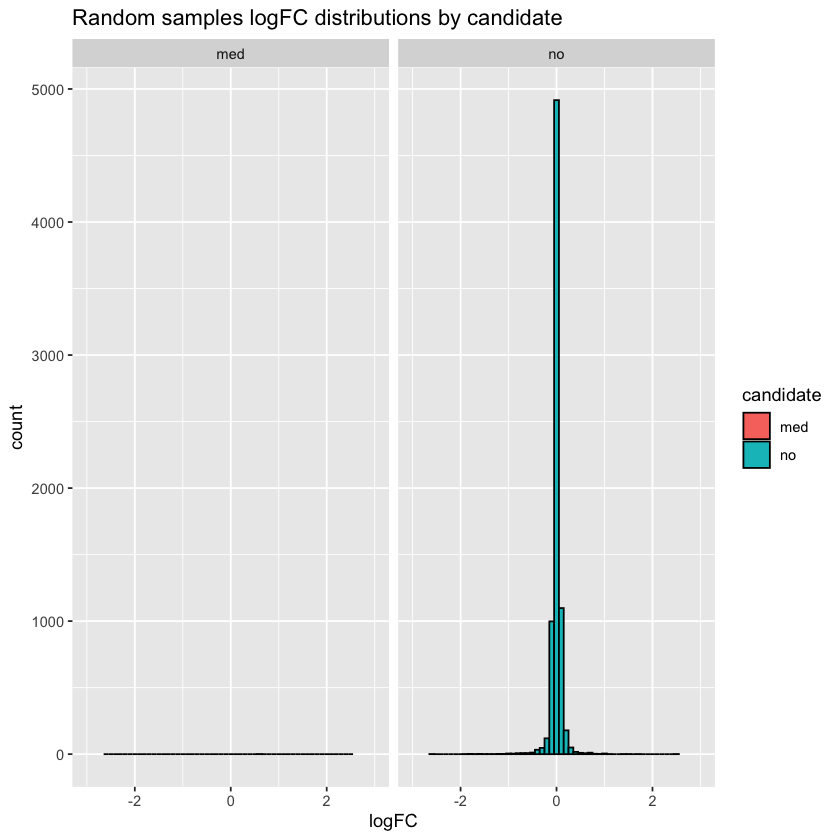

In [38]:
# see how many candidates by category
results %>% count(candidate)

# plot log2 fold-changes by category
ggplot(results, aes(x = logFC, fill = candidate)) +
  geom_histogram(binwidth=0.1, color = "black") +
  facet_wrap(~candidate) +
  coord_cartesian(xlim = c(-3, 3)) +
  ggtitle("Random samples logFC distributions by candidate")

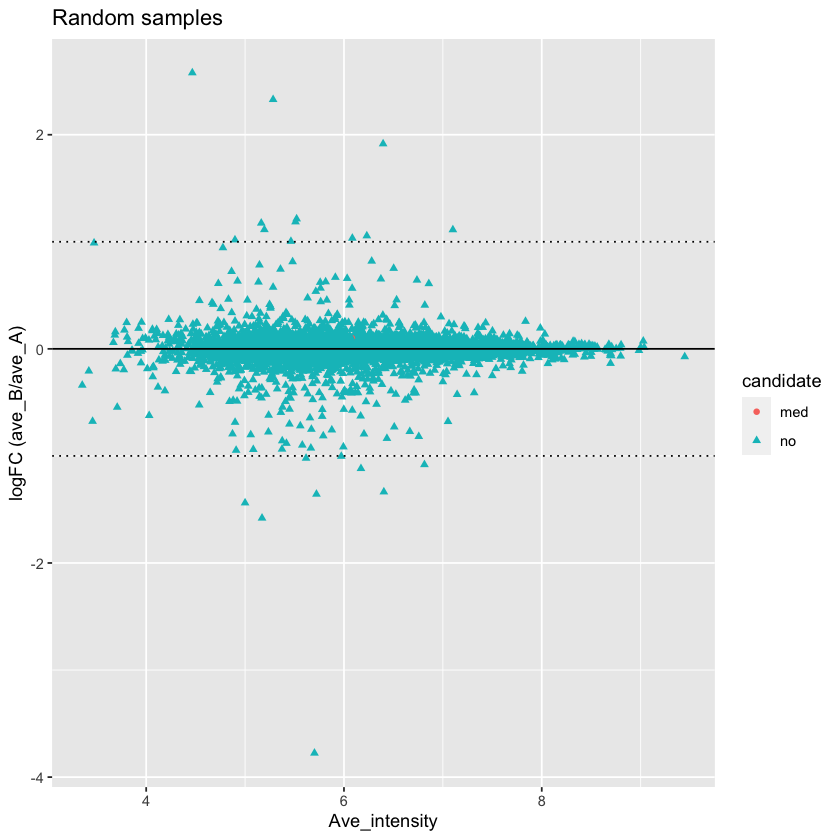

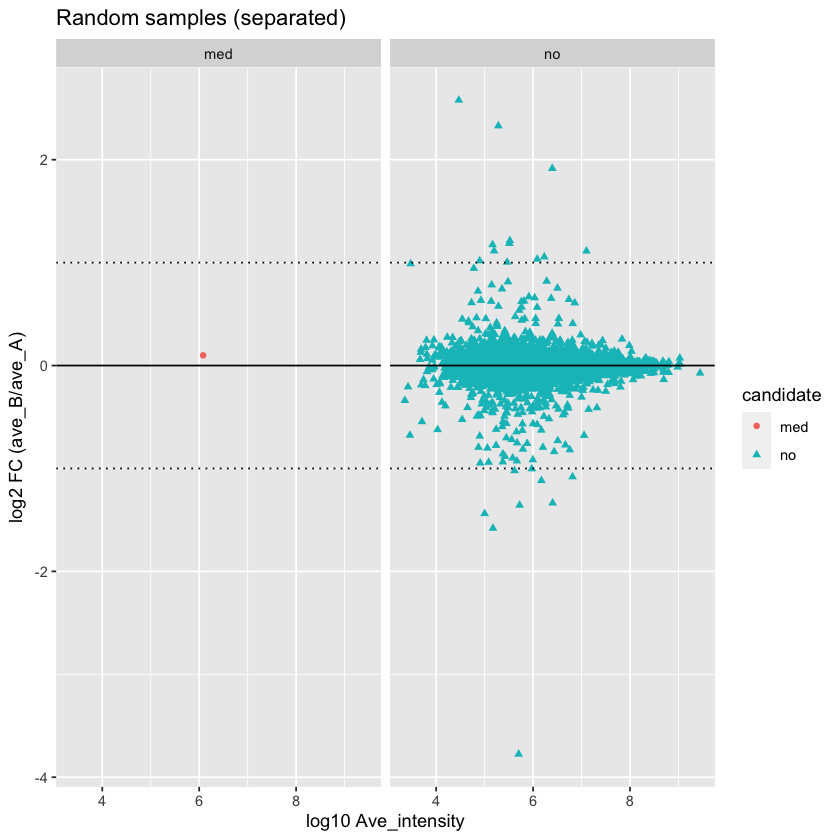

In [39]:
# make MA plots
MA_plots(results, "ave_A", "ave_B", "Random samples")

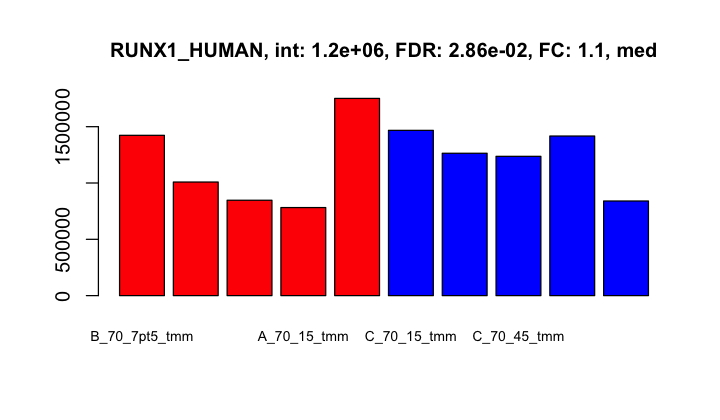

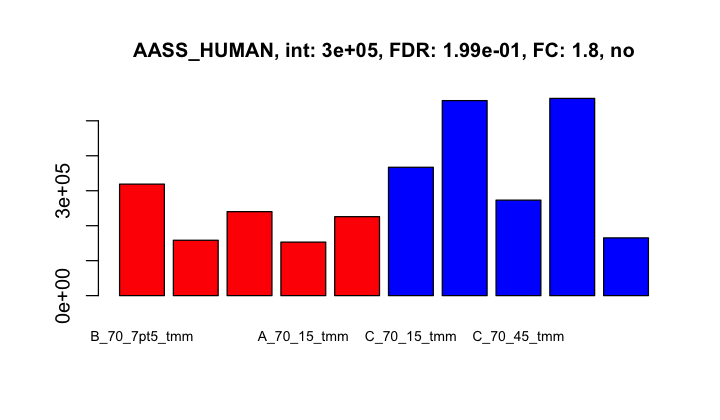

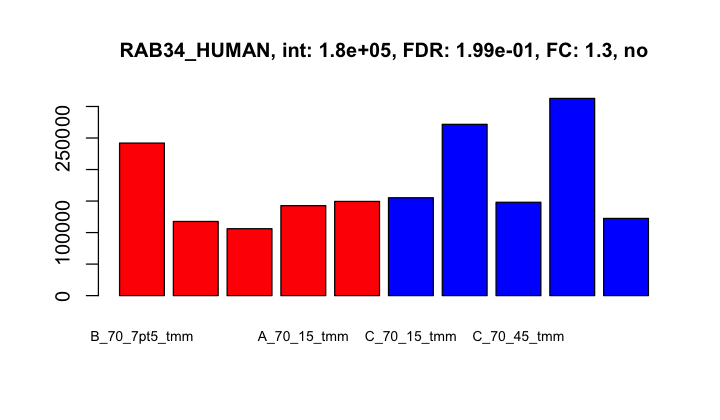

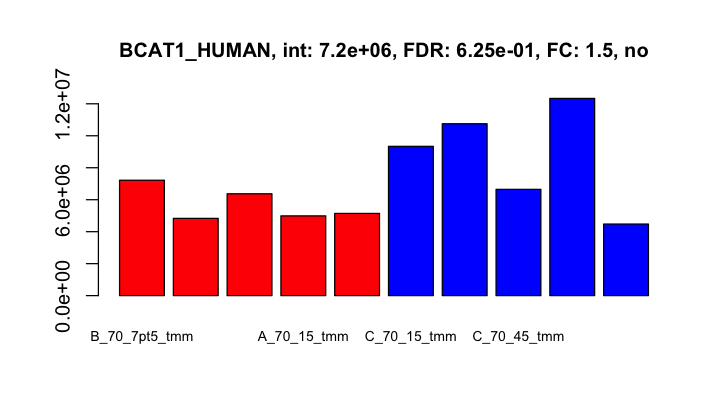

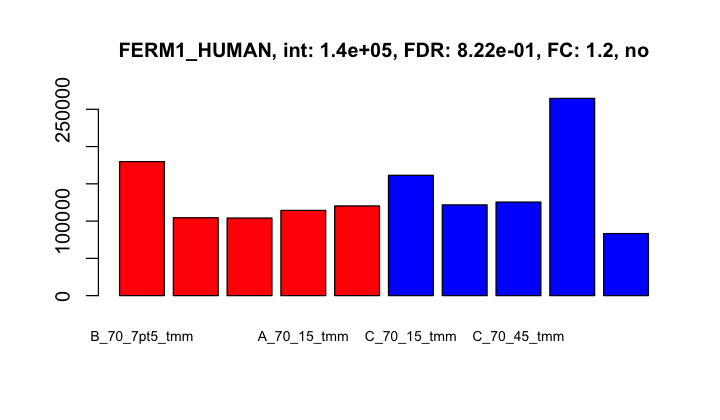

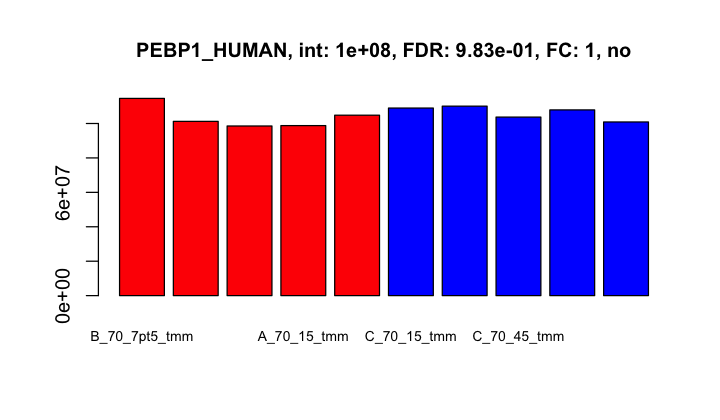

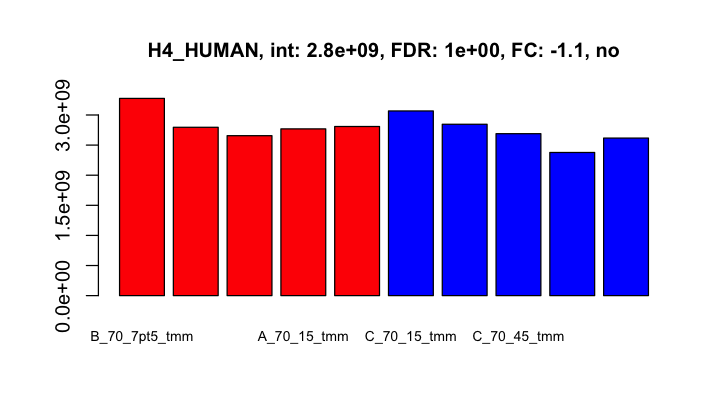

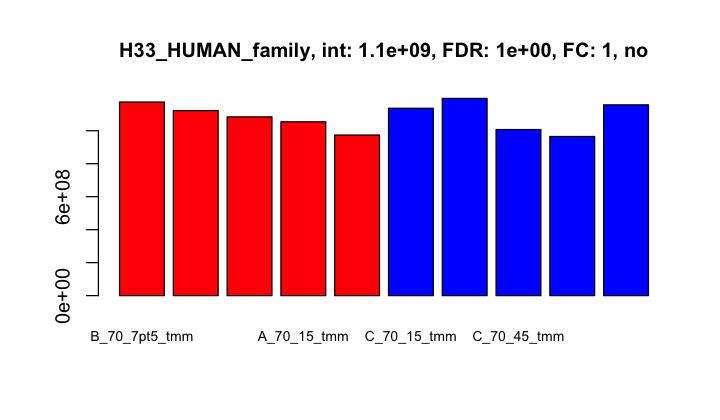

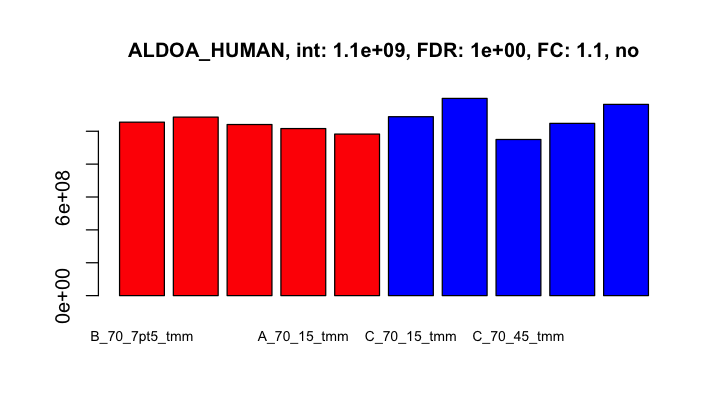

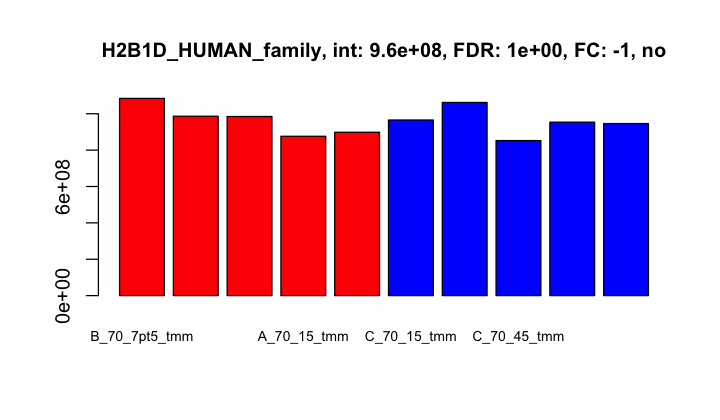

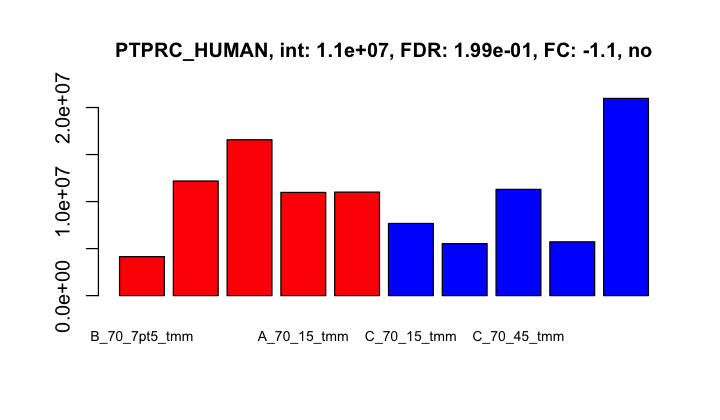

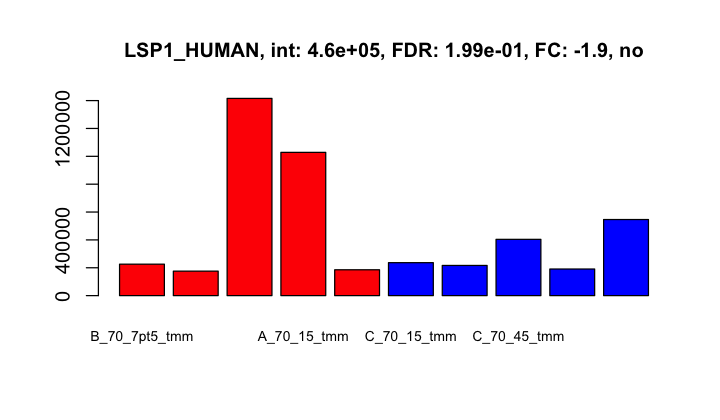

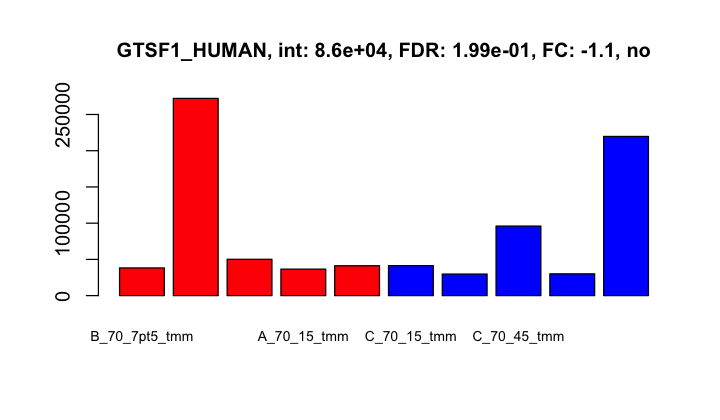

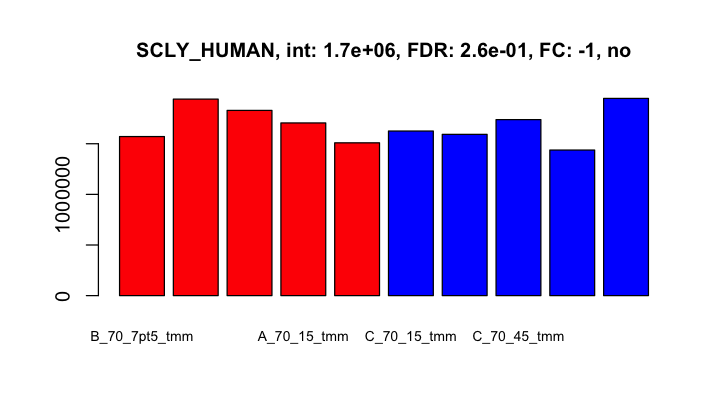

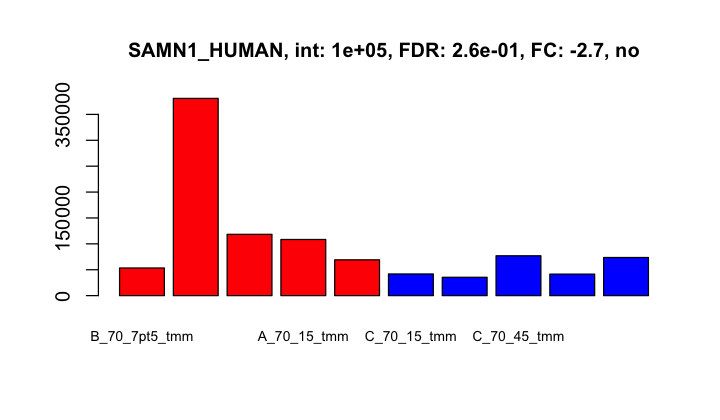

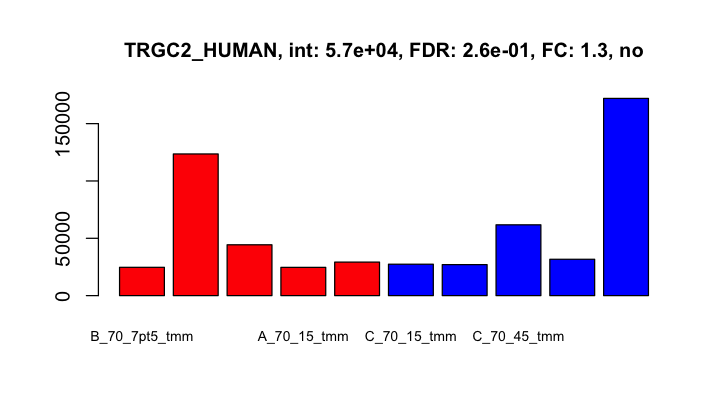

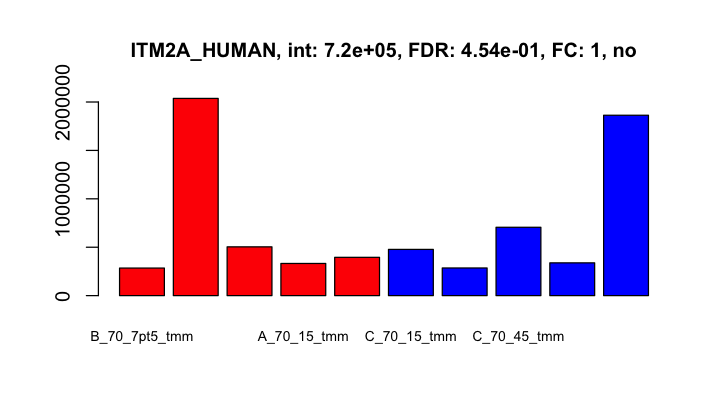

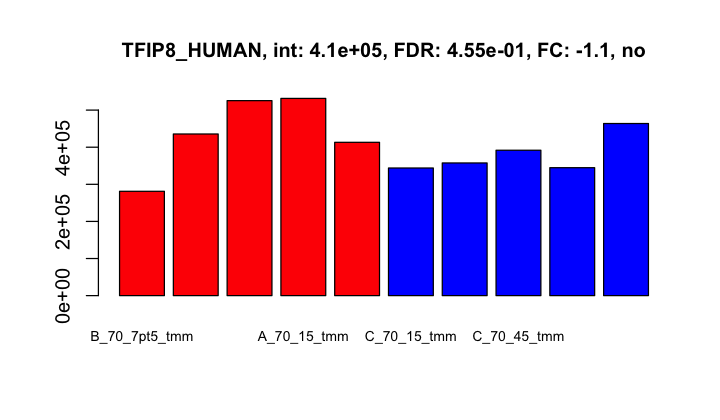

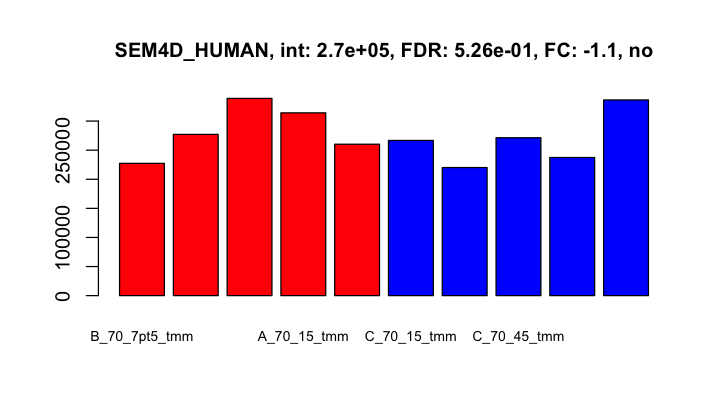

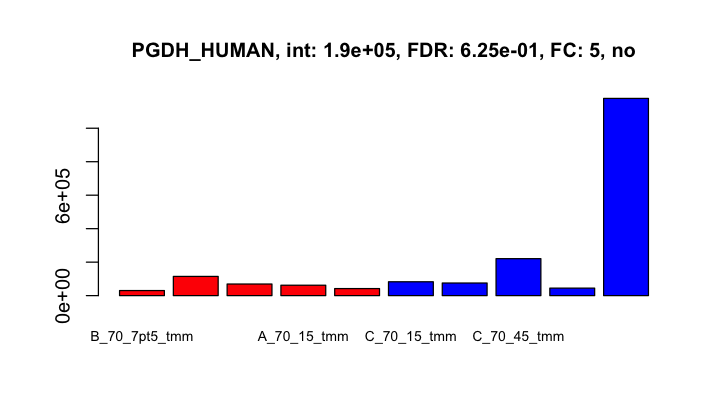

In [40]:
# look at the top candidates
set_plot_dimensions(6, 3.5)
plot_top_tags(results, 5, 5, 10)
set_plot_dimensions(7, 7)

### The E. coli levels were the source of the human false positives

This clearly shows that the false positive human DE candidates were a result of the pattern in the E. coli spike-in levels. Non-specific ghost background is what distorts MS2-based TMT data.